In [27]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import skopt
import matplotlib

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from hwfanalysis.hwf_data import *

sns.set_style('white')
%config InlineBackend.figure_format = 'retina'

from census import Census
from us import states

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
import numpy as np
import datetime

import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from scipy import stats
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Predefinitions

In [28]:
c = Census("5b978f0e407305b77a0595545ee6170b9b8b9ae1")

from us import states
state_to_fips = {s.abbr: s.fips for s in states.STATES_AND_TERRITORIES}
fips_to_states = {s.fips: s.abbr for s in states.STATES_AND_TERRITORIES}
fips = state_to_fips.values()

In [29]:
df_acs_income_codes = pd.read_csv('/Users/altaeth/COVID-APP/git_new/data/census_acs_median_income_retrieval_codes.txt', delimiter='\t')
income_codes = tuple(df_acs_income_codes['Name'].tolist())

inpute_state = False

zcta_income_data = c.acs5.get(('NAME',)+income_codes,
        {'for': 'zip code tabulation area:*'}, year=2018)

zcta_state_income_data = c.acs5.get(('NAME',)+income_codes,
        {'for': 'state:*'}, year=2018)

In [30]:
df_income = pd.DataFrame(zcta_income_data)

df_state_income = pd.DataFrame(zcta_state_income_data)

In [31]:
# impute missing county income data
states_fips = {s.fips : str(s) for s in states.STATES_AND_TERRITORIES} 
if inpute_state:
    for state_fip,state in states_fips.items():
        # Get all the zctas for ra given state using the fip prefix
        state_info = df_income[df_income['zip code tabulation area'].str.contains(state_fip+'\d\d\d',regex=True)]
        # If state has no data skip
        if len(df_state_income[df_state_income['NAME'] == state]) == 0:         
            continue        

        index = df_income[df_income['zip code tabulation area'].isin(NM_correction)].index
        # Iterate through all income codes and fill missing values for a given zcta in a state with the state value
        for z in income_codes:        
            fill_val = df_state_income[df_state_income['NAME'] == state][z].values[0]
            # Get zctas with missing data for given income column
            index = state_info[state_info.fillna('-1')[z].astype('float') < 0].index

            # Fill all indices for given column with state value
            for i in index:
                df_income.loc[[i],z] = fill_val
else:
    df_income.fillna(-666666666)
# Replace fields into human understandable labels
d = {c : l for c,l in df_acs_income_codes[['Name','Concept']].values}
df_income = df_income.rename(columns=d)

In [32]:
def enrich_with_incomes(R):
    df_zip = pd.read_csv('../data/zip_to_zcta_2019.txt',  delimiter='\t',dtype={'ZIP_CODE' : 'str'})
    df_zip['ZIP_CODE'] = df_zip['ZIP_CODE'].astype('int').astype('str').str.zfill(5)
    df_zip = df_zip.set_index(keys='ZIP_CODE')
    zip_to_zcta = df_zip['ZCTA'].to_dict()

    race_list = [('race_ethnicity_white', '(WHITE ALONE, NOT HISPANIC OR LATINO HOUSEHOLDER)'),
            ('race_ethnicity_hispanic_latino', '(HISPANIC OR LATINO HOUSEHOLDER)'),             
            ('race_ethnicity_african_american', '(BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)'),
            ('race_ethnicity_asian','(ASIAN ALONE HOUSEHOLDER)'),
            ('race_ethnicity_american_indian_or_alaska_native', '(AMERICAN INDIAN AND ALASKA NATIVE ALONE HOUSEHOLDER)'),
            ('race_ethnicity_hawaiian_or_islander','(NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE HOUSEHOLDER)'),
            ('race_ethnicity_multi', '(TWO OR MORE RACES HOUSEHOLDER)'),
            ('race_ethnicity_other','(SOME OTHER RACE ALONE HOUSEHOLDER)'),
            ('race_ethnicity_unknown','(SOME OTHER RACE ALONE HOUSEHOLDER)')   
                ]     

    def apply_weights(x):
        x_race = None
        x_ext = None
        for r,ext in race_list:
            if x[r]:
                x_race = r  
                x_ext = ext
        if x_race is None:
            assert x['race_ethnicity_unknown'], str(x)
        age = None

        ztca = zip_to_zcta.get(str(int(x.zipcode)).zfill(5),-1)
        if ztca == -1 or x_ext is None:
            return -66666666
        df_p = df_income[df_income['zip code tabulation area'] == ztca]
        if df_p.shape[0] == 0:
            return -66666666

        income = df_p['MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) '+x_ext].values[0]
        return income
    R['income'] = R.apply(apply_weights, axis=1)

    df_temp = df_income.set_index('zip code tabulation area')
    med_income_lookup = df_temp['MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)'].to_dict()

    def apply_weights(x):
        x_race = None
        x_ext = None
        for r,ext in race_list:
            if x[r]:
                x_race = r  
                x_ext = ext
        if x_race is None:
            assert x['race_ethnicity_unknown'], str(x)
        age = None

        ztca = zip_to_zcta.get(str(int(x.zipcode)).zfill(5),-1)
        income = med_income_lookup.get(ztca, -66666666)

        return income
    R['income_unadjusted'] = R.apply(apply_weights, axis=1)
    return R 

In [33]:
# load HWF data
df_renorm_reformat = pd.read_csv("/Users/altaeth/COVID-APP/git_new/python/data/hwf_clean_2020-05-12.csv")

/Users/altaeth/Installations/Anaconda/anaconda3/envs/hwfanalysis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning:

Columns (16,17,18,19,20,53,71) have mixed types.Specify dtype option on import or set low_memory=False.



In [34]:
results = df_renorm_reformat[df_renorm_reformat['survey_version'] == 4].copy()

In [35]:
# Add pseudo-date
results['date'] = pd.to_datetime(results['date'])
last_checkin = results.groupby('session_id').agg({'date' : max})
last_checkin['last_checkin'] = last_checkin['date']
last_checkin = last_checkin.drop(columns=['date'])
last_checkin = last_checkin.reset_index()
results_with_pseudo = last_checkin.merge(results, on='session_id')

results_with_pseudo['pseudo_test_date'] = results_with_pseudo['last_checkin'] - pd.to_timedelta(7,unit='days')
R_pre_pseudo = results_with_pseudo[(results_with_pseudo['date'] < results_with_pseudo['pseudo_test_date']) & 
                         (results_with_pseudo['date'] + pd.to_timedelta(14,unit='days') >= results_with_pseudo['pseudo_test_date'])]

In [36]:
duplicate_symptoms = {'symptoms_cough': ['not_well_symptoms_dry_cough', 'not_well_symptoms_wet_cough','symptoms_well_cough'],
            #'symptoms_abdominal_pain':[ 'not_well_symptoms_abdominal_pain'],
            'symptoms_chills_shaking' :[ 'not_well_symptoms_chills_shaking', 'symptoms_well_chills',],
            #'symptoms_headache':['symptoms_well_headache'],
            'symptoms_loss_of_taste_and_or_smell':[ 'symptoms_well_loss_of_taste_and_or_smell','not_well_symptoms_loss_of_taste_and_or_smell'],
            'symptoms_diarrhea':['not_well_symptoms_diarrhea'],
            'symptoms_loss_of_appetite':['not_well_symptoms_loss_of_appetite','symptoms_well_loss_of_appetite'],
            'symptoms_tight_feeling_in_chest':['symptoms_well_tight_feeling_in_chest','not_well_symptoms_tight_feeling_in_chest'],
            'symptoms_muscle_and_joint_pain':['not_well_symptoms_muscle_and_joint_pain','symptoms_well_muscle_and_joint_pain'],
            #'symptoms_none':['symptoms_none','symptoms_well_none'],
            #'symptoms_confusion':['not_well_symptoms_confusion'],
            'symptoms_nasal_congestion':['not_well_symptoms_nasal_congestion','symptoms_well_nasal_congestion'],
            'symptoms_shortness_of_breath':['not_well_symptoms_shortness_of_breath'],
            'symptoms_nausea_and_vomiting':['not_well_symptoms_nausea_and_vomiting'],
            'symptoms_runny_nose':['symptoms_well_runny_nose','not_well_symptoms_runny_nose'],
            'symptoms_sore_throat':['not_well_symptoms_sore_throat'],
            'symptoms_fatigue':['not_well_symptoms_fatigue', 'symptoms_well_mild_fatigue'],
            'symptoms_fever':['symptoms_well_low_grade_fever','not_well_symptoms_fever'],
            'symptoms_facial_numbness':['not_well_symptoms_facial_numbness'],
            #'symptoms_irregular_heartbeat':['not_well_symptoms_irregular_heartbeat'],
            'symptoms_tingling_sensation':['not_well_symptoms_tingling_sensation'],
            #'symptoms_tinnitus':['not_well_symptoms_tinnitus']
                     }


duplicate_symptoms_keys = ['symptoms_cough',
 'symptoms_chills_shaking',
 'symptoms_loss_of_taste_and_or_smell',
 'symptoms_diarrhea',
 'symptoms_loss_of_appetite',
 'symptoms_tight_feeling_in_chest',
 'symptoms_muscle_and_joint_pain',
 # 'symptoms_confusion',  This was incosistent
 'symptoms_nasal_congestion',
 'symptoms_shortness_of_breath',
 'symptoms_nausea_and_vomiting',
 'symptoms_runny_nose',
 'symptoms_sore_throat',
 'symptoms_fatigue',
 'symptoms_fever',
 'symptoms_facial_numbness',
 'symptoms_tingling_sensation']

def cleanup_symptoms(df_in):
    for name, x in duplicate_symptoms.items():
        collapsed = df_in[x].any(1).to_frame(name).copy()
        print(f'Working on {name}!')
        #df_in = df_in.drop(columns = x)
        df_in.loc[:,name] = collapsed
    return df_in

# Featurization

"""
Instructions:

TO run featurization for "who gets tested" or "who test positive", run following featurization code *until featurization end* TWICE. First time, set pseudo=False to get the information from those who were tested. Then run pseudo=True to fill in info for everyone else who was not tested. 

To run for the Figure 4 analysis, run with pseudo = True, and pre_test_only = False nad post_test_only = False

To run for XGBoost analysis run with pseudo = False, and pre_test_only = False and again with pre_test_only = True
"""

In [60]:
### COVID Prediction

min_date = datetime.datetime(2020,3,1)  # Min absolute date for getting test data
min_survey_date = datetime.datetime(2020,4,1)
min_any_date = datetime.datetime(2020,1,1)  # Quality control min date

pseudo = True  # If true, use the pseudo date, and other 
pre_test_only = False  # if using pre test data only, then days after test is irrelevant
post_test_only = False
# Which timestamps to keep relative to test date (window around test date for data)
max_days_before_test = 14
max_days_after_test = 14
# Number of days before test to prioritize. For multiple responses, take the one closset
# To this many days before the test
days_before_test_priority = 1  

symptoms_mode = 'mean' # {'any', 'mean', closest'}

symptoms = [
 'not_well_symptoms_abdominal_pain',
 'not_well_symptoms_chills_shaking',
 #'not_well_symptoms_confusion',
 'not_well_symptoms_diarrhea',
 'not_well_symptoms_dry_cough',
 #'not_well_symptoms_facial_numbness',
 #'not_well_symptoms_fatigue',
 'not_well_symptoms_fever',
 #'not_well_symptoms_headache',
 'not_well_symptoms_irregular_heartbeat',
 'not_well_symptoms_loss_of_appetite',
 'not_well_symptoms_loss_of_taste_and_or_smell',
 'not_well_symptoms_muscle_and_joint_pain',
 'not_well_symptoms_nasal_congestion',
 'not_well_symptoms_nausea_and_vomiting',
 #'not_well_symptoms_none',
 'not_well_symptoms_runny_nose',
 'not_well_symptoms_shortness_of_breath',
 'not_well_symptoms_sore_throat',
 'not_well_symptoms_tight_feeling_in_chest',
 'not_well_symptoms_tingling_sensation',
 'not_well_symptoms_tinnitus',
 'not_well_symptoms_wet_cough',
 'symptoms_well_chills',
 'symptoms_well_cough',
 'symptoms_well_headache',
 'symptoms_well_loss_of_taste_and_or_smell',
 'symptoms_well_low_grade_fever',
 'symptoms_well_mild_fatigue',
 'symptoms_well_muscle_and_joint_pain',
 'symptoms_well_nasal_congestion',
 #'symptoms_well_none',
 'symptoms_well_runny_nose',
 'symptoms_well_tight_feeling_in_chest',
           ]

# Which social behaviors
social = ['social_in_home_isolation', 
          'social_social_distancing',
          'social_stay_at_home_as_much_as_possible',
          #'social_no_change_to_typical_activities', # Reference is no change to actitivites 
         ]

other = [ 'covid_19_exposed_quarantine',
          'covid_19_other_exposed',
          'covid_19_other_lives_in_household',
          'covid_19_symptoms_in_household',     
        ]
household_counts = [#'household_members_count_1', # Use 1 as reference
                    'household_members_count_2',
                    'household_members_count_3',
                    'household_members_count_4',
                    'household_members_count_5',
                    #'household_members_count_no_info'
                   ]

interactions = ['covid_19_other_lives_in_household_and_not_exposed',
                'covid_19_symptoms_in_household_and_not_exposed',
                'covid_19_symptoms_in_household_and_not_other_lives_in_household'
               ]

profession = [ 'profession_construction',
 'profession_critical_manufacturing',
 'profession_delivery',
 'profession_essential_retail',
 'profession_food_production',
 'profession_food_service',
 'profession_healthcare',
 'profession_law_first_responder',
 #'profession_none', # Baseline is none
 'profession_public_works',
 'profession_transportation',]

preexisting = ['preexisting_allergies',
 'preexisting_asthma',
 'preexisting_autoimmune_disease',
 'preexisting_cancer',
 'preexisting_cardiovascular_disease',
 'preexisting_chronic_lung_disease',
 'preexisting_chronic_kidney_disease',
 'preexisting_diabetes',
 'preexisting_hypertension',
 'preexisting_immunodeficiency',
 'preexisting_liver_disease',
 'preexisting_not_say',
 'preexisting_pregnant',
 #'preexisting_none', # Baseline is none
              ]

food_source =  ['food_source_convenience_store',
 'food_source_delivery',
 'food_source_food_bank',
 'food_source_other',
 'food_source_restaurant',
 'food_source_supermarket',] # Baseline is none of these

temperature = ['symptoms_temp_f_100-101',
               'symptoms_temp_f_101-102',
               #'symptoms_temp_f_102-103',
               'symptoms_temp_f_102+'] # aseline is no fever

gender = ['female']#, 'other']


appointments = ['cancelled_medical_appointment_yes',                 
                #'cancelled_medical_appointment_no', 
                'cancelled_medical_appointment_isnan']

feeling = ['feeling']

In [61]:
mixed_columns = ['not_well_symptoms_abdominal_pain',
 'not_well_symptoms_chills_shaking',
 'not_well_symptoms_diarrhea',
 'not_well_symptoms_dry_cough',
 'not_well_symptoms_facial_numbness',
 'not_well_symptoms_fever',
 'not_well_symptoms_irregular_heartbeat',
 'not_well_symptoms_loss_of_appetite',
 'not_well_symptoms_muscle_and_joint_pain',
 'not_well_symptoms_nasal_congestion',
 'not_well_symptoms_nausea_and_vomiting',
 'not_well_symptoms_runny_nose',
 'not_well_symptoms_shortness_of_breath',
 'not_well_symptoms_sore_throat',
 'not_well_symptoms_tight_feeling_in_chest',
 'not_well_symptoms_tingling_sensation',
 'not_well_symptoms_tinnitus',
 'not_well_symptoms_wet_cough',
 'not_well_symptoms_confusion',
 'not_well_symptoms_fatigue',
 'not_well_symptoms_headache',
 'not_well_symptoms_loss_of_taste_and_or_smell',
 'symptoms_well_chills',
 'symptoms_well_cough',
 'symptoms_well_headache',
 'symptoms_well_loss_of_taste_and_or_smell',
 'symptoms_well_low_grade_fever',
 'symptoms_well_mild_fatigue',
 'symptoms_well_muscle_and_joint_pain',
 'symptoms_well_nasal_congestion',
 'symptoms_well_none',
 'symptoms_well_runny_nose',
 'symptoms_well_tight_feeling_in_chest',
 'symptoms_well_confusion',
 'symptoms_well_diarrhea',
 'symptoms_well_loss_of_appetite',
 'symptoms_well_nausea_and_vomiting',
 'symptoms_well_shortness_of_breath',
 'symptoms_well_sore_throat']

In [62]:
# Retrieve results with test dates
R = results[results.covid_19_swab_test_tested.eq(True) & results.age.gt(17) & results.age.lt(100) & 
            results.covid_19_swab_test_result.eq('positive') &
            pd.to_datetime(results.covid_19_swab_test_date.replace('not_recorded', np.nan)).gt(min_any_date)]

# Get the set of results that have both positive and test results to discard later
positive_ids = set(R['session_id'])
positive_horizon = results[results['session_id'].isin(positive_ids)]
negative_and_positive_ids = set(positive_horizon[positive_horizon.covid_19_swab_test_result.eq('negative')]['session_id'])

# Now get all valid responses, and get the session ids to keep
R = results[results.age.gt(17) & results.age.lt(100)].copy()
R.loc[:,'covid_19_swab_test_date'] = pd.to_datetime(R['covid_19_swab_test_date'].replace('not_recorded', np.nan))
R['gt_min_test_date'] = R['covid_19_swab_test_date'].gt(min_any_date)
dd = R.groupby('session_id')['gt_min_test_date'].aggregate('any')
session_ids_to_keep = dd[dd].index

In [63]:
if pseudo:
    # Retrieve all records from session IDs tht we want to keep
    R = results_with_pseudo[(results_with_pseudo['date'] <= results_with_pseudo['pseudo_test_date'] + pd.to_timedelta(14,unit='days')) & 
                             (results_with_pseudo['date'] + pd.to_timedelta(14,unit='days') >= results_with_pseudo['pseudo_test_date']) & 
                           results_with_pseudo.age.gt(17) & results_with_pseudo.age.lt(100)]
    # Drop inconsistent session_ids that had both negative and positive results
    R = R.drop(index=R[R['session_id'].isin(negative_and_positive_ids)].index)
else:
    # Retrieve all records from session IDs tht we want to keep
    R = results[results['session_id'].isin(session_ids_to_keep)]
    # Drop inconsistent session_ids that had both negative and positive results
    R = R.drop(index=R[R['session_id'].isin(negative_and_positive_ids)].index)

### Featurization ###
date_columns = ['covid_19_swab_test_date']
for d in date_columns:
    R.loc[:,d] = pd.to_datetime(R[d].replace('not_recorded', np.nan))
 
failed = ['preexisting_allergies', 'preexisting_autoimmune_disease', 'preexisting_liver_disease','preexisting_pregnant',
         'not_well_symptoms_tinnitus', 'not_well_symptoms_tingling_sensation', 'not_well_symptoms_irregular_heartbeat',
          'not_well_symptoms_facial_numbness', 'not_well_symptoms_abdominal_pain']

for z in failed:
    R[z] = R[z] == 'True'
    
R[mixed_columns] = R[mixed_columns].astype(str)
R.loc[:,mixed_columns] = R[mixed_columns] == 'True'    
R = cleanup_symptoms(R)
    
# Fill na
for c in profession + preexisting + food_source:
    R.loc[:,c] = R[c].fillna(False)
    

L = ['race_ethnicity_african_american',
 'race_ethnicity_american_indian_or_alaska_native',
 'race_ethnicity_asian',
 'race_ethnicity_hawaiian_or_islander',
 'race_ethnicity_hispanic_latino',
 'race_ethnicity_white', # We should use white as baseline
 'race_ethnicity_other',]
for z in L:
    R[z] = R[z] == 'True'
    
# Create multi racial category
mask_multi = R[L].sum(axis=1) >= 2

R['race_ethnicity_multi'] = mask_multi
R.loc[R[mask_multi].index,L] = False

mask_unknown = R[L].any(axis=1) == False
R['race_ethnicity_unknown'] = mask_unknown | R['race_ethnicity_not_say']
R['race_ethnicity_other_expanded'] = R['race_ethnicity_other'] | R['race_ethnicity_american_indian_or_alaska_native'] | R['race_ethnicity_hawaiian_or_islander']

# Drop other gender
R['female'] = R['gender'] == 'female'
R['male'] = R['gender'] == 'male'

### James Concordant
R = R.drop(index=R[R['gender'] == 'other'].index)

# Binarize feeling James Concordant
R['feeling'] = R['feeling'].isin(('not_well',))
R['feeling_safe_to_work'] = R['feeling_safe_to_work']

# 
R['combined_stayed_home'] = R['combined_stayed_home'] == 'True'
# For work, for other  James Concordant

# Get session ids of test results that had surveys taken in window around result date, and track test result 
# since later reports of results should backpopulate "I don't know's"
R['covid_19_swab_test_result_positive'] = R['covid_19_swab_test_result'].eq('positive')
R['covid_19_swab_test_result_negative'] = R['covid_19_swab_test_result'].eq('negative')
R['used_to_smoke'] = R['smoking_history'] == 'used_to_smoke'
R['currently_smokes'] = R['smoking_history'] == 'currently_smokes'

# Age featurization
age_bucket_labels = ['18-29','30-44', '45-54','55-64', '65-99']
age_bucket_labels_regression = ['30-44', '45-54','55-64', '65-99'] # Use youth as baseline
cut_bucket = [17, 30, 45, 55, 65, 99]  # Age bucket boundaries. 
labels = range(len(cut_bucket)-1)
age_transformer = preprocessing.OneHotEncoder()
age_transformer.fit(np.array([labels]).T)

Working on symptoms_cough!
Working on symptoms_chills_shaking!
Working on symptoms_loss_of_taste_and_or_smell!
Working on symptoms_diarrhea!
Working on symptoms_loss_of_appetite!
Working on symptoms_tight_feeling_in_chest!
Working on symptoms_muscle_and_joint_pain!
Working on symptoms_nasal_congestion!
Working on symptoms_shortness_of_breath!
Working on symptoms_nausea_and_vomiting!
Working on symptoms_runny_nose!
Working on symptoms_sore_throat!
Working on symptoms_fatigue!
Working on symptoms_fever!
Working on symptoms_facial_numbness!
Working on symptoms_tingling_sensation!


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [64]:
# Age bucketization
R = R.drop(index=R[R['age'].isnull()].index)
R['age_bucket'] = pd.cut(R['age'], cut_bucket, labels=labels).to_numpy()
transformed = age_transformer.transform(R['age_bucket'].to_numpy().reshape(-1, 1)).todense()
ohe_df = pd.DataFrame(transformed, index=R.index, columns=age_bucket_labels)
R = pd.concat([ohe_df, R], axis=1).drop(['age_bucket'], axis=1)

# Make sure everyone is in a exactly 1 age bucket
assert (R[age_bucket_labels].sum(axis=1) == 1).sum(axis=0) == R.shape[0]

# James Concordant
R['temp_f'] = R.symptoms_fever_temp_f.fillna(98.6)
R['symptoms_temp_f_100-101'] = (R.temp_f >= 100) & (R.temp_f < 101)
R['symptoms_temp_f_101-102'] = (R.temp_f >= 101) & (R.temp_f < 102)
#R['symptoms_temp_f_102-103'] = (R.temp_f >= 102) & (R.temp_f < 103)
R['symptoms_temp_f_102+'] = R.temp_f >= 102

for i in range(1,6):
    R['household_members_count_'+str(i)] = R['household_members_count'] == float(i)    
R['household_members_count_no_info'] = R['household_members_count'] == -1.0

for s in symptoms:
    R['symptoms_temp_f_102+|'+s] = R['symptoms_temp_f_102+'] & R[s]
        
# James Concordant
R[profession] = R[profession] == 'True'
R[food_source] = R[food_source] == 'True'
    
# James Discordant
R['protective_measures_face_mask_true'] = (R['protective_measures_face_mask'] == 'True') | (R['protective_measures_other_face_covering'] == 'True')
R['protective_measures_face_mask_false'] = (R['protective_measures_face_mask'] == 'False') & (R['protective_measures_other_face_covering'] == 'False')
R['protective_measures_face_mask_not_asked'] = R['protective_measures_face_mask'] == 'not_asked'

R['protective_measures_none_true'] = R['protective_measures_none'] == 'True'
R['protective_measures_none_false'] = R['protective_measures_none'] == 'False'
    
R['protective_measures_other_face_covering_true'] = R['protective_measures_other_face_covering'] == 'True'
R['protective_measures_other_face_covering_false'] = R['protective_measures_other_face_covering'] == 'False'  
 
R['protective_measures_social_distancing_true'] = R['protective_measures_social_distancing'] == 'True'
R['protective_measures_social_distancing_false'] = R['protective_measures_social_distancing'] == 'False'

R['sleep_less_than_5'] = R['sleep']=='less_than_5'
R['sleep_5_to_6_hours'] = R['sleep']=='5_to_6_hours'
R['sleep_7_to_8_hours'] = R['sleep']=='7_to_8_hours'
R['sleep_9_to_10_hours'] = R['sleep']=='9_to_10_hours'
R['sleep_11_or_more_hours'] = R['sleep']=='11_or_more_hours'

R['exposed'] = R['notclean_covid_19_ext_other_exposed'].isin(('yes','most_likely'))
R['exposed_yes_household'] = R['notclean_covid_19_ext_other_exposed'].isin(('yes',)) & (R['notclean_covid_19_ext_other_lives_in_household'].isin(('yes',)))
R['exposed_yes_not_household'] = R['notclean_covid_19_ext_other_exposed'].isin(('yes',)) & (R['notclean_covid_19_ext_other_lives_in_household'].isin(('yes',)) == False)
R['exposed_most_likely'] = R['notclean_covid_19_ext_other_exposed'].isin(('most_likely',))
R['exposed_no_not_likely'] = R['notclean_covid_19_ext_other_exposed'].isin(('no','not_likely',))

R['covid_19_symptoms_in_household'] = R['notclean_covid_19_ext_symptoms_in_household'] == 'yes'
R['covid_19_test_isolation'] = R['notclean_covid_19_test_isolation'] == 'yes'

In [65]:
protection = ['protective_measures_face_mask_true',
              'protective_measures_face_mask_false',
              'protective_measures_none_true',
              'protective_measures_none_false',
              'protective_measures_other_face_covering_true',
              'protective_measures_other_face_covering_false',
              'protective_measures_social_distancing_true',
              'protective_measures_social_distancing_false',
             ]
for d in protection:
    R[d] = R[d].astype('float')

In [66]:
### JOIN stage ###
if pseudo:
    R.loc[:,'date'] = pd.to_datetime(R['date'])
    R = R[R.date.gt(min_date)]

else:
    d = {'covid_19_swab_test_date' : max, # Take most recent test if multiple were taken
         'covid_19_swab_test_result_positive' : any,
         'covid_19_swab_test_result_negative' : any,    
        }
    test_dates = R.groupby('session_id').aggregate(d)

    # Map test reslts and date back onto the R dataframe as a constant repopulating all surveys for a given session_id
    test_dates['session_id'] = test_dates.index
    R = (R
         .drop(columns=['covid_19_swab_test_date',
                        'covid_19_swab_test_result_positive',
                        'covid_19_swab_test_result_negative',
                       ])
         .join(test_dates, on='session_id', lsuffix=None, rsuffix='_other')
         .drop(columns=['session_id_other'])
        )
    # Keep only records that satisfy the test date vs survey date window
    R.loc[:,'date'] = pd.to_datetime(R['date'])
    R = R[R.covid_19_swab_test_date.gt(min_date)]

    # USING BEFORE DATA ONLY
    if pre_test_only:
        R = R[(R.date - R.covid_19_swab_test_date <= - datetime.timedelta(days=1)) &
            (R.date - R.covid_19_swab_test_date >= - datetime.timedelta(days=max_days_before_test))
             ]
    elif post_test_only:
        R = R[(R.date - R.covid_19_swab_test_date <= datetime.timedelta(days=max_days_after_test)) &
            (R.date - R.covid_19_swab_test_date >= - datetime.timedelta(days=0))
             ]    
    else:
        R = R[(R.date - R.covid_19_swab_test_date <= datetime.timedelta(days=max_days_after_test)) &
             (R.date - R.covid_19_swab_test_date >= - datetime.timedelta(days=max_days_before_test))
             ]    
    
R['estimate_people_contact_isnan'] = R['estimate_people_contact'].isnull()
R['cancelled_medical_appointment_yes'] = R['cancelled_medical_appointment'] == 'yes'
R['cancelled_medical_appointment_no'] = R['cancelled_medical_appointment'] == 'no'
R['cancelled_medical_appointment_isnan'] = R['cancelled_medical_appointment'].isnull()
# Second join for all other information using only data from allowable window
for c in food_source:    
    R[c] = R[c].astype('float')
    
d = {'combined_stayed_home' : np.mean,
     'estimate_people_contact' : np.nanmax,
     'estimate_people_contact_isnan' : all,
     'exposed' : any,
     'exposed_yes_household' : any,
     'exposed_yes_not_household' : any,
     'exposed_most_likely': any,
     'exposed_no_not_likely' : any,
     'covid_19_symptoms_in_household' : any,
     'feeling' : np.mean,
     'cancelled_medical_appointment_yes' : max,
     'cancelled_medical_appointment_no' : max,
    }
d.update({f : any for f in food_source})
d.update({f : any for f in profession})
d.update({f : sum for f in protection})
sleep = ['sleep_less_than_5', 'sleep_5_to_6_hours','sleep_7_to_8_hours', 'sleep_9_to_10_hours', 'sleep_11_or_more_hours']
d.update({f : sum for f in sleep})
if symptoms_mode == 'any':
    d.update({f : any for f in symptoms + duplicate_symptoms_keys})
if symptoms_mode == 'mean':
    d.update({f : np.mean for f in symptoms + duplicate_symptoms_keys})
other_info = R.groupby('session_id').aggregate(d)

In [67]:
drop_columns = ['combined_stayed_home',
                'estimate_people_contact',
                'estimate_people_contact_isnan',
                'exposed',
                'exposed_yes_household',
                'exposed_yes_not_household',
                'exposed_most_likely',
                'exposed_no_not_likely',
                'covid_19_symptoms_in_household',   
                'feeling',
                'cancelled_medical_appointment_yes',
                'cancelled_medical_appointment_no',
               ] + list(food_source)+ list(profession) + protection + sleep
if symptoms_mode == 'any':
    drop_columns.extend(symptoms + duplicate_symptoms_keys)
if symptoms_mode == 'mean':
    drop_columns.extend(symptoms + duplicate_symptoms_keys)
    
# Map test results and date back onto the R dataframe as a constant repopulating all surveys for a given session_id
other_info['session_id'] = other_info.index
R = (R
     .drop(columns=drop_columns)
     .join(other_info, on='session_id', lsuffix=None, rsuffix='_other')
     .drop(columns=['session_id_other'])
    )

print(R.shape)

# Max forr cancelled
R['cancelled_medical_appointment_no'] = R['cancelled_medical_appointment_no'] & (R['cancelled_medical_appointment_yes'] == False)
R['cancelled_medical_appointment_isnan'] = (R['cancelled_medical_appointment_yes'] | R['cancelled_medical_appointment_no']) == False

preexisting_appointments_interactions = []
for u in preexisting:
    for v in appointments:
        key = u+' | '+v 
        preexisting_appointments_interactions.append(key)
        R[key] = R[u] & R[v]

# Turn sleep into averages
R[sleep] = R[sleep] / R[sleep].sum(axis=1).values[:,np.newaxis]

# Profession no_info field
R['exposed_no_info'] = R[['exposed_yes_household',
                    'exposed_yes_not_household',
                    'exposed_most_likely',
                    'exposed_no_not_likely']].any(axis=1) == False
# replace exposed_no_info with no
R['exposed_no_not_likely'] = R['exposed_no_not_likely'] | R['exposed_no_info']

R['profession_no_info'] = R[profession].any(axis=1) == False
R['food_source_no_info'] = (R[food_source] > 0).any(axis=1) == False

(1939557, 281)


In [68]:
if pseudo:
    R = R.groupby('session_id').apply(lambda x: x.loc[x['date'].idxmax(),:])
else:
    R['dist_to_day_before_test'] = np.abs(R.covid_19_swab_test_date - R['date'] - 
                                          pd.to_timedelta(days_before_test_priority,unit='days'))
    R = R.groupby('session_id').apply(lambda x: x.loc[x['dist_to_day_before_test'].idxmin(),:])
    
    # Ensure no row has both a positive and a negative test result
    assert (R['covid_19_swab_test_result_positive'] & R['covid_19_swab_test_result_negative']).sum() == 0

    # Keep records past min survey date
    index_to_keep = R[R.date >= min_survey_date].index
    R = R.loc[index_to_keep,:]

    # Repopulate covid result with positive
    R['covid_19_swab_test_result'] = R['covid_19_swab_test_result_positive']

In [69]:
def add_population_density(R):
    FIPSlist = R.FIPS.dropna().astype(int).unique() # 2971 unique FIPS
    #print((FIPSlist))
    k = pd.read_csv("../../data/Yu_Group_County_level_downloaded_04_14_2020_cleaned_demo.csv", header=0)
    common = set(FIPSlist) & set(k.fips.values.tolist())
    missing = set(FIPSlist) - set(k.fips.values.tolist())
    print(f"These FIPS are missing med income and pop density: {missing}")
    # use smaller list to create dictionary
    dictk = {k.fips[i]: k.MedianHouseholdIncome2017[i] for i in range(len(k.fips))}
    col = pd.to_numeric(R.FIPS).map(dictk)
    R.loc[:,'med_income'] = col
    # add density
    dictk = {k.fips[i]: k.PopulationEstimate2018[i]/k.LandAreainSquareMiles2010[i] for i in range(len(k.fips))}
    col = pd.to_numeric(R.FIPS).map(dictk)
    R.loc[:,'pop_density_county'] = col

    print(len(set(R[(R['pop_density_county']).isnull()]['session_id'])))
    ### DROP data without pop density
    R = R.drop(index=R[(R['pop_density_county']).isnull()].index)

    # Pop density bucketization
    pop_d_cut_bucket = [0, 150, 1000, 90000]
    pop_d_county_bucket_labels = ["popden_0_149","popden_150-999","popden_1000+",]
    #pop_d_county_bucket_labels_regression = ["popden17_45","popden45_119","popden119_above"]# low as baseline
    pop_d_labels = range(len(pop_d_cut_bucket)-1)
    pop_d_county_transformer = preprocessing.OneHotEncoder()
    pop_d_county_transformer.fit(np.array([pop_d_labels]).T)

    #### Test pop density
    R['pop_d_bucket'] = pd.cut(R['pop_density_county'], pop_d_cut_bucket, labels=pop_d_labels).to_numpy()
    transformed = pop_d_county_transformer.transform(R['pop_d_bucket'].to_numpy().reshape(-1, 1)).todense()
    ohe_df = pd.DataFrame(transformed, index=R.index, columns=pop_d_county_bucket_labels)
    R = pd.concat([ohe_df, R], axis=1).drop(['pop_d_bucket'], axis=1)
    return R
R = add_population_density(R)

These FIPS are missing med income and pop density: {2050, 2180, 2185, 2188, 2068, 2070, 2198, 2090, 2220, 2230, 2105, 2110, 72127, 2122, 2130, 2261, 72021, 2270, 72031, 2275, 2150, 2282, 2170}
259


In [70]:
R['contact_0'] = R['estimate_people_contact'] == 0.0
R['contact_1-4'] = (R['estimate_people_contact'] >= 1.0) & (R['estimate_people_contact'] <= 4.0)
R['contact_5+'] = (R['estimate_people_contact'] >= 5.0)
R['contact_isnan'] = (R['estimate_people_contact'].isnull())

contact_pop_den = []
for u in ['contact_0', 'contact_1-4', 'contact_5+','contact_isnan']:
    for v in ["popden_0_149","popden_150-999","popden_1000+"]:
        R[u+' | '+v] = R[u] & R[v]
        contact_pop_den.append(u+' | '+v)

In [71]:
R['prof_healthcare'] = R['profession_essential_cat'] == 'healthcare'
R['prof_missing'] = R['profession_essential_cat'] == 'missing'
R['prof_nonessential'] = R['profession_essential_cat'] == 'nonessential'
R['prof_other_essential'] = R['profession_essential_cat'] == 'other_essential'

# DROP MISSING PROFESSIONm is this needed? probably not, not that many people in this category
index_to_keep = R[R['prof_missing'] == False].index
R = R.loc[index_to_keep,:]

R['protective_face_mask_not_been_outside'] = (R['protective_measures_face_mask_false'] + R['protective_measures_face_mask_true']) == 0
index = R[(R['protective_face_mask_not_been_outside'] == False)].index
print(len(index))
R.loc[index,'protective_face_mask_gt50'] = R.loc[index,'protective_measures_face_mask_false'] / (
    R.loc[index,'protective_measures_face_mask_false'] +  
    R.loc[index, 'protective_measures_face_mask_true']
) >= 0.5

R.loc[index,'protective_face_mask_lt50'] = R.loc[index,'protective_face_mask_gt50'] == False

R.loc[index,'protective_face_mask_perc'] = R.loc[index,'protective_measures_face_mask_false'] / (
    R.loc[index,'protective_measures_face_mask_false'] +  
    R.loc[index, 'protective_measures_face_mask_true']
)
R['protective_face_mask_perc'] = R['protective_face_mask_perc'].fillna(0.0)
R['protective_face_mask_lt50'] = R['protective_face_mask_lt50'].fillna(False)

R['protective_face_mask_lt50'] = R['protective_face_mask_lt50'].fillna(0)
R['protective_face_mask_gt50'] = R['protective_face_mask_gt50'].fillna(0)

R['protective_measures_social_distancing_not_been_outside'] = (R['protective_measures_social_distancing_false'] +  R['protective_measures_social_distancing_true']) < -1
index = R[(R['protective_measures_social_distancing_not_been_outside'] == False)].index
print(len(index))
R.loc[index,'protective_measures_social_distancing_gt80'] = R.loc[index,'protective_measures_social_distancing_false'] / (
    R.loc[index,'protective_measures_social_distancing_false'] +  
    R.loc[index, 'protective_measures_social_distancing_true']
) >= 0.8
R.loc[index,'protective_measures_social_distancing_lt80'] = R.loc[index,'protective_measures_social_distancing_gt80'] == False

R.loc[index,'protective_measures_social_distancing_perc'] = R.loc[index,'protective_measures_social_distancing_false'] / (
    R.loc[index,'protective_measures_social_distancing_false'] +  
    R.loc[index, 'protective_measures_social_distancing_true']
)
R['protective_measures_social_distancing_perc'] = R['protective_measures_social_distancing_perc'].fillna(0.0)

242431
277167


In [72]:
R['protective_face_mask_not_been_outside'] = (R['protective_measures_face_mask_false'] + R['protective_measures_face_mask_true']) == 0
index = R[(R['protective_face_mask_not_been_outside'] == False)].index
R.loc[index,'protective_measures_face_mask_false'] / (
    R.loc[index,'protective_measures_face_mask_false'] +  
    R.loc[index, 'protective_measures_face_mask_true']
)

session_id
00001747-E0F2-4690-B3D2-B317B77A832B    0.400000
00002049-23EC-4AA7-AC7A-F34AD9A12B26    0.500000
0000346C-4B63-45A8-822D-BECD7084B035    0.230769
0000F460-606B-4E38-B80E-6F661171BFF8    0.000000
0000e2ff-c7f7-485c-8b47-ccfb100f6ef8    0.000000
                                          ...   
fffbbc9d-4146-4bb6-b4df-5575aac7730e    0.000000
fffbbf00-4e8b-4372-86e0-c5e8d7cc0020    0.000000
fffdbf05-6d84-4ad1-8c60-ef486c2ffde5    0.000000
fffe6e71-e089-4464-b7d0-059364ba267c    0.000000
ffff1153-2772-40e0-b529-6e3b34fe9632    0.000000
Length: 242431, dtype: float64

In [73]:
# TESTING data
statelist = R.location_admin_level_1.dropna().unique()
## testrate - DC SP = nan
k = pd.read_csv("../../data/covidtracker0512.csv", header=0)
common = set(statelist) & set(k.state.tolist())
missing = set(statelist) - set(k.state.tolist())

R = R.drop(index=R[R['location_admin_level_1'].isnull()].index)
idx = R[R.location_admin_level_1 == 'Kentucky'].index
R.loc[idx,'location_admin_level_1'] = 'KY'

print(f"These state are missing testing rate: {missing}")
dictk = {}
dictk = {k.state[i]: k.test_rate[i] for i in range(len(k.state))}
R.loc[:,'testrate'] = R['location_admin_level_1'].map(dictk)
dictk = {k.state[i]: k['positive.covtr'][i]/k['totalTestResults'][i] for i in range(len(k.state))}
R.loc[:,'positive_state_rate'] = R['location_admin_level_1'].map(dictk)
#print(R.testrate)

# Make testing buckets 
testing_bucket_labels = ['test_rate_0-2', 'test_rate_2-2.5', 'test_rate_2.5-3.7','test_rate_3.7+']
testing_cut_bucket = [0, 0.02, 0.025, 0.037, 2]  # Age bucket boundaries. 
testing_labels = range(len(testing_cut_bucket)-1)
testing_transformer = preprocessing.OneHotEncoder()
testing_transformer.fit(np.array([testing_labels]).T)

R['testing_bucket'] = pd.cut(R['testrate'], testing_cut_bucket, labels=testing_labels).to_numpy()
transformed = testing_transformer.transform(R['testing_bucket'].to_numpy().reshape(-1, 1)).todense()
ohe_df = pd.DataFrame(transformed, index=R.index, columns=testing_bucket_labels)
R = pd.concat([ohe_df, R], axis=1).drop(['testing_bucket'], axis=1)

# Make testing buckets 
positive_bucket_labels = ['positive_rate_0-10', 'positive_rate_10-20', 'positive_rate_20+']
positive_cut_bucket = [0, 0.1,0.2, 2]  # Age bucket boundaries. 
positive_labels = range(len(positive_cut_bucket)-1)
positive_transformer = preprocessing.OneHotEncoder()
positive_transformer.fit(np.array([positive_labels]).T)

R['positive_bucket'] = pd.cut(R['positive_state_rate'], positive_cut_bucket, labels=positive_labels).to_numpy()
transformed = positive_transformer.transform(R['positive_bucket'].to_numpy().reshape(-1, 1)).todense()
ohe_df = pd.DataFrame(transformed, index=R.index, columns=positive_bucket_labels)
R = pd.concat([ohe_df, R], axis=1).drop(['positive_bucket'], axis=1)

These state are missing testing rate: {'Kentucky'}


In [74]:
df_zip = pd.read_csv('../data/zip_to_zcta_2019.txt',  delimiter='\t',dtype={'ZIP_CODE' : 'str'})
df_zip['ZIP_CODE'] = df_zip['ZIP_CODE'].astype('int').astype('str').str.zfill(5)
df_zip = df_zip.set_index(keys='ZIP_CODE')
zip_to_zcta = df_zip['ZCTA'].to_dict()


race_list = [('race_ethnicity_white', '(WHITE ALONE, NOT HISPANIC OR LATINO HOUSEHOLDER)'),
        ('race_ethnicity_hispanic_latino', '(HISPANIC OR LATINO HOUSEHOLDER)'),             
        ('race_ethnicity_african_american', '(BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)'),
        ('race_ethnicity_asian','(ASIAN ALONE HOUSEHOLDER)'),
        ('race_ethnicity_american_indian_or_alaska_native', '(AMERICAN INDIAN AND ALASKA NATIVE ALONE HOUSEHOLDER)'),
        ('race_ethnicity_hawaiian_or_islander','(NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE HOUSEHOLDER)'),
        ('race_ethnicity_multi', '(TWO OR MORE RACES HOUSEHOLDER)'),
        ('race_ethnicity_other','(SOME OTHER RACE ALONE HOUSEHOLDER)'),
        ('race_ethnicity_unknown','(SOME OTHER RACE ALONE HOUSEHOLDER)')   
            ]     

df_temp = df_income.set_index('zip code tabulation area')
adj_income_lookup = {}
for race,ext in race_list:
    adj_income_lookup_view = df_temp['MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) ' + ext].to_dict()
    adj_income_lookup.update({(u,race):v for u,v in adj_income_lookup_view.items()})

def apply_weights(x):
    x_race = None
    x_ext = None
    for r,ext in race_list:
        if x[r]:
            x_race = r  
            x_ext = ext
    if x_race is None:
        assert x['race_ethnicity_unknown'], str(x)
    age = None

    ztca = zip_to_zcta.get(str(int(x.zipcode)).zfill(5),-1)
    income = adj_income_lookup.get((ztca,x_race), -66666666)
    return income
R['income'] = R.apply(apply_weights, axis=1)

df_temp = df_income.set_index('zip code tabulation area')
med_income_lookup = df_temp['MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)'].to_dict()

def apply_weights(x):
    ztca = zip_to_zcta.get(str(int(x.zipcode)).zfill(5),-1)
    income = med_income_lookup.get(ztca, -66666666)

    return income
R['income_unadjusted'] = R.apply(apply_weights, axis=1)

# Make income buckets 
income_bucket_labels = ['uknown_income', '0-40k', '40-70k','70-100k', '100k+']
income_cut_bucket = [-999999999999, 0, 40000, 70000, 100000, 10000000000]  # Age bucket boundaries. 
income_labels = range(len(income_cut_bucket)-1)
income_transformer = preprocessing.OneHotEncoder()
income_transformer.fit(np.array([income_labels]).T)

R['income_bucket'] = pd.cut(R['income'].fillna(-66666666), income_cut_bucket, labels=income_labels).to_numpy()
transformed = income_transformer.transform(R['income_bucket'].to_numpy().reshape(-1, 1)).todense()
ohe_df = pd.DataFrame(transformed, index=R.index, columns=income_bucket_labels)
R = pd.concat([ohe_df, R], axis=1).drop(['income_bucket'], axis=1)

income_bucket_labels = ['unknown_income_unadjusted', 'unadj_0-40k', 'unadj_40-70k','unadj_70-100k', 'unadj_100k+']
income_cut_bucket = [-999999999999, 0, 40000, 70000, 100000, 10000000000]  # Age bucket boundaries. 
income_labels = range(len(income_cut_bucket)-1)
income_transformer = preprocessing.OneHotEncoder()
income_transformer.fit(np.array([income_labels]).T)

R['income_bucket_unadjusted'] = pd.cut(R['income_unadjusted'].fillna(-66666666), income_cut_bucket, labels=income_labels).to_numpy()
transformed = income_transformer.transform(R['income_bucket_unadjusted'].to_numpy().reshape(-1, 1)).todense()
ohe_df = pd.DataFrame(transformed, index=R.index, columns=income_bucket_labels)
R = pd.concat([ohe_df, R], axis=1).drop(['income_bucket_unadjusted'], axis=1)

income_bucket_labels = ['med_uknown_income', 'med_0-40k', 'med_40-70k','med_70-100k', 'med_100k+']
income_cut_bucket = [-999999999999, 0, 40000, 70000, 100000, 10000000000]  # Age bucket boundaries. 
income_labels = range(len(income_cut_bucket)-1)
income_transformer = preprocessing.OneHotEncoder()
income_transformer.fit(np.array([income_labels]).T)

R['med_income_bucket'] = pd.cut(R['med_income'].fillna(-66666666), income_cut_bucket, labels=income_labels).to_numpy()
transformed = income_transformer.transform(R['med_income_bucket'].to_numpy().reshape(-1, 1)).todense()
ohe_df = pd.DataFrame(transformed, index=R.index, columns=income_bucket_labels)
R = pd.concat([ohe_df, R], axis=1).drop(['med_income_bucket'], axis=1)

In [75]:
df_st = pd.read_csv('../../data/States_by_census_region.csv')
state_abbr_map = {s.name : s.abbr for s in states.STATES_AND_TERRITORIES}
state_abbr_map['District of Columbia'] = 'DC'
df_st.loc[:,'State'] = df_st['State'].apply(lambda x: state_abbr_map[x.strip()])
df_st.index = df_st['State']
state_to_region = dict(df_st['Census Division'])
regions = sorted(list(set(state_to_region.values())))
R['region'] = R['location_admin_level_1'].map(state_to_region)
for r in regions:
    R[r] = R['region'] == r
regions

# Add times
#R['week 15-16'] = R['pseudo_test_date'].dt.week.isin((15,16))
#R['week 17'] = R['pseudo_test_date'].dt.week.isin((17,))
#R['week 18'] = R['pseudo_test_date'].dt.week.isin((18,))
#R['week 19-20'] = R['pseudo_test_date'].dt.week.isin((19,20))

['East North Central',
 'East South Central',
 'Middle Atlantic',
 'Mountain',
 'New England',
 'Pacific',
 'South Atlantic',
 'West North Central',
 'West South Central']

In [76]:
A = R
CovidPos = A[A['covid_19_swab_test_result_positive'] == True]
CovidNeg = A[A['covid_19_swab_test_result_negative'] == True]
CovidUnk = A[(A['covid_19_swab_test_result_negative'] == False) & (A['covid_19_swab_test_result_positive'] == False)]
CovidPos.shape[0], CovidNeg.shape[0], CovidUnk.shape[0]

(327, 2959, 273865)

In [59]:
if pseudo == False and pre_test_only == False and post_test_only == False:
    CovidPos_pre_post,CovidNeg_pre_post,CovidUnk_pre_post = CovidPos,CovidNeg,CovidUnk
if pseudo == False and pre_test_only == True and post_test_only == False:
    CovidPos_pre,CovidNeg_pre,CovidUnk_post = CovidPos,CovidNeg,CovidUnk

In [ ]:
### END FEATURIZATION ###

In [77]:
duplicate_symptoms_keys_reg = ['symptoms_cough',
 'symptoms_chills_shaking',
 'symptoms_loss_of_taste_and_or_smell',
 'symptoms_diarrhea',
 'symptoms_loss_of_appetite',
 'symptoms_tight_feeling_in_chest',
 'symptoms_muscle_and_joint_pain',
 'symptoms_nasal_congestion',
 'symptoms_shortness_of_breath',
 'symptoms_nausea_and_vomiting',
 'symptoms_runny_nose',
 'symptoms_sore_throat',
 'symptoms_fatigue',
 'symptoms_fever',
 'symptoms_tingling_sensation']

In [78]:
R_tested = pd.concat([CovidPos_pre_post,CovidNeg_pre_post,CovidUnk_pre_post],axis=0)
tested_ids = set(R_tested.session_id)
R_untested = R[R['session_id'].isin(tested_ids) == False].copy()

R_tested['tested'] = True
R_tested['tested_positive_or_negative'] = R_tested['covid_19_swab_test_result_positive'] | R_tested['covid_19_swab_test_result_negative']
R_untested['tested'] = False
R_data = pd.concat([R_tested,R_untested])

R_data['symptoms_any'] = R_data[duplicate_symptoms_keys_reg].any(axis=1)

R_tested.shape


(4759, 380)

In [79]:
# For regressioin use specific sets of featurese
food_source_lim = ['food_source_convenience_store',
 'food_source_delivery',
 'food_source_food_bank',
 'food_source_other',
 'food_source_restaurant',
 'food_source_supermarket',
 'food_source_no_info'
                  ]

profession_lim = ['prof_healthcare', 'prof_other_essential',]
race_pred = [ 'race_ethnicity_hispanic_latino', 'race_ethnicity_african_american',
 'race_ethnicity_asian',
 'race_ethnicity_multi',
 'race_ethnicity_other_expanded',
 'race_ethnicity_unknown',             
            ]
 #'race_ethnicity_white', # We should use white as baseline
prot = [#'protective_face_mask_lt80', 
        'protective_face_mask_gt50', 
        'protective_face_mask_not_been_outside', 
        ]
contact_interactions = ['contact_0 | popden_150-999',
 'contact_0 | popden_1000+',
 'contact_5+ | popden_150-999',
 'contact_5+ | popden_1000+',
 'contact_isnan | popden_0_149',
 'contact_isnan | popden_150-999',
 'contact_isnan | popden_1000+']

# FOR MODEL
features = (['30-44', '45-54','55-64', '65-99'] + ['female'] + race_pred 
            + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
            + preexisting
            + ['used_to_smoke']# + feeling # + symptoms 
            + duplicate_symptoms_keys_reg
            + household_counts 
            + profession_lim 
            + ['popden_150-999',"popden_1000+"]
            + ['covid_19_symptoms_in_household']
            #+ ['exposed_yes_household',
            #   'exposed_yes_not_household',
            #   'exposed_most_likely',
               #'exposed_no_not_likely',
            #  ]
            + ['sleep_less_than_5', 
               'sleep_5_to_6_hours',
               #'sleep_7_to_8_hours', 
               'sleep_9_to_10_hours', 
               'sleep_11_or_more_hours']
            #+ ['test_rate_0-2',
               #'test_rate_2-2.5',
            #   'test_rate_2.5-3.7',
            #   'test_rate_3.7+']
            #+ ['positive_rate_10-20','positive_rate_20+']
            #+ ['positive_state_rate', 'testrate']
            + ['East North Central',
 'East South Central',
 'Middle Atlantic',
 'Mountain',
 'New England',
 #'Pacific',
 'South Atlantic',
 'West North Central',
 'West South Central']
            #+ ['week 15-16',
              # 'week 17',
              # 'week 18',
              # 'week 19-20']
            
           )   
features = (['30-44', '45-54','55-64', '65-99'] + ['female'] + race_pred 
            + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
            + preexisting
            + ['used_to_smoke']# + feeling # + symptoms 
            + duplicate_symptoms_keys_reg
            #+ ['symptoms_loss_of_taste_and_or_smell']
            + household_counts 
            + profession_lim 
            + ['popden_150-999',"popden_1000+"]
            #+ ['covid_19_symptoms_in_household']
            #+ ['exposed_yes_household',
            #   'exposed_yes_not_household',
            #   'exposed_most_likely',
               #'exposed_no_not_likely',
            #  ]
            + ['sleep_less_than_5', 
               'sleep_5_to_6_hours',
               #'sleep_7_to_8_hours', 
               'sleep_9_to_10_hours', 
               'sleep_11_or_more_hours']
            #+ ['test_rate_0-2',
               #'test_rate_2-2.5',
            #   'test_rate_2.5-3.7',
            #   'test_rate_3.7+']
            #+ ['positive_rate_10-20','positive_rate_20+']
            #+ ['positive_state_rate', 'testrate']
            + ['East North Central',
 'East South Central',
 'Middle Atlantic',
 'Mountain',
 'New England',
 #'Pacific',
 'South Atlantic',
 'West North Central',
 'West South Central']
            #+ ['week 15-16',
              # 'week 17',
              # 'week 18',
              # 'week 19-20']
            
           )

features = list(reversed(features))

X = R_data[features]
X2 = sm.add_constant(X.astype(np.float64))
y = R_data['tested']
print(features)

['West South Central', 'West North Central', 'South Atlantic', 'New England', 'Mountain', 'Middle Atlantic', 'East South Central', 'East North Central', 'sleep_11_or_more_hours', 'sleep_9_to_10_hours', 'sleep_5_to_6_hours', 'sleep_less_than_5', 'popden_1000+', 'popden_150-999', 'prof_other_essential', 'prof_healthcare', 'household_members_count_5', 'household_members_count_4', 'household_members_count_3', 'household_members_count_2', 'symptoms_tingling_sensation', 'symptoms_fever', 'symptoms_fatigue', 'symptoms_sore_throat', 'symptoms_runny_nose', 'symptoms_nausea_and_vomiting', 'symptoms_shortness_of_breath', 'symptoms_nasal_congestion', 'symptoms_muscle_and_joint_pain', 'symptoms_tight_feeling_in_chest', 'symptoms_loss_of_appetite', 'symptoms_diarrhea', 'symptoms_loss_of_taste_and_or_smell', 'symptoms_chills_shaking', 'symptoms_cough', 'used_to_smoke', 'preexisting_pregnant', 'preexisting_not_say', 'preexisting_liver_disease', 'preexisting_immunodeficiency', 'preexisting_hypertension

In [80]:
est = sm.Logit(y, X2)
est2 = est.fit(method='cg',maxiter=5000)
est2.summary()

Optimization terminated successfully.
         Current function value: 0.078359
         Iterations: 47
         Function evaluations: 192
         Gradient evaluations: 192


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 tested   No. Observations:               277151
Model:                          Logit   Df Residuals:                   277087
Method:                           MLE   Df Model:                           63
Date:                Wed, 01 Jul 2020   Pseudo R-squ.:                 0.09741
Time:                        22:32:38   Log-Likelihood:                -21717.
converged:                       True   LL-Null:                       -24061.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -4.8982      0.089    -54.988      0.000      -5.073      -4.724
West South Central                     -0.3472      0.068     -5.113      0.000      -0.480      -0.214
West North Central                     -0.4166      0.079     -5.253      0.000      -0.572      -0.261
South Atlantic                         -0.2836      0.056     -5.042      0.000      -0.394      -0.173
New England                            -0.0589      0.051     -1.148      0.251      -0.159       0.042
Mountain                                0.1325      0.064      2.067      0.039       0.007       0.258
Middle Atlantic                        -0.3028      0.065     -4.690      0.000      -0.429      -0.176
East South Central                      0.1344      0.078      1.725      0.085      -0.018       0.287
East North Central                     -0.2302      0.059     -3.909      0.000      -0.346      -0.115
sleep_11_or_more_hours                  0.2893      0.160      1.807      0.071      -0.024       0.603
sleep_9_to_10_hours                     0.1734      0.069      2.522      0.012       0.039       0.308
sleep_5_to_6_hours                      0.0764      0.047      1.623      0.105      -0.016       0.169
sleep_less_than_5                      -0.1587      0.072     -2.189      0.029      -0.301      -0.017
popden_1000+                            0.3301      0.049      6.791      0.000       0.235       0.425
popden_150-999                          0.0503      0.047      1.075      0.282      -0.041       0.142
prof_other_essential                    0.3327      0.043      7.783      0.000       0.249       0.417
prof_healthcare                         1.0786      0.035     30.733      0.000       1.010       1.147
household_members_count_5              -0.1904      0.059     -3.235      0.001      -0.306      -0.075
household_members_count_4              -0.2800      0.056     -4.981      0.000      -0.390      -0.170
household_members_count_3              -0.1374      0.053     -2.577      0.010      -0.242      -0.033
household_members_count_2              -0.0869      0.047     -1.838      0.066      -0.180       0.006
symptoms_tingling_sensation            -0.4921      0.169     -2.914      0.004      -0.823      -0.161
symptoms_fever                          1.4690      0.101     14.531      0.000       1.271       1.667
symptoms_fatigue                        0.5249      0.062      8.432      0.000       0.403       0.647
symptoms_sore_throat                    0.8636      0.091      9.442      0.000       0.684       1.043
symptoms_runny_nose                    -0.0904      0.069     -1.307      0.191      -0.226       0.045
symptoms_nausea_and_vomiting            0.1142      0.127      0.896      0.370      -0.136       0.364
symptoms_shortness_of_breath            0.6784      0.106      6.416      0.000       0.471       0.886
symptoms_nasal_co

In [81]:
renamer = {'exposed_most_likely': 'most likely exposed',
 'exposed_yes_not_household': 'exposure outside household',
 'exposed_yes_household': 'exposure in household',
 'covid_19_symptoms_in_household': 'COVID symptoms in household',
 'symptoms_well_muscle_and_joint_pain': 'well muscle and joint pain',
 'symptoms_well_runny_nose': 'well runny nose',
 'symptoms_well_chills': 'well chills',
 'symptoms_well_nasal_congestion': 'well nasal congestion',
 'symptoms_well_tight_feeling_in_chest': 'well tight feeling in chest',
 'symptoms_well_mild_fatigue': 'well mild fatigue',
 'symptoms_well_headache': 'well headache',
 'symptoms_well_cough': 'well cough',
 'symptoms_well_low_grade_fever': 'well low grade fever',
 'symptoms_well_loss_of_taste_and_or_smell': 'well loss of taste and or smell',
 'not_well_symptoms_sore_throat': 'not well sore throat',
 'not_well_symptoms_chills_shaking': 'not well chills shaking',
 'not_well_symptoms_tight_feeling_in_chest': 'not well tight feeling in chest',
 'not_well_symptoms_runny_nose': 'not well runny nose',
 'not_well_symptoms_shortness_of_breath': 'not well shortness of breath',
 'not_well_symptoms_diarrhea': 'not well diarrhea',
 'not_well_symptoms_nausea_and_vomiting': 'not well nausea and vomiting',
 'not_well_symptoms_irregular_heartbeat': 'not well irregular heartbeat',
 'not_well_symptoms_nasal_congestion': 'not well nasal congestion',
 'not_well_symptoms_tingling_sensation': 'not well tingling sensation',
 'not_well_symptoms_tinnitus': 'not well tinnitus',
 'not_well_symptoms_abdominal_pain': 'not well abdominal pain',
 'not_well_symptoms_loss_of_appetite': 'not well loss of appetite',
 'not_well_symptoms_muscle_and_joint_pain': 'not well muscle and joint pain',
 'not_well_symptoms_wet_cough': 'not well wet cough',
 'not_well_symptoms_dry_cough': 'not well dry cough',
 'not_well_symptoms_fever': 'not well fever',
 'not_well_symptoms_loss_of_taste_and_or_smell': 'not well loss of taste and or smell',
 'feeling': 'feeling not well',
 'preexisting_autoimmune_disease': 'autoimmune disease',
 'preexisting_cardiovascular_disease': 'cardiovascular disease',
 'preexisting_asthma': 'asthma',
 'preexisting_chronic_lung_disease': 'chronic lung disease',
 'preexisting_cancer': 'cancer',
 'preexisting_allergies': 'allergies',
 'preexisting_immunodeficiency': 'immunodeficiency',
 'preexisting_hypertension': 'hypertension',
 'preexisting_diabetes': 'diabetes',
 'preexisting_chronic_kidney_disease': 'chronic kidney disease',
 'preexisting_not_say': 'not say',
 'preexisting_liver_disease': 'liver disease',
 'preexisting_pregnant': 'pregnant',
 'used_to_smoke': 'used to smoke',
 'popden_1000+': 'population density 1000+/sqmile',
 'popden_150-999': 'population density 150-999/sqmile',
 'prof_other_essential': 'other essential worker',
 'prof_healthcare': 'healthcare worker',
 'unadj_100k+': 'household income $100k+',
 'unadj_70-100k': 'household income $70-100k',
 'unadj_0-40k': 'household income $0-40k',
 'unadj_40-70k': 'household income $40-70k',           
 'race_ethnicity_other_expanded': 'other expanded',
 'race_ethnicity_multi': 'multi-racial',
 'race_ethnicity_asian': 'asian',
 'race_ethnicity_african_american': 'african american/black',
 'race_ethnicity_hispanic_latino': 'hispanic/latinx',
 'race_ethnicity_unknown' : 'unknown',
 'female': 'female',
'symptoms_cough': 'cough',
 'symptoms_chills_shaking': 'chills shaking',
 'symptoms_loss_of_taste_and_or_smell': 'loss of taste and or smell',
 'symptoms_diarrhea': 'diarrhea',
 'symptoms_loss_of_appetite': 'loss of appetite',
 'symptoms_tight_feeling_in_chest': 'tight feeling in chest',
 'symptoms_muscle_and_joint_pain': 'muscle and joint pain',
 'symptoms_nasal_congestion': 'nasal congestion',
 'symptoms_shortness_of_breath': 'shortness of breath',
 'symptoms_nausea_and_vomiting': 'nausea and vomiting',
 'symptoms_runny_nose': 'runny nose',
 'symptoms_sore_throat': 'sore throat',
 'symptoms_fatigue': 'fatigue',
 'symptoms_fever': 'fever',
 'symptoms_tingling_sensation': 'tingling sensation',
 '65-99': '65-99 years',
 '55-64': '55-64 years',
 '45-54': '45-54 years',
 '30-44': '30-44 years'}

In [82]:
# Add post-stratification weights
c = Census("5b978f0e407305b77a0595545ee6170b9b8b9ae1")

df_acs_codes = pd.read_csv('/Users/altaeth/COVID-APP/git_new/data/census_acs_2018_joint_dist_retrieval_codes.tsv', delimiter='\t')
codes = tuple(df_acs_codes['Name'].tolist())
state_data = c.acs5.get(('NAME',)+codes,
        {'for': 'state:*'}, year=2018)


In [83]:
df_state = pd.DataFrame(state_data)
df_state_counts_race = df_state['NAME'].to_frame()
df_state_counts = df_state['NAME'].to_frame()
df_acs_codes['FullLabel'] = ((df_acs_codes['Label'] + ' ' + df_acs_codes['Concept'])
                             .apply(lambda x: x[len('Estimate!!Total!!'):] if x.find('Estimate!!Total!!') > -1
                                    else x                                
                                   )
                            )
d = {c : l for c,l in df_acs_codes[['Name','FullLabel']].values}
df_state = df_state.rename(columns=d)
# ['18-29','30-44', '45-59', '60-99']
bucket_list = [('18-29', ['!!18 and 19 years', '!!20 years', '!!21 years', '!!22 to 24 years', '!!25 to 29 years']),
               ('30-44', ['!!30 to 34 years', '!!35 to 39 years', '!!40 to 44 years']),
               ('45-54', ['!!45 to 49 years', '!!50 to 54 years',]),
               ('55-64', ['!!55 to 59 years','!!60 and 61 years', '!!62 to 64 years']),
               ('65-99', ['!!65 and 66 years', '!!67 to 69 years', '!!70 to 74 years', '!!75 to 79 years', '!!80 to 84 years', '!!85 years and over'])
    
]
modifiers = ['', '(WHITE ALONE, NOT HISPANIC OR LATINO)', '(BLACK OR AFRICAN AMERICAN ALONE)', '(AMERICAN INDIAN AND ALASKA NATIVE ALONE)', '(ASIAN ALONE)', '(NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', '(SOME OTHER RACE ALONE)', '(TWO OR MORE RACES)', '(HISPANIC OR LATINO)']

# WARNING: Because the way hispanic is defined, the numbers don't add up exactly to the total since black and not hispanic is not listed, etc

for gender in ['Male', 'Female']:
    for bucket_suffix,bucket in bucket_list:
        for modifier in modifiers:
            # Handle exceptions
            if modifier != '' and bucket_suffix == '18-29':
                bucket = ['!!18 and 19 years', '!!20 to 24 years', '!!25 to 29 years']
            if modifier == '(WHITE ALONE, NOT HISPANIC OR LATINO)' and bucket_suffix == '30-44':
                bucket = ['!!30 to 34 years', '!!35 to 44 years']
            if modifier == '(WHITE ALONE, NOT HISPANIC OR LATINO)' and bucket_suffix == '45-54':
                bucket = ['!!45 to 54 years',]
            if modifier == '(WHITE ALONE, NOT HISPANIC OR LATINO)' and bucket_suffix == '55-64':
                bucket = ['!!55 to 64 years',]
            if modifier == '(WHITE ALONE, NOT HISPANIC OR LATINO)' and bucket_suffix == '65-99':
                bucket = ['!!65 to 74 years', '!!75 to 84 years', '!!85 years and over']
                
            bucket_name = gender + ' ' + bucket_suffix
            suffix = 'SEX BY AGE'
            if modifier != '':
                bucket_name = bucket_name + ' ' + modifier
                suffix = suffix + ' ' + modifier
            cols = [gender + b +' '+suffix for b in bucket]
            if modifier != '':
                df_state_counts_race[bucket_name] = df_state[cols].sum(axis=1)
            else:
                df_state_counts[bucket_name] = df_state[cols].sum(axis=1)
                
                
# Combine other category
others = ['(NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', '(SOME OTHER RACE ALONE)',
          '(TWO OR MORE RACES)']

for gender in ['Male', 'Female']:
    for bucket_suffix,bucket in bucket_list:
        L = []
        for modifier in others:
            bucket_name = gender + ' ' + bucket_suffix
            if modifier != '':
                bucket_name = bucket_name + ' ' + modifier            
            L.append(bucket_name)
        df_state_counts_race[gender +' ' + bucket_suffix + ' ' + '(OTHER)'] = df_state_counts_race[L].sum(axis=1)
        print(L)
        df_state_counts_race = df_state_counts_race.drop(columns=L)
        
df_state_counts_race.index = df_state_counts_race['NAME']
df_state_counts_race = df_state_counts_race.drop(columns='NAME')

['Male 18-29 (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', 'Male 18-29 (SOME OTHER RACE ALONE)', 'Male 18-29 (TWO OR MORE RACES)']
['Male 30-44 (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', 'Male 30-44 (SOME OTHER RACE ALONE)', 'Male 30-44 (TWO OR MORE RACES)']
['Male 45-54 (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', 'Male 45-54 (SOME OTHER RACE ALONE)', 'Male 45-54 (TWO OR MORE RACES)']
['Male 55-64 (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', 'Male 55-64 (SOME OTHER RACE ALONE)', 'Male 55-64 (TWO OR MORE RACES)']
['Male 65-99 (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', 'Male 65-99 (SOME OTHER RACE ALONE)', 'Male 65-99 (TWO OR MORE RACES)']
['Female 18-29 (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', 'Female 18-29 (SOME OTHER RACE ALONE)', 'Female 18-29 (TWO OR MORE RACES)']
['Female 30-44 (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)', 'Female 30-44 (SOME OTHER RACE ALONE)', 'Female 30-44 (TWO OR MORE RACES)']
['Female 45-54 (NATIVE

In [84]:
df_prop = df_state_counts_race/ df_state_counts_race.sum().sum()

state_abbr_map_r = {v:u for u,v in state_abbr_map.items()}
df_prop_region = df_prop.copy()
df_prop_region['region'] = df_prop_region.index.map(state_abbr_map).map(state_to_region)
df_prop_region = df_prop_region.groupby('region').agg('sum')
df_prop_region

,"Male 18-29 (WHITE ALONE, NOT HISPANIC OR LATINO)",Male 18-29 (BLACK OR AFRICAN AMERICAN ALONE),Male 18-29 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Male 18-29 (ASIAN ALONE),Male 18-29 (HISPANIC OR LATINO),"Male 30-44 (WHITE ALONE, NOT HISPANIC OR LATINO)",Male 30-44 (BLACK OR AFRICAN AMERICAN ALONE),Male 30-44 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Male 30-44 (ASIAN ALONE),Male 30-44 (HISPANIC OR LATINO),"Male 45-54 (WHITE ALONE, NOT HISPANIC OR LATINO)",Male 45-54 (BLACK OR AFRICAN AMERICAN ALONE),Male 45-54 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Male 45-54 (ASIAN ALONE),Male 45-54 (HISPANIC OR LATINO),"Male 55-64 (WHITE ALONE, NOT HISPANIC OR LATINO)",Male 55-64 (BLACK OR AFRICAN AMERICAN ALONE),Male 55-64 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Male 55-64 (ASIAN ALONE),Male 55-64 (HISPANIC OR LATINO),"Male 65-99 (WHITE ALONE, NOT HISPANIC OR LATINO)",Male 65-99 (BLACK OR AFRICAN AMERICAN ALONE),Male 65-99 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Male 65-99 (ASIAN ALONE),Male 65-99 (HISPANIC OR LATINO),"Female 18-29 (WHITE ALONE, NOT HISPANIC OR LATINO)",Female 18-29 (BLACK OR AFRICAN AMERICAN ALONE),Female 18-29 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Female 18-29 (ASIAN ALONE),Female 18-29 (HISPANIC OR LATINO),"Female 30-44 (WHITE ALONE, NOT HISPANIC OR LATINO)",Female 30-44 (BLACK OR AFRICAN AMERICAN ALONE),Female 30-44 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Female 30-44 (ASIAN ALONE),Female 30-44 (HISPANIC OR LATINO),"Female 45-54 (WHITE ALONE, NOT HISPANIC OR LATINO)",Female 45-54 (BLACK OR AFRICAN AMERICAN ALONE),Female 45-54 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Female 45-54 (ASIAN ALONE),Female 45-54 (HISPANIC OR LATINO),"Female 55-64 (WHITE ALONE, NOT HISPANIC OR LATINO)",Female 55-64 (BLACK OR AFRICAN AMERICAN ALONE),Female 55-64 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Female 55-64 (ASIAN ALONE),Female 55-64 (HISPANIC OR LATINO),"Female 65-99 (WHITE ALONE, NOT HISPANIC OR LATINO)",Female 65-99 (BLACK OR AFRICAN AMERICAN ALONE),Female 65-99 (AMERICAN INDIAN AND ALASKA NATIVE ALONE),Female 65-99 (ASIAN ALONE),Female 65-99 (HISPANIC OR LATINO),Male 18-29 (OTHER),Male 30-44 (OTHER),Male 45-54 (OTHER),Male 55-64 (OTHER),Male 65-99 (OTHER),Female 18-29 (OTHER),Female 30-44 (OTHER),Female 45-54 (OTHER),Female 55-64 (OTHER),Female 65-99 (OTHER)
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
East North Central,0.009997,0.002043,0.000059,0.000624,0.001506,0.011702,0.001880,0.000070,0.000735,0.001751,0.009035,0.001236,0.000047,0.000342,0.000824,0.009515,0.001117,0.000043,0.000243,0.000511,0.010445,0.000953,0.000031,0.000242,0.000359,0.009607,0.002044,0.000052,0.000607,0.001405,0.011589,0.002121,0.000066,0.000780,0.001589,0.009122,0.001408,0.000047,0.000384,0.000758,0.009886,0.001344,0.000046,0.000290,0.000496,0.013121,0.001441,0.000036,0.000310,0.000425,0.000970,0.000942,0.000433,0.000283,0.000183,0.000926,0.000865,0.000410,0.000279,0.000227
East South Central,0.003919,0.001402,0.000019,0.000094,0.000319,0.004628,0.001327,0.000026,0.000126,0.000406,0.003489,0.000829,0.000019,0.000063,0.000153,0.003474,0.000792,0.000019,0.000037,0.000083,0.004121,0.000628,0.000014,0.000033,0.000052,0.003826,0.001443,0.000023,0.000096,0.000265,0.004689,0.001532,0.000025,0.000146,0.000315,0.003567,0.000984,0.000020,0.000074,0.000125,0.003721,0.000956,0.000019,0.000052,0.000071,0.005173,0.000928,0.000016,0.000052,0.000060,0.000238,0.000230,0.000089,0.000060,0.000047,0.000211,0.000196,0.000086,0.000060,0.000057
Middle Atlantic,0.007240,0.002050,0.000046,0.000949,0.002397,0.008438,0.001967,0.000048,0.001283,0.002769,0.006843,0.001346,0.000036,0.000714,0.001456,0.007250,0.001134,0.000028,0.000593,0.000975,0.008391,0.000983,0.000022,0.000555,0.000796,0.007037,0.002043,0.000040,0.001006,0.002236,0.008381,0.002205,0.000044,0.001443,0.002636,0.006965,0.001571,0.000032,0.000792,0.001514,0.007549,0.001403,0.000028,0.000651,0.001113,0.010840,0.001599,0.000030,0.000666,0.001145,0.001430,0.001521,0.000758,0.000493,0.

In [85]:
def get_post_strata_weights_fast(R_data):
    post_strata_weights = {}
    n_session_ids = R.shape[0]
    gb = R_data.groupby(['male','female']+age_bucket_labels+[u for u,v in race_list_ps]+['region']).session_id.agg(len) / n_session_ids
    gb = gb.reset_index()
    # Iterate through all bucket conditions and get counts from data in R_data
    for age in age_bucket_labels:
        for gender, gender_census in [('male', 'Male'), ('female', 'Female')]:        
            for r, r_census in race_list_ps:
                for region in regions:
                    survey_value = gb[((gb[age] == 1.0) & gb[gender] & gb[r] & 
                                       (gb['region'] == region))]['session_id'].values
                    if len(survey_value) == 0:
                        sample_value = 0.0
                    else:
                        sample_value = survey_value[0]
                    census_value = df_prop_region.loc[region,gender_census+' '+age+' '+r_census]
                    if sample_value == 0.0:
                        w = 1.0
                    else:
                        w = census_value / (sample_value+1e-4)
                    post_strata_weights[(region,age,gender,r)] = w  
    return post_strata_weights

In [86]:
race_list_ps = [('race_ethnicity_white', '(WHITE ALONE, NOT HISPANIC OR LATINO)'),
        ('race_ethnicity_hispanic_latino', '(HISPANIC OR LATINO)'),             
        ('race_ethnicity_african_american', '(BLACK OR AFRICAN AMERICAN ALONE)'),
        ('race_ethnicity_asian','(ASIAN ALONE)'),
        ('race_ethnicity_other_expanded','(OTHER)')]
def get_post_strata_weights(R_data):
    post_strata_weights = {}
    # Iterate through all bucket conditions and get counts from data in R_data
    for age in age_bucket_labels:
        for gender, gender_census in [('male', 'Male'), ('female', 'Female')]:        
            for r, r_census in race_list_ps:
                for region in regions:
                    sample_value = ((R_data[age] == 1.0) & R_data[gender] & R_data[r] & 
                                    (R_data['region'] == region)).mean()
                    census_value = df_prop_region.loc[region,gender_census+' '+age+' '+r_census]
                    if sample_value == 0.0:
                        w = 1.0
                    else:
                        w = census_value / (sample_value+1e-4)
                    post_strata_weights[(region,age,gender,r)] = w  
    return post_strata_weights

def _apply_post_strata_weights(x, post_strata_weights):
    x_race = None
    for r,_ in race_list_ps:
        if x[r]:
            x_race = r   
    age = None
    for a in age_bucket_labels:
        if x[a]:
            age = a
    region = x['region']
    key = (region,age,x.gender,x_race)
    if x_race is None:
        # Don't modify unknown race, since it's not possible to stratify
        w = 1
    else:
        w = post_strata_weights[key]
    return w

In [87]:
post_strata_weights_fast = get_post_strata_weights_fast(R_data)

Text(0.5, 0, 'Log10 post stratification sample weight')

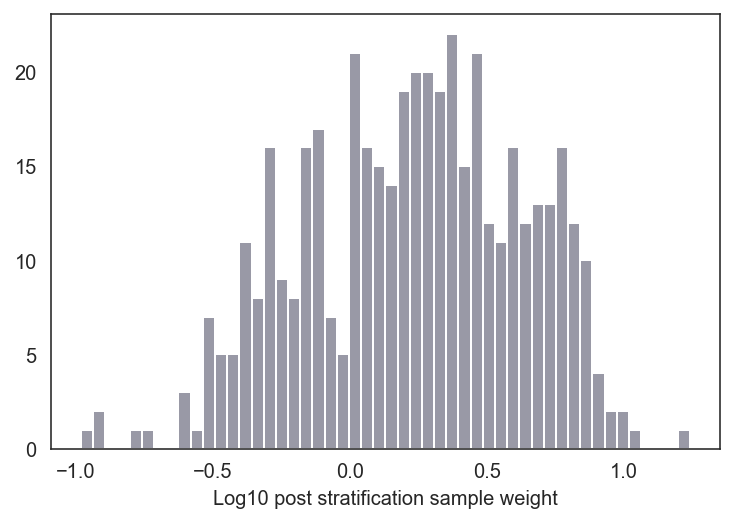

In [88]:
_ = plt.hist(np.log10(np.array(list(post_strata_weights_fast.values()))),bins=50, color=[0.6,0.6,0.65])
plt.xlabel('Log10 post stratification sample weight')

In [89]:
def assign_post_strata_weights_fast(R_data, post_strata_weights):
    # Select relevant columns
    R_data_sele = R_data[['session_id', 'gender']+age_bucket_labels+[u for u,v in race_list_ps]
                         +['race_ethnicity_unknown']+['region']]
    
    join_columns = ['gender',
     '18-29',
     '30-44',
     '45-54',
     '55-64',
     '65-99',
     'race_ethnicity_white',
     'race_ethnicity_hispanic_latino',
     'race_ethnicity_african_american',
     'race_ethnicity_asian',
     'race_ethnicity_other_expanded',
     'race_ethnicity_unknown',
     'region']
    
    # Create mapper dataframe
    df_mapper = pd.DataFrame(columns=join_columns)
    k = 0
    for age in age_bucket_labels:
        for gender, gender_census in [('male', 'Male'), ('female', 'Female')]:        
            for r, r_census in race_list_ps + [('race_ethnicity_unknown','')]:
                for region in regions:
                    df_mapper.loc[k,'gender'] = gender
                    df_mapper.loc[k,age] = 1.0                
                    df_mapper.loc[k,r] = True
                    df_mapper.loc[k,'region'] = region
                    if r == 'race_ethnicity_unknown':
                        df_mapper.loc[k,'post_strata_weights'] = 1.0
                    else:
                        df_mapper.loc[k,'post_strata_weights'] = post_strata_weights[(region,age,gender,r)]
                    #sample_value = ((R_data[age] == 1.0) & R_data[gender] & R_data[r] & 
                    #                (R_data['region'] == region))
                    k += 1

    df_mapper[age_bucket_labels] = df_mapper[age_bucket_labels].fillna(0.0)
    df_mapper[[r for r,r_census in race_list_ps]+['race_ethnicity_unknown']] = df_mapper[[r for r,r_census in race_list_ps]+['race_ethnicity_unknown']].fillna(False)

    # Join to selected data and reasign to original dataset based on the join index
    R_data_sele.loc[:,'id'] = R_data_sele.index.copy()
    join = R_data_sele.merge(df_mapper, on=join_columns)
    join.index = join.id
    join = join.drop(columns=['id'])
    return join['post_strata_weights']


In [92]:
F = assign_post_strata_weights_fast(R_data, post_strata_weights_fast)
R_data.loc[F.index,'post_strata_weights'] = F

In [93]:
post_strata_weights_fast

{('East North Central',
  '18-29',
  'male',
  'race_ethnicity_white'): 2.805259192130504,
 ('East South Central',
  '18-29',
  'male',
  'race_ethnicity_white'): 3.9251666670795924,
 ('Middle Atlantic',
  '18-29',
  'male',
  'race_ethnicity_white'): 2.815495742411062,
 ('Mountain', '18-29', 'male', 'race_ethnicity_white'): 1.9915611589030715,
 ('New England', '18-29', 'male', 'race_ethnicity_white'): 0.659115042525309,
 ('Pacific', '18-29', 'male', 'race_ethnicity_white'): 2.106274807072963,
 ('South Atlantic',
  '18-29',
  'male',
  'race_ethnicity_white'): 3.1523493665256193,
 ('West North Central',
  '18-29',
  'male',
  'race_ethnicity_white'): 3.1178062617562885,
 ('West South Central',
  '18-29',
  'male',
  'race_ethnicity_white'): 3.4979812580124823,
 ('East North Central',
  '18-29',
  'male',
  'race_ethnicity_hispanic_latino'): 3.702851158665559,
 ('East South Central',
  '18-29',
  'male',
  'race_ethnicity_hispanic_latino'): 2.344326812768404,
 ('Middle Atlantic',
  '18-

In [95]:
R_data[['region']+age_bucket_labels+['gender']+['race_ethnicity_white',
     'race_ethnicity_hispanic_latino',
     'race_ethnicity_african_american',
     'race_ethnicity_asian',
     'race_ethnicity_other_expanded',
     'race_ethnicity_unknown',]+['post_strata_weights']].head()

,region,18-29,30-44,45-54,55-64,65-99,gender,race_ethnicity_white,race_ethnicity_hispanic_latino,race_ethnicity_african_american,race_ethnicity_asian,race_ethnicity_other_expanded,race_ethnicity_unknown,post_strata_weights
session_id,,,,,,,,,,,,,,
00618c98-7b5d-4c3e-8256-2bcc20942dc0,New England,0.0,1.0,0.0,0.0,0.0,male,False,False,True,False,False,False,1.178354
01c01b69-52e7-4a5a-b7b6-ce905521f519,East North Central,1.0,0.0,0.0,0.0,0.0,female,False,True,False,False,False,False,0.752157
03dd0493-6ce9-4198-b00e-fb975283bd87,East North Central,1.0,0.0,0.0,0.0,0.0,female,True,False,False,False,False,False,0.320088
04088354-EAB6-4949-A95E-388B0279E627,West North Central,0.0,0.0,0.0,1.0,0.0,female,True,False,False,False,False,False,0.698160
06394CAA-9176-49B6-ADD4-ED4F8781009C,South Atlantic,0.0,1.0,0.0,0.0,0.0,female,True,False,False,False,False,False,0.416465


In [98]:
post_strata_weights_fast[('South Atlantic','30-44','female','race_ethnicity_white',)]

0.41646531862395925

In [283]:
# For regressioin use specific sets of featurese
food_source_lim = ['food_source_convenience_store',
 'food_source_delivery',
 'food_source_food_bank',
 'food_source_other',
 'food_source_restaurant',
 'food_source_supermarket',
 'food_source_no_info'
                  ]

profession_lim = ['prof_healthcare', 'prof_other_essential',]
race_pred = [ 'race_ethnicity_hispanic_latino', 'race_ethnicity_african_american',
 'race_ethnicity_asian',
 'race_ethnicity_multi',
 'race_ethnicity_other_expanded',
 'race_ethnicity_unknown',             
            ]
 #'race_ethnicity_white', # We should use white as baseline
prot = [#'protective_face_mask_lt80', 
        'protective_face_mask_gt50', 
        'protective_face_mask_not_been_outside', 
        ]
contact_interactions = ['contact_0 | popden_150-999',
 'contact_0 | popden_1000+',
 'contact_5+ | popden_150-999',
 'contact_5+ | popden_1000+',
 'contact_isnan | popden_0_149',
 'contact_isnan | popden_150-999',
 'contact_isnan | popden_1000+']

# FOR MODEL
features = (['30-44', '45-54','55-64', '65-99'] + ['female'] + race_pred 
            + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
            + preexisting
            + ['used_to_smoke']# + feeling # + symptoms 
            + duplicate_symptoms_keys_reg
            + household_counts 
            + profession_lim 
            + ['popden_150-999',"popden_1000+"]
            + ['covid_19_symptoms_in_household']
            #+ ['exposed_yes_household',
            #   'exposed_yes_not_household',
            #   'exposed_most_likely',
               #'exposed_no_not_likely',
            #  ]
            + ['sleep_less_than_5', 
               'sleep_5_to_6_hours',
               #'sleep_7_to_8_hours', 
               'sleep_9_to_10_hours', 
               'sleep_11_or_more_hours']
            #+ ['test_rate_0-2',
               #'test_rate_2-2.5',
            #   'test_rate_2.5-3.7',
            #   'test_rate_3.7+']
            #+ ['positive_rate_10-20','positive_rate_20+']
            #+ ['positive_state_rate', 'testrate']
            + ['East North Central',
 'East South Central',
 'Middle Atlantic',
 'Mountain',
 'New England',
 #'Pacific',
 'South Atlantic',
 'West North Central',
 'West South Central']
            #+ ['week 15-16',
              # 'week 17',
              # 'week 18',
              # 'week 19-20']
            
           )   
features = (['30-44', '45-54','55-64', '65-99'] + ['female'] + race_pred 
            + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
            + preexisting
            + ['used_to_smoke']# + feeling # + symptoms 
            + duplicate_symptoms_keys_reg
            #+ ['symptoms_loss_of_taste_and_or_smell']
            + household_counts 
            + profession_lim 
            + ['popden_150-999',"popden_1000+"]
            #+ ['covid_19_symptoms_in_household']
            #+ ['exposed_yes_household',
            #   'exposed_yes_not_household',
            #   'exposed_most_likely',
               #'exposed_no_not_likely',
            #  ]
            + ['sleep_less_than_5', 
               'sleep_5_to_6_hours',
               #'sleep_7_to_8_hours', 
               'sleep_9_to_10_hours', 
               'sleep_11_or_more_hours']
            #+ ['test_rate_0-2',
               #'test_rate_2-2.5',
            #   'test_rate_2.5-3.7',
            #   'test_rate_3.7+']
            #+ ['positive_rate_10-20','positive_rate_20+']
            #+ ['positive_state_rate', 'testrate']
            + ['East North Central',
 'East South Central',
 'Middle Atlantic',
 'Mountain',
 'New England',
 #'Pacific',
 'South Atlantic',
 'West North Central',
 'West South Central']
            #+ ['week 15-16',
              # 'week 17',
              # 'week 18',
              # 'week 19-20']
            
           )

features = list(reversed(features))

X = R_data[features]
X2 = sm.add_constant(X.astype(np.float64))
W = R_data['post_strata_weights']
y = R_data['tested']
print(features)
idx_not_ca_ct = R_data[~R_data['location_admin_level_1'].isin(['CA','CT'])].index

['West South Central', 'West North Central', 'South Atlantic', 'New England', 'Mountain', 'Middle Atlantic', 'East South Central', 'East North Central', 'sleep_11_or_more_hours', 'sleep_9_to_10_hours', 'sleep_5_to_6_hours', 'sleep_less_than_5', 'popden_1000+', 'popden_150-999', 'prof_other_essential', 'prof_healthcare', 'household_members_count_5', 'household_members_count_4', 'household_members_count_3', 'household_members_count_2', 'symptoms_tingling_sensation', 'symptoms_fever', 'symptoms_fatigue', 'symptoms_sore_throat', 'symptoms_runny_nose', 'symptoms_nausea_and_vomiting', 'symptoms_shortness_of_breath', 'symptoms_nasal_congestion', 'symptoms_muscle_and_joint_pain', 'symptoms_tight_feeling_in_chest', 'symptoms_loss_of_appetite', 'symptoms_diarrhea', 'symptoms_loss_of_taste_and_or_smell', 'symptoms_chills_shaking', 'symptoms_cough', 'used_to_smoke', 'preexisting_pregnant', 'preexisting_not_say', 'preexisting_liver_disease', 'preexisting_immunodeficiency', 'preexisting_hypertension

In [284]:
use_post_stratified = False
drop_ca_ct = False
print(R_data['tested'].sum(),R_data['tested'].shape[0])
if use_post_stratified:
    # Unweighted Tested vs Not Tested Regression
    est2 = GLM(R_data['tested'], X2,
          family=families.Binomial(),freq_weights=W).fit()
elif drop_ca_ct:    
    # Unweighted Tested vs Not Tested Regression
    est = sm.Logit(R_data.loc[idx_not_ca_ct,'tested'], X2.loc[idx_not_ca_ct,:])
    est2 = est.fit(method='cg',maxiter=5000)    
else:
    # Unweighted Tested vs Not Tested Regression
    est = sm.Logit(R_data['tested'], X2)
    est2 = est.fit(method='cg',maxiter=5000)
est2.summary()

4759 277151
Optimization terminated successfully.
         Current function value: 0.078359
         Iterations: 47
         Function evaluations: 192
         Gradient evaluations: 192


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 tested   No. Observations:               277151
Model:                          Logit   Df Residuals:                   277087
Method:                           MLE   Df Model:                           63
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:                 0.09741
Time:                        00:47:13   Log-Likelihood:                -21717.
converged:                       True   LL-Null:                       -24061.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -4.8982      0.089    -54.988      0.000      -5.073      -4.724
West South Central                     -0.3472      0.068     -5.113      0.000      -0.480      -0.214
West North Central                     -0.4166      0.079     -5.253      0.000      -0.572      -0.261
South Atlantic                         -0.2836      0.056     -5.042      0.000      -0.394      -0.173
New England                            -0.0589      0.051     -1.148      0.251      -0.159       0.042
Mountain                                0.1325      0.064      2.067      0.039       0.007       0.258
Middle Atlantic                        -0.3028      0.065     -4.690      0.000      -0.429      -0.176
East South Central                      0.1344      0.078      1.725      0.085      -0.018       0.287
East North Central                     -0.2302      0.059     -3.909      0.000      -0.346      -0.115
sleep_11_or_more_hours                  0.2893      0.160      1.807      0.071      -0.024       0.603
sleep_9_to_10_hours                     0.1734      0.069      2.522      0.012       0.039       0.308
sleep_5_to_6_hours                      0.0764      0.047      1.623      0.105      -0.016       0.169
sleep_less_than_5                      -0.1587      0.072     -2.189      0.029      -0.301      -0.017
popden_1000+                            0.3301      0.049      6.791      0.000       0.235       0.425
popden_150-999                          0.0503      0.047      1.075      0.282      -0.041       0.142
prof_other_essential                    0.3327      0.043      7.783      0.000       0.249       0.417
prof_healthcare                         1.0786      0.035     30.733      0.000       1.010       1.147
household_members_count_5              -0.1904      0.059     -3.235      0.001      -0.306      -0.075
household_members_count_4              -0.2800      0.056     -4.981      0.000      -0.390      -0.170
household_members_count_3              -0.1374      0.053     -2.577      0.010      -0.242      -0.033
household_members_count_2              -0.0869      0.047     -1.838      0.066      -0.180       0.006
symptoms_tingling_sensation            -0.4921      0.169     -2.914      0.004      -0.823      -0.161
symptoms_fever                          1.4690      0.101     14.531      0.000       1.271       1.667
symptoms_fatigue                        0.5249      0.062      8.432      0.000       0.403       0.647
symptoms_sore_throat                    0.8636      0.091      9.442      0.000       0.684       1.043
symptoms_runny_nose                    -0.0904      0.069     -1.307      0.191      -0.226       0.045
symptoms_nausea_and_vomiting            0.1142      0.127      0.896      0.370      -0.136       0.364
symptoms_shortness_of_breath            0.6784      0.106      6.416      0.000       0.471       0.886
symptoms_nasal_co

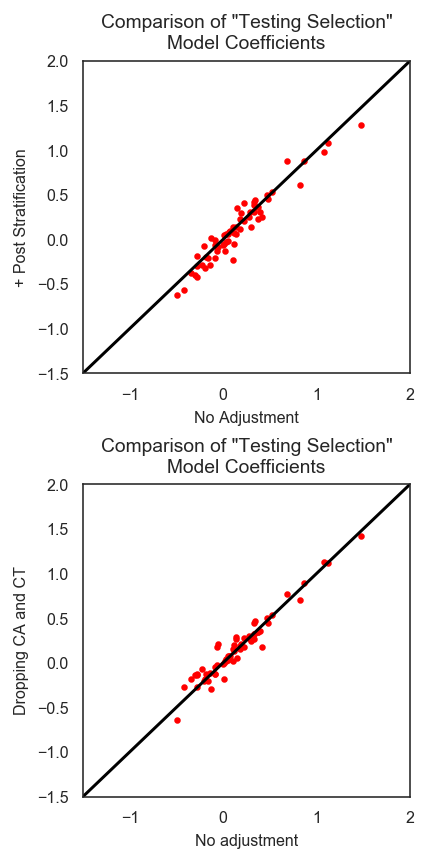

In [140]:
#est2_orig = est2
#est2_ps = est2
#est2_drop_ca_ct = est2

# Compare
plt.figure(figsize=(3,6))
# Ignore constant
plt.subplot(2,1,1)
plt.scatter(x=est2_orig.params.to_numpy()[1::],
            y=est2_ps.params.to_numpy()[1::], color='r',s=5)
plt.plot([-10,10],[-10,10],color='k')
plt.ylabel('+ Post Stratification')
plt.xlabel('No Adjustment')
plt.title('Comparison of "Testing Selection"\nModel Coefficients')
plt.xlim([-1.5,2])
plt.ylim([-1.5,2])
plt.subplot(2,1,2)
plt.scatter(x=est2_orig.params.to_numpy()[1::],
            y=est2_drop_ca_ct.params.to_numpy()[1::], color='r',s=5)
plt.plot([-10,10],[-10,10],color='k')
plt.xlim([-1.5,2])
plt.ylim([-1.5,2])
plt.ylabel('Dropping CA and CT')
plt.xlabel('No adjustment')
plt.title('Comparison of "Testing Selection"\nModel Coefficients')
plt.tight_layout()
plt.show()

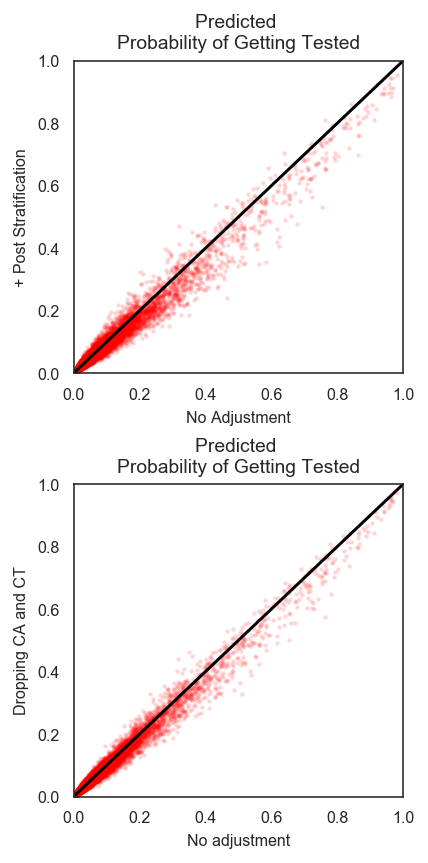

In [144]:
#est2_orig = est2
#est2_ps = est2
#est2_drop_ca_ct = est2

# Compare
plt.figure(figsize=(3,6))
# Ignore constant
plt.subplot(2,1,1)
plt.scatter(x=est2_orig.predict(X2).to_numpy(),
            y=est2_ps.predict(X2).to_numpy(), color='r',alpha=0.1,s=2)
plt.plot([-10,10],[-10,10],color='k')
plt.ylabel('+ Post Stratification')
plt.xlabel('No Adjustment')
plt.title('Predicted \nProbability of Getting Tested')
plt.xlim([0,1])
plt.ylim([0,1])
plt.subplot(2,1,2)
plt.scatter(x=est2_orig.predict(X2).to_numpy(),
            y=est2_drop_ca_ct.predict(X2).to_numpy(), color='r',alpha=0.1,s=2)
plt.plot([-10,10],[-10,10],color='k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Dropping CA and CT')
plt.xlabel('No adjustment')
plt.title('Predicted \nProbability of Getting Tested')
plt.tight_layout()
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


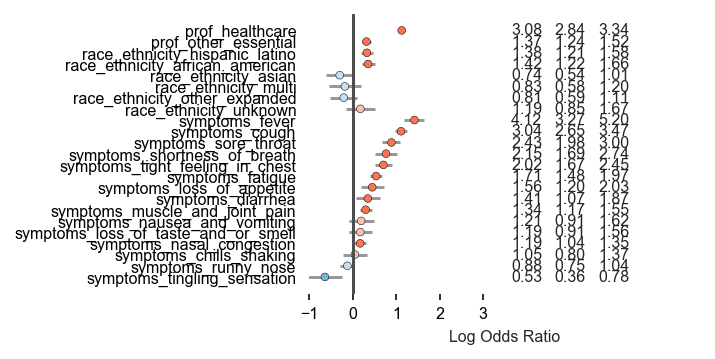

In [120]:
###### import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

plt.figure(figsize=(5,2.5))
matplotlib.rcParams.update({'font.size': 8})

weights = est2.params.to_frame('weights')
weights.rename({'race_ethnicity_hispanic_latino' : 'hispanic/latinx'})
confs = est2.conf_int()
CI = confs.copy()

weights['positive'] = weights['weights'] > 0
#sig = est2.pvalues < 0.05
sig = (CI[0] > 0) | (CI[1] < 0)
weights['sig'] = sig
err_bars = CI[1] - weights['weights']
weights['zipped'] = list(zip(weights.positive, weights.sig))

sorted_symptoms = [duplicate_symptoms_keys_reg[i] for i in np.argsort([-weights['weights'].loc[k] for k in duplicate_symptoms_keys_reg])]
#sorted_preexisting = [preexisting[i] for i in np.argsort([-weights['weights'].loc[k] for k in preexisting])]


#sorted_food_source_lim = [food_source_lim[i] for i in np.argsort([weights['weights'].loc[k] for k in food_source_lim])]


# FORR MODEL
features_to_plot = profession_lim + race_pred + sorted_symptoms 
features_to_plot = list(reversed(features_to_plot))


cmap1 = matplotlib.cm.get_cmap('Blues')
cmap2 = matplotlib.cm.get_cmap('Reds')
#
ax = plt.gca()


ax.errorbar(weights['weights'][features_to_plot], [u for u in weights['weights'][features_to_plot].index], xerr = err_bars[features_to_plot], fmt='none',
            linewidth = 1.5, color = "black", alpha = 0.4, capsize = 0,zorder=0)


ax.scatter(weights['weights'][features_to_plot].values,[u for u in weights['weights'][features_to_plot].index],c=weights['zipped'][features_to_plot].map({(True,True): cmap2(120), 
                                                          (True,False): cmap2(60), 
                                                          (False,True): cmap1(120),
                                                          (False,False): cmap1(60),
                                                         }), s=15, lw=0.25, edgecolor='k')


plt.axvline(0,color=[0.3,0.3,0.3])

ax.tick_params(which='both', length=3, colors='k', reset=True, right=False, left=False, top=False)
ax.set_xlabel("Log Odds Ratio")
# Overall
for key, spine in ax.spines.items():
    spine.set_visible(False)
#ax.tick_params(left = False, bottom=True)

plt.xlim([-1,8])
plt.xticks([-1,0,1,2,3])

y_min, y_max = ax.get_ylim()
ticks = ax.get_yticks()
to_plot = weights['weights'].index
for plot_y,t in zip(ticks,features_to_plot):
    w = np.exp(weights['weights'][t])
    l,r = CI.loc[t,:].values
    l = np.exp(l)
    r = np.exp(r)
    mean = '{0:.2f}'.format(w)
    left = '{0:.2f}'.format(l)
    right = '{0:.2f}'.format(r)
    plt.annotate(xy=(4,plot_y), s=mean,ha='center',va='center')
    plt.annotate(xy=(5,plot_y), s=left, ha='center',va='center')
    plt.annotate(xy=(6,plot_y), s=right, ha='center',va='center')
print(ticks)
plt.tight_layout()
#plt.savefig('COVID_outcome_regression_14_pre_and_post_no_correction_not_well_rel_merged_symptoms_corrected.pdf',dpi=300)

if use_post_stratified:
    plt.savefig('propensity/post_stratified_selection_weights.pdf',dpi=300)
elif drop_ca_ct:
    plt.savefig('propensity/drop_ca_ct_selection_weights.pdf',dpi=300)
else:
    plt.savefig('propensity/selection_weights.pdf',dpi=300)



# Test Outcome

In [124]:
features = (['30-44', '45-54','55-64', '65-99'] + ['female'] + race_pred 
            + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
            + preexisting
            + ['used_to_smoke']# + feeling # + symptoms 
            + duplicate_symptoms_keys_reg
            #+ ['symptoms_loss_of_taste_and_or_smell']
            + household_counts 
            + profession_lim 
            + ['popden_150-999',"popden_1000+"]
            #+ ['covid_19_symptoms_in_household']
            #+ ['exposed_yes_household',
            #   'exposed_yes_not_household',
            #   'exposed_most_likely',
               #'exposed_no_not_likely',
            #  ]
            + ['sleep_less_than_5', 
               'sleep_5_to_6_hours',
               #'sleep_7_to_8_hours', 
               'sleep_9_to_10_hours', 
               'sleep_11_or_more_hours']
            #+ ['test_rate_0-2',
               #'test_rate_2-2.5',
            #   'test_rate_2.5-3.7',
            #   'test_rate_3.7+']
            #+ ['positive_rate_10-20','positive_rate_20+']
            #+ ['positive_state_rate', 'testrate']
            + ['East North Central',
 'East South Central',
 'Middle Atlantic',
 'Mountain',
 'New England',
 #'Pacific',
 'South Atlantic',
 'West North Central',
 'West South Central']            
           )

selection_features = list(reversed(features))

outcome_features = (['30-44', '45-54','55-64', '65-99'] + ['female'] + race_pred 
            + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
            + preexisting
            + ['used_to_smoke']# + feeling # + symptoms 
            + duplicate_symptoms_keys_reg
            + household_counts 
            + profession_lim 
            + ['popden_150-999',"popden_1000+"]
            + ['covid_19_symptoms_in_household']
            + ['exposed_yes_household',
               'exposed_yes_not_household',
               'exposed_most_likely',
               #'exposed_no_not_likely',
              ]
            + ['sleep_less_than_5', 
               'sleep_5_to_6_hours',
               #'sleep_7_to_8_hours', 
               'sleep_9_to_10_hours', 
               'sleep_11_or_more_hours']
            + ['test_rate_0-2',
               #'test_rate_2-2.5',
               'test_rate_2.5-3.7',
               'test_rate_3.7+']
            #+ ['positive_rate_10-20','positive_rate_20+']
            #+ ['positive_state_rate', 'testrate']
            + ['East North Central',
 'East South Central',
 'Middle Atlantic',
 'Mountain',
 'New England',
 #'Pacific',
 'South Atlantic',
 'West North Central',
 'West South Central']
            #+ [#'week 15-16',
            #   'week 17',
            #   'week 18',
            #   'week 19-20']                    
           )



In [122]:
pos_neg_ids = set(list(CovidPos_pre_post.session_id.unique()) + list(CovidNeg_pre_post.session_id.unique()))
R_data_drop_ca_ct = R_data.loc[idx_not_ca_ct,:]
    
def bootstrap_replicate(i, R_data, use_post_stratified):
    print(i)
    R_sample = R_data.sample(R_data.shape[0],replace=True)
    if 'post_strata_weights' in R_sample:
        R_sample = R_sample.drop(columns=['post_strata_weights'])
    R_sample.index = np.array(list(range(R_sample.shape[0])))+999999999999999
    
    if use_post_stratified:
        sample_post_strata_weights = get_post_strata_weights_fast(R_sample)
        F = assign_post_strata_weights_fast(R_sample, sample_post_strata_weights)
        R_sample.loc[F.index,'post_strata_weights'] = F
        
        print('sampling complete')
        X = R_sample[selection_features]
        W = R_sample['post_strata_weights']
        X2 = sm.add_constant(X.astype(np.float64))
        y = R_sample['tested']

        m_selection = GLM(y, X2,
                          family=families.Binomial(),freq_weights=W).fit()   
    else:
        X = R_sample[selection_features]
        X2 = sm.add_constant(X.astype(np.float64))
        y = R_sample['tested']

        print('sampling complete')
        m_selection = sm.Logit(y, X2)
        m_selection = m_selection.fit(method='cg',maxiter=5000)

    R_tested = R_sample[R_sample.session_id.isin(pos_neg_ids)].copy()

    print('POS:')
    print(R_tested['covid_19_swab_test_result_positive'].sum(), R_sample.shape[0])
    prop = m_selection.predict(sm.add_constant(R_tested[selection_features].astype(np.float64)))

    ql = 0.1
    qu = 0.9

    R_tested['IPW_truncated'] = 1 / np.clip(prop,ql,qu)

    X = R_tested[outcome_features]
    X2 = sm.add_constant(X.astype(np.float64))
    y = R_tested['covid_19_swab_test_result_positive']
    W = R_tested['IPW_truncated']

    m_outcome = GLM(y, X2,
              family=families.Binomial(), freq_weights=W).fit()
    weights = m_outcome.params.to_frame('weights')
    return weights

In [551]:
use_post_stratified = False
drop_ca_ct = True

if drop_ca_ct:
    R_analysis = R_data_drop_ca_ct
else:
    R_analysis = R_data
print(R_analysis.shape)
H = pd.DataFrame()
i = H.shape[1]
while i < 2000:
    weights = bootstrap_replicate(i, R_analysis, use_post_stratified)
    H[str(i)] = weights['weights']        
    i += 1

(203643, 384)
0
sampling complete
Optimization terminated successfully.
         Current function value: 0.075803
         Iterations: 46
         Function evaluations: 188
         Gradient evaluations: 188
POS:
208 203643
1
sampling complete
Optimization terminated successfully.
         Current function value: 0.075581
         Iterations: 45
         Function evaluations: 189
         Gradient evaluations: 189
POS:
211 203643
2
sampling complete
Optimization terminated successfully.
         Current function value: 0.075749
         Iterations: 37
         Function evaluations: 152
         Gradient evaluations: 152
POS:
187 203643
3
sampling complete
Optimization terminated successfully.
         Current function value: 0.075626
         Iterations: 58
         Function evaluations: 238
         Gradient evaluations: 238
POS:
215 203643
4
sampling complete
Optimization terminated successfully.
         Current function value: 0.075887
         Iterations: 48
         Function eval

39
sampling complete
Optimization terminated successfully.
         Current function value: 0.075572
         Iterations: 54
         Function evaluations: 217
         Gradient evaluations: 217
POS:
204 203643
40
sampling complete
Optimization terminated successfully.
         Current function value: 0.075072
         Iterations: 51
         Function evaluations: 207
         Gradient evaluations: 207
POS:
209 203643
41
sampling complete
Optimization terminated successfully.
         Current function value: 0.073545
         Iterations: 48
         Function evaluations: 196
         Gradient evaluations: 196
POS:
217 203643
42
sampling complete
Optimization terminated successfully.
         Current function value: 0.075633
         Iterations: 51
         Function evaluations: 213
         Gradient evaluations: 213
POS:
200 203643
43
sampling complete
Optimization terminated successfully.
         Current function value: 0.073842
         Iterations: 52
         Function evaluations: 

78
sampling complete
Optimization terminated successfully.
         Current function value: 0.076165
         Iterations: 48
         Function evaluations: 201
         Gradient evaluations: 201
POS:
202 203643
79
sampling complete
Optimization terminated successfully.
         Current function value: 0.075919
         Iterations: 49
         Function evaluations: 197
         Gradient evaluations: 197
POS:
194 203643
80
sampling complete
Optimization terminated successfully.
         Current function value: 0.073759
         Iterations: 51
         Function evaluations: 210
         Gradient evaluations: 210
POS:
200 203643
81
sampling complete
Optimization terminated successfully.
         Current function value: 0.074798
         Iterations: 58
         Function evaluations: 238
         Gradient evaluations: 238
POS:
225 203643
82
sampling complete
Optimization terminated successfully.
         Current function value: 0.073875
         Iterations: 49
         Function evaluations: 

POS:
193 203643
117
sampling complete
Optimization terminated successfully.
         Current function value: 0.078101
         Iterations: 46
         Function evaluations: 189
         Gradient evaluations: 189
POS:
221 203643
118
sampling complete
Optimization terminated successfully.
         Current function value: 0.073618
         Iterations: 51
         Function evaluations: 209
         Gradient evaluations: 209
POS:
216 203643
119
sampling complete
Optimization terminated successfully.
         Current function value: 0.075467
         Iterations: 51
         Function evaluations: 205
         Gradient evaluations: 205
POS:
192 203643
120
sampling complete
Optimization terminated successfully.
         Current function value: 0.077453
         Iterations: 50
         Function evaluations: 209
         Gradient evaluations: 209
POS:
191 203643
121
sampling complete
Optimization terminated successfully.
         Current function value: 0.075524
         Iterations: 50
         F

156
sampling complete
Optimization terminated successfully.
         Current function value: 0.076470
         Iterations: 52
         Function evaluations: 214
         Gradient evaluations: 214
POS:
210 203643
157
sampling complete
Optimization terminated successfully.
         Current function value: 0.075938
         Iterations: 52
         Function evaluations: 213
         Gradient evaluations: 213
POS:
190 203643
158
sampling complete
Optimization terminated successfully.
         Current function value: 0.074088
         Iterations: 49
         Function evaluations: 200
         Gradient evaluations: 200
POS:
193 203643
159
sampling complete
Optimization terminated successfully.
         Current function value: 0.074105
         Iterations: 52
         Function evaluations: 212
         Gradient evaluations: 212
POS:
199 203643
160
sampling complete
Optimization terminated successfully.
         Current function value: 0.075956
         Iterations: 49
         Function evaluati

195
sampling complete
Optimization terminated successfully.
         Current function value: 0.076915
         Iterations: 51
         Function evaluations: 214
         Gradient evaluations: 214
POS:
207 203643
196
sampling complete
Optimization terminated successfully.
         Current function value: 0.073679
         Iterations: 54
         Function evaluations: 223
         Gradient evaluations: 223
POS:
225 203643
197
sampling complete
Optimization terminated successfully.
         Current function value: 0.074242
         Iterations: 62
         Function evaluations: 260
         Gradient evaluations: 260
POS:
215 203643
198
sampling complete
Optimization terminated successfully.
         Current function value: 0.074439
         Iterations: 59
         Function evaluations: 239
         Gradient evaluations: 239
POS:
204 203643
199
sampling complete
Optimization terminated successfully.
         Current function value: 0.075892
         Iterations: 45
         Function evaluati

234
sampling complete
Optimization terminated successfully.
         Current function value: 0.073849
         Iterations: 47
         Function evaluations: 195
         Gradient evaluations: 195
POS:
201 203643
235
sampling complete
Optimization terminated successfully.
         Current function value: 0.074375
         Iterations: 46
         Function evaluations: 195
         Gradient evaluations: 195
POS:
192 203643
236
sampling complete
Optimization terminated successfully.
         Current function value: 0.074002
         Iterations: 51
         Function evaluations: 212
         Gradient evaluations: 212
POS:
194 203643
237
sampling complete
Optimization terminated successfully.
         Current function value: 0.073875
         Iterations: 46
         Function evaluations: 192
         Gradient evaluations: 192
POS:
184 203643
238
sampling complete
Optimization terminated successfully.
         Current function value: 0.076022
         Iterations: 50
         Function evaluati

273
sampling complete
Optimization terminated successfully.
         Current function value: 0.073938
         Iterations: 47
         Function evaluations: 188
         Gradient evaluations: 188
POS:
186 203643
274
sampling complete
Optimization terminated successfully.
         Current function value: 0.075358
         Iterations: 48
         Function evaluations: 195
         Gradient evaluations: 195
POS:
206 203643
275
sampling complete
Optimization terminated successfully.
         Current function value: 0.076135
         Iterations: 50
         Function evaluations: 203
         Gradient evaluations: 203
POS:
183 203643
276
sampling complete
Optimization terminated successfully.
         Current function value: 0.076533
         Iterations: 47
         Function evaluations: 193
         Gradient evaluations: 193
POS:
214 203643
277
sampling complete
Optimization terminated successfully.
         Current function value: 0.076229
         Iterations: 47
         Function evaluati

312
sampling complete
Optimization terminated successfully.
         Current function value: 0.074205
         Iterations: 54
         Function evaluations: 222
         Gradient evaluations: 222
POS:
192 203643
313
sampling complete
Optimization terminated successfully.
         Current function value: 0.076163
         Iterations: 46
         Function evaluations: 188
         Gradient evaluations: 188
POS:
186 203643
314
sampling complete
Optimization terminated successfully.
         Current function value: 0.076102
         Iterations: 45
         Function evaluations: 183
         Gradient evaluations: 183
POS:
210 203643
315
sampling complete
Optimization terminated successfully.
         Current function value: 0.077517
         Iterations: 50
         Function evaluations: 202
         Gradient evaluations: 202
POS:
241 203643
316
sampling complete
Optimization terminated successfully.
         Current function value: 0.074024
         Iterations: 54
         Function evaluati

351
sampling complete
Optimization terminated successfully.
         Current function value: 0.075865
         Iterations: 56
         Function evaluations: 230
         Gradient evaluations: 230
POS:
198 203643
352
sampling complete
Optimization terminated successfully.
         Current function value: 0.074174
         Iterations: 45
         Function evaluations: 187
         Gradient evaluations: 187
POS:
195 203643
353
sampling complete
Optimization terminated successfully.
         Current function value: 0.075944
         Iterations: 54
         Function evaluations: 221
         Gradient evaluations: 221
POS:
182 203643
354
sampling complete
Optimization terminated successfully.
         Current function value: 0.075884
         Iterations: 46
         Function evaluations: 187
         Gradient evaluations: 187
POS:
214 203643
355
sampling complete
Optimization terminated successfully.
         Current function value: 0.075183
         Iterations: 46
         Function evaluati

390
sampling complete
Optimization terminated successfully.
         Current function value: 0.075889
         Iterations: 40
         Function evaluations: 163
         Gradient evaluations: 163
POS:
195 203643
391
sampling complete
Optimization terminated successfully.
         Current function value: 0.076844
         Iterations: 52
         Function evaluations: 216
         Gradient evaluations: 216
POS:
172 203643
392
sampling complete
Optimization terminated successfully.
         Current function value: 0.076729
         Iterations: 49
         Function evaluations: 202
         Gradient evaluations: 202
POS:
208 203643
393
sampling complete
Optimization terminated successfully.
         Current function value: 0.076120
         Iterations: 43
         Function evaluations: 177
         Gradient evaluations: 177
POS:
200 203643
394
sampling complete
Optimization terminated successfully.
         Current function value: 0.075343
         Iterations: 58
         Function evaluati

429
sampling complete
Optimization terminated successfully.
         Current function value: 0.074998
         Iterations: 54
         Function evaluations: 222
         Gradient evaluations: 222
POS:
218 203643
430
sampling complete
Optimization terminated successfully.
         Current function value: 0.076865
         Iterations: 53
         Function evaluations: 214
         Gradient evaluations: 214
POS:
184 203643
431
sampling complete
Optimization terminated successfully.
         Current function value: 0.075680
         Iterations: 47
         Function evaluations: 197
         Gradient evaluations: 197
POS:
229 203643
432
sampling complete
Optimization terminated successfully.
         Current function value: 0.074199
         Iterations: 38
         Function evaluations: 157
         Gradient evaluations: 157
POS:
226 203643
433
sampling complete
Optimization terminated successfully.
         Current function value: 0.076459
         Iterations: 51
         Function evaluati

468
sampling complete
Optimization terminated successfully.
         Current function value: 0.077698
         Iterations: 44
         Function evaluations: 183
         Gradient evaluations: 183
POS:
237 203643
469
sampling complete
Optimization terminated successfully.
         Current function value: 0.076855
         Iterations: 45
         Function evaluations: 184
         Gradient evaluations: 184
POS:
206 203643
470
sampling complete
Optimization terminated successfully.
         Current function value: 0.075722
         Iterations: 41
         Function evaluations: 172
         Gradient evaluations: 172
POS:
236 203643
471
sampling complete
Optimization terminated successfully.
         Current function value: 0.074860
         Iterations: 47
         Function evaluations: 190
         Gradient evaluations: 190
POS:
221 203643
472
sampling complete
Optimization terminated successfully.
         Current function value: 0.073574
         Iterations: 59
         Function evaluati

507
sampling complete
Optimization terminated successfully.
         Current function value: 0.075657
         Iterations: 49
         Function evaluations: 202
         Gradient evaluations: 202
POS:
200 203643
508
sampling complete
Optimization terminated successfully.
         Current function value: 0.076731
         Iterations: 48
         Function evaluations: 198
         Gradient evaluations: 198
POS:
191 203643
509
sampling complete
Optimization terminated successfully.
         Current function value: 0.073183
         Iterations: 49
         Function evaluations: 204
         Gradient evaluations: 204
POS:
166 203643
510
sampling complete
Optimization terminated successfully.
         Current function value: 0.076054
         Iterations: 48
         Function evaluations: 199
         Gradient evaluations: 199
POS:
199 203643
511
sampling complete
Optimization terminated successfully.
         Current function value: 0.074661
         Iterations: 47
         Function evaluati

546
sampling complete
Optimization terminated successfully.
         Current function value: 0.073466
         Iterations: 50
         Function evaluations: 209
         Gradient evaluations: 209
POS:
176 203643
547
sampling complete
Optimization terminated successfully.
         Current function value: 0.074133
         Iterations: 47
         Function evaluations: 196
         Gradient evaluations: 196
POS:
201 203643
548
sampling complete
Optimization terminated successfully.
         Current function value: 0.075065
         Iterations: 53
         Function evaluations: 217
         Gradient evaluations: 217
POS:
197 203643
549
sampling complete
Optimization terminated successfully.
         Current function value: 0.077274
         Iterations: 44
         Function evaluations: 181
         Gradient evaluations: 181
POS:
196 203643
550
sampling complete
Optimization terminated successfully.
         Current function value: 0.076064
         Iterations: 56
         Function evaluati

585
sampling complete
Optimization terminated successfully.
         Current function value: 0.073537
         Iterations: 50
         Function evaluations: 206
         Gradient evaluations: 206
POS:
208 203643
586
sampling complete
Optimization terminated successfully.
         Current function value: 0.076686
         Iterations: 60
         Function evaluations: 248
         Gradient evaluations: 248
POS:
209 203643
587
sampling complete
Optimization terminated successfully.
         Current function value: 0.075958
         Iterations: 46
         Function evaluations: 191
         Gradient evaluations: 191
POS:
222 203643
588
sampling complete
Optimization terminated successfully.
         Current function value: 0.076662
         Iterations: 57
         Function evaluations: 238
         Gradient evaluations: 238
POS:
224 203643
589
sampling complete
Optimization terminated successfully.
         Current function value: 0.076330
         Iterations: 51
         Function evaluati

624
sampling complete
Optimization terminated successfully.
         Current function value: 0.073712
         Iterations: 49
         Function evaluations: 206
         Gradient evaluations: 206
POS:
187 203643
625
sampling complete
Optimization terminated successfully.
         Current function value: 0.075006
         Iterations: 49
         Function evaluations: 200
         Gradient evaluations: 200
POS:
235 203643
626
sampling complete
Optimization terminated successfully.
         Current function value: 0.074161
         Iterations: 42
         Function evaluations: 174
         Gradient evaluations: 174
POS:
211 203643
627
sampling complete
Optimization terminated successfully.
         Current function value: 0.074885
         Iterations: 48
         Function evaluations: 195
         Gradient evaluations: 195
POS:
203 203643
628
sampling complete
Optimization terminated successfully.
         Current function value: 0.073524
         Iterations: 49
         Function evaluati

663
sampling complete
Optimization terminated successfully.
         Current function value: 0.076016
         Iterations: 51
         Function evaluations: 205
         Gradient evaluations: 205
POS:
212 203643
664
sampling complete
Optimization terminated successfully.
         Current function value: 0.074245
         Iterations: 48
         Function evaluations: 200
         Gradient evaluations: 200
POS:
179 203643
665
sampling complete
Optimization terminated successfully.
         Current function value: 0.074529
         Iterations: 37
         Function evaluations: 152
         Gradient evaluations: 152
POS:
204 203643
666
sampling complete
Optimization terminated successfully.
         Current function value: 0.075853
         Iterations: 57
         Function evaluations: 232
         Gradient evaluations: 232
POS:
201 203643
667
sampling complete
Optimization terminated successfully.
         Current function value: 0.076960
         Iterations: 56
         Function evaluati

702
sampling complete
Optimization terminated successfully.
         Current function value: 0.075625
         Iterations: 57
         Function evaluations: 234
         Gradient evaluations: 234
POS:
225 203643
703
sampling complete
Optimization terminated successfully.
         Current function value: 0.076223
         Iterations: 47
         Function evaluations: 198
         Gradient evaluations: 198
POS:
197 203643
704
sampling complete
Optimization terminated successfully.
         Current function value: 0.073954
         Iterations: 53
         Function evaluations: 221
         Gradient evaluations: 221
POS:
208 203643
705
sampling complete
Optimization terminated successfully.
         Current function value: 0.074035
         Iterations: 45
         Function evaluations: 183
         Gradient evaluations: 183
POS:
244 203643
706
sampling complete
Optimization terminated successfully.
         Current function value: 0.075428
         Iterations: 60
         Function evaluati

741
sampling complete
Optimization terminated successfully.
         Current function value: 0.076634
         Iterations: 39
         Function evaluations: 161
         Gradient evaluations: 161
POS:
231 203643
742
sampling complete
Optimization terminated successfully.
         Current function value: 0.074014
         Iterations: 50
         Function evaluations: 204
         Gradient evaluations: 204
POS:
214 203643
743
sampling complete
Optimization terminated successfully.
         Current function value: 0.075947
         Iterations: 51
         Function evaluations: 212
         Gradient evaluations: 212
POS:
204 203643
744
sampling complete
Optimization terminated successfully.
         Current function value: 0.073979
         Iterations: 48
         Function evaluations: 197
         Gradient evaluations: 197
POS:
188 203643
745
sampling complete
Optimization terminated successfully.
         Current function value: 0.074887
         Iterations: 51
         Function evaluati

780
sampling complete
Optimization terminated successfully.
         Current function value: 0.075510
         Iterations: 47
         Function evaluations: 198
         Gradient evaluations: 198
POS:
189 203643
781
sampling complete
Optimization terminated successfully.
         Current function value: 0.075724
         Iterations: 46
         Function evaluations: 190
         Gradient evaluations: 190
POS:
185 203643
782
sampling complete
Optimization terminated successfully.
         Current function value: 0.076809
         Iterations: 40
         Function evaluations: 168
         Gradient evaluations: 168
POS:
181 203643
783
sampling complete
Optimization terminated successfully.
         Current function value: 0.073233
         Iterations: 59
         Function evaluations: 247
         Gradient evaluations: 247
POS:
219 203643
784
sampling complete
Optimization terminated successfully.
         Current function value: 0.074440
         Iterations: 56
         Function evaluati

819
sampling complete
Optimization terminated successfully.
         Current function value: 0.073961
         Iterations: 45
         Function evaluations: 188
         Gradient evaluations: 188
POS:
157 203643
820
sampling complete
Optimization terminated successfully.
         Current function value: 0.074021
         Iterations: 44
         Function evaluations: 187
         Gradient evaluations: 187
POS:
178 203643
821
sampling complete
Optimization terminated successfully.
         Current function value: 0.077401
         Iterations: 41
         Function evaluations: 168
         Gradient evaluations: 168
POS:
207 203643
822
sampling complete
Optimization terminated successfully.
         Current function value: 0.073288
         Iterations: 43
         Function evaluations: 178
         Gradient evaluations: 178
POS:
185 203643
823
sampling complete
Optimization terminated successfully.
         Current function value: 0.074640
         Iterations: 46
         Function evaluati

858
sampling complete
Optimization terminated successfully.
         Current function value: 0.075593
         Iterations: 51
         Function evaluations: 209
         Gradient evaluations: 209
POS:
215 203643
859
sampling complete
Optimization terminated successfully.
         Current function value: 0.075648
         Iterations: 49
         Function evaluations: 199
         Gradient evaluations: 199
POS:
183 203643
860
sampling complete
Optimization terminated successfully.
         Current function value: 0.074166
         Iterations: 47
         Function evaluations: 195
         Gradient evaluations: 195
POS:
202 203643
861
sampling complete
Optimization terminated successfully.
         Current function value: 0.076221
         Iterations: 55
         Function evaluations: 230
         Gradient evaluations: 230
POS:
207 203643
862
sampling complete
Optimization terminated successfully.
         Current function value: 0.074139
         Iterations: 50
         Function evaluati

897
sampling complete
Optimization terminated successfully.
         Current function value: 0.074085
         Iterations: 54
         Function evaluations: 225
         Gradient evaluations: 225
POS:
207 203643
898
sampling complete
Optimization terminated successfully.
         Current function value: 0.073773
         Iterations: 55
         Function evaluations: 225
         Gradient evaluations: 225
POS:
196 203643
899
sampling complete
Optimization terminated successfully.
         Current function value: 0.075542
         Iterations: 46
         Function evaluations: 187
         Gradient evaluations: 187
POS:
214 203643
900
sampling complete
Optimization terminated successfully.
         Current function value: 0.075376
         Iterations: 63
         Function evaluations: 260
         Gradient evaluations: 260
POS:
208 203643
901
sampling complete
Optimization terminated successfully.
         Current function value: 0.075728
         Iterations: 45
         Function evaluati

936
sampling complete
Optimization terminated successfully.
         Current function value: 0.076611
         Iterations: 46
         Function evaluations: 188
         Gradient evaluations: 188
POS:
209 203643
937
sampling complete
Optimization terminated successfully.
         Current function value: 0.074226
         Iterations: 58
         Function evaluations: 243
         Gradient evaluations: 243
POS:
190 203643
938
sampling complete
Optimization terminated successfully.
         Current function value: 0.076937
         Iterations: 54
         Function evaluations: 225
         Gradient evaluations: 225
POS:
202 203643
939
sampling complete
Optimization terminated successfully.
         Current function value: 0.074312
         Iterations: 54
         Function evaluations: 222
         Gradient evaluations: 222
POS:
189 203643
940
sampling complete
Optimization terminated successfully.
         Current function value: 0.074705
         Iterations: 50
         Function evaluati

975
sampling complete
Optimization terminated successfully.
         Current function value: 0.075482
         Iterations: 55
         Function evaluations: 222
         Gradient evaluations: 222
POS:
204 203643
976
sampling complete
Optimization terminated successfully.
         Current function value: 0.074896
         Iterations: 51
         Function evaluations: 209
         Gradient evaluations: 209
POS:
193 203643
977
sampling complete
Optimization terminated successfully.
         Current function value: 0.073992
         Iterations: 52
         Function evaluations: 212
         Gradient evaluations: 212
POS:
226 203643
978
sampling complete
Optimization terminated successfully.
         Current function value: 0.075251
         Iterations: 51
         Function evaluations: 206
         Gradient evaluations: 206
POS:
194 203643
979
sampling complete
Optimization terminated successfully.
         Current function value: 0.076279
         Iterations: 44
         Function evaluati

1014
sampling complete
Optimization terminated successfully.
         Current function value: 0.075243
         Iterations: 48
         Function evaluations: 198
         Gradient evaluations: 198
POS:
212 203643
1015
sampling complete
Optimization terminated successfully.
         Current function value: 0.074053
         Iterations: 49
         Function evaluations: 204
         Gradient evaluations: 204
POS:
178 203643
1016
sampling complete
Optimization terminated successfully.
         Current function value: 0.074076
         Iterations: 49
         Function evaluations: 200
         Gradient evaluations: 200
POS:
211 203643
1017
sampling complete
Optimization terminated successfully.
         Current function value: 0.075713
         Iterations: 39
         Function evaluations: 162
         Gradient evaluations: 162
POS:
176 203643
1018
sampling complete
Optimization terminated successfully.
         Current function value: 0.076235
         Iterations: 54
         Function eva

1053
sampling complete
Optimization terminated successfully.
         Current function value: 0.074343
         Iterations: 52
         Function evaluations: 217
         Gradient evaluations: 217
POS:
185 203643
1054
sampling complete
Optimization terminated successfully.
         Current function value: 0.073660
         Iterations: 40
         Function evaluations: 170
         Gradient evaluations: 170
POS:
185 203643
1055
sampling complete
Optimization terminated successfully.
         Current function value: 0.074687
         Iterations: 49
         Function evaluations: 202
         Gradient evaluations: 202
POS:
203 203643
1056
sampling complete
Optimization terminated successfully.
         Current function value: 0.074991
         Iterations: 52
         Function evaluations: 217
         Gradient evaluations: 217
POS:
197 203643
1057
sampling complete
Optimization terminated successfully.
         Current function value: 0.078010
         Iterations: 46
         Function eva

1092
sampling complete
Optimization terminated successfully.
         Current function value: 0.074893
         Iterations: 55
         Function evaluations: 225
         Gradient evaluations: 225
POS:
207 203643
1093
sampling complete
Optimization terminated successfully.
         Current function value: 0.076219
         Iterations: 63
         Function evaluations: 253
         Gradient evaluations: 253
POS:
217 203643
1094
sampling complete
Optimization terminated successfully.
         Current function value: 0.075407
         Iterations: 51
         Function evaluations: 209
         Gradient evaluations: 209
POS:
202 203643
1095
sampling complete
Optimization terminated successfully.
         Current function value: 0.076439
         Iterations: 47
         Function evaluations: 193
         Gradient evaluations: 193
POS:
188 203643
1096
sampling complete
Optimization terminated successfully.
         Current function value: 0.074209
         Iterations: 44
         Function eva

1131
sampling complete
Optimization terminated successfully.
         Current function value: 0.075628
         Iterations: 52
         Function evaluations: 214
         Gradient evaluations: 214
POS:
212 203643
1132
sampling complete
Optimization terminated successfully.
         Current function value: 0.074924
         Iterations: 47
         Function evaluations: 193
         Gradient evaluations: 193
POS:
201 203643
1133
sampling complete
Optimization terminated successfully.
         Current function value: 0.075646
         Iterations: 47
         Function evaluations: 197
         Gradient evaluations: 197
POS:
206 203643
1134
sampling complete
Optimization terminated successfully.
         Current function value: 0.074064
         Iterations: 54
         Function evaluations: 228
         Gradient evaluations: 228
POS:
204 203643
1135
sampling complete
Optimization terminated successfully.
         Current function value: 0.074169
         Iterations: 44
         Function eva

1170
sampling complete
Optimization terminated successfully.
         Current function value: 0.075751
         Iterations: 52
         Function evaluations: 208
         Gradient evaluations: 208
POS:
213 203643
1171
sampling complete
Optimization terminated successfully.
         Current function value: 0.074651
         Iterations: 49
         Function evaluations: 204
         Gradient evaluations: 204
POS:
208 203643
1172
sampling complete
Optimization terminated successfully.
         Current function value: 0.075901
         Iterations: 46
         Function evaluations: 188
         Gradient evaluations: 188
POS:
200 203643
1173
sampling complete
Optimization terminated successfully.
         Current function value: 0.073763
         Iterations: 46
         Function evaluations: 190
         Gradient evaluations: 190
POS:
202 203643
1174
sampling complete
Optimization terminated successfully.
         Current function value: 0.073451
         Iterations: 48
         Function eva

1209
sampling complete
Optimization terminated successfully.
         Current function value: 0.076562
         Iterations: 56
         Function evaluations: 227
         Gradient evaluations: 227
POS:
223 203643
1210
sampling complete
Optimization terminated successfully.
         Current function value: 0.074745
         Iterations: 49
         Function evaluations: 204
         Gradient evaluations: 204
POS:
201 203643
1211
sampling complete
Optimization terminated successfully.
         Current function value: 0.075486
         Iterations: 45
         Function evaluations: 189
         Gradient evaluations: 189
POS:
216 203643
1212
sampling complete
Optimization terminated successfully.
         Current function value: 0.075000
         Iterations: 50
         Function evaluations: 204
         Gradient evaluations: 204
POS:
188 203643
1213
sampling complete
Optimization terminated successfully.
         Current function value: 0.074552
         Iterations: 52
         Function eva

1248
sampling complete
Optimization terminated successfully.
         Current function value: 0.073223
         Iterations: 50
         Function evaluations: 205
         Gradient evaluations: 205
POS:
209 203643
1249
sampling complete
Optimization terminated successfully.
         Current function value: 0.075335
         Iterations: 41
         Function evaluations: 169
         Gradient evaluations: 169
POS:
193 203643
1250
sampling complete
Optimization terminated successfully.
         Current function value: 0.073990
         Iterations: 58
         Function evaluations: 240
         Gradient evaluations: 240
POS:
163 203643
1251
sampling complete
Optimization terminated successfully.
         Current function value: 0.074424
         Iterations: 45
         Function evaluations: 182
         Gradient evaluations: 182
POS:
205 203643
1252
sampling complete
Optimization terminated successfully.
         Current function value: 0.075300
         Iterations: 52
         Function eva

1287
sampling complete
Optimization terminated successfully.
         Current function value: 0.077100
         Iterations: 48
         Function evaluations: 201
         Gradient evaluations: 201
POS:
239 203643
1288
sampling complete
Optimization terminated successfully.
         Current function value: 0.075264
         Iterations: 51
         Function evaluations: 212
         Gradient evaluations: 212
POS:
234 203643
1289
sampling complete
Optimization terminated successfully.
         Current function value: 0.074363
         Iterations: 49
         Function evaluations: 199
         Gradient evaluations: 199
POS:
210 203643
1290
sampling complete
Optimization terminated successfully.
         Current function value: 0.074741
         Iterations: 49
         Function evaluations: 201
         Gradient evaluations: 201
POS:
209 203643
1291
sampling complete
Optimization terminated successfully.
         Current function value: 0.076056
         Iterations: 39
         Function eva

1326
sampling complete
Optimization terminated successfully.
         Current function value: 0.076941
         Iterations: 55
         Function evaluations: 231
         Gradient evaluations: 231
POS:
196 203643
1327
sampling complete
Optimization terminated successfully.
         Current function value: 0.075433
         Iterations: 54
         Function evaluations: 223
         Gradient evaluations: 223
POS:
183 203643
1328
sampling complete
Optimization terminated successfully.
         Current function value: 0.076350
         Iterations: 49
         Function evaluations: 201
         Gradient evaluations: 201
POS:
203 203643
1329
sampling complete
Optimization terminated successfully.
         Current function value: 0.075701
         Iterations: 55
         Function evaluations: 230
         Gradient evaluations: 230
POS:
197 203643
1330
sampling complete
Optimization terminated successfully.
         Current function value: 0.074615
         Iterations: 47
         Function eva

1365
sampling complete
Optimization terminated successfully.
         Current function value: 0.075068
         Iterations: 43
         Function evaluations: 174
         Gradient evaluations: 174
POS:
185 203643
1366
sampling complete
Optimization terminated successfully.
         Current function value: 0.075499
         Iterations: 52
         Function evaluations: 213
         Gradient evaluations: 213
POS:
207 203643
1367
sampling complete
Optimization terminated successfully.
         Current function value: 0.075992
         Iterations: 55
         Function evaluations: 229
         Gradient evaluations: 229
POS:
201 203643
1368
sampling complete
Optimization terminated successfully.
         Current function value: 0.077363
         Iterations: 49
         Function evaluations: 203
         Gradient evaluations: 203
POS:
212 203643
1369
sampling complete
Optimization terminated successfully.
         Current function value: 0.075392
         Iterations: 62
         Function eva

1404
sampling complete
Optimization terminated successfully.
         Current function value: 0.076583
         Iterations: 57
         Function evaluations: 238
         Gradient evaluations: 238
POS:
197 203643
1405
sampling complete
Optimization terminated successfully.
         Current function value: 0.074523
         Iterations: 48
         Function evaluations: 201
         Gradient evaluations: 201
POS:
200 203643
1406
sampling complete
Optimization terminated successfully.
         Current function value: 0.073993
         Iterations: 57
         Function evaluations: 231
         Gradient evaluations: 231
POS:
216 203643
1407
sampling complete
Optimization terminated successfully.
         Current function value: 0.074088
         Iterations: 51
         Function evaluations: 214
         Gradient evaluations: 214
POS:
198 203643
1408
sampling complete
Optimization terminated successfully.
         Current function value: 0.077704
         Iterations: 48
         Function eva

1443
sampling complete
Optimization terminated successfully.
         Current function value: 0.075819
         Iterations: 58
         Function evaluations: 238
         Gradient evaluations: 238
POS:
206 203643
1444
sampling complete
Optimization terminated successfully.
         Current function value: 0.074367
         Iterations: 50
         Function evaluations: 204
         Gradient evaluations: 204
POS:
193 203643
1445
sampling complete
Optimization terminated successfully.
         Current function value: 0.076343
         Iterations: 52
         Function evaluations: 213
         Gradient evaluations: 213
POS:
208 203643
1446
sampling complete
Optimization terminated successfully.
         Current function value: 0.076202
         Iterations: 58
         Function evaluations: 236
         Gradient evaluations: 236
POS:
192 203643
1447
sampling complete
Optimization terminated successfully.
         Current function value: 0.074571
         Iterations: 39
         Function eva

1482
sampling complete
Optimization terminated successfully.
         Current function value: 0.075861
         Iterations: 49
         Function evaluations: 204
         Gradient evaluations: 204
POS:
198 203643
1483
sampling complete
Optimization terminated successfully.
         Current function value: 0.075531
         Iterations: 49
         Function evaluations: 204
         Gradient evaluations: 204
POS:
203 203643
1484
sampling complete
Optimization terminated successfully.
         Current function value: 0.076513
         Iterations: 58
         Function evaluations: 239
         Gradient evaluations: 239
POS:
199 203643
1485
sampling complete
Optimization terminated successfully.
         Current function value: 0.075122
         Iterations: 52
         Function evaluations: 216
         Gradient evaluations: 216
POS:
205 203643
1486
sampling complete
Optimization terminated successfully.
         Current function value: 0.074333
         Iterations: 48
         Function eva

1521
sampling complete
Optimization terminated successfully.
         Current function value: 0.075021
         Iterations: 48
         Function evaluations: 200
         Gradient evaluations: 200
POS:
225 203643
1522
sampling complete
Optimization terminated successfully.
         Current function value: 0.075323
         Iterations: 48
         Function evaluations: 195
         Gradient evaluations: 195
POS:
208 203643
1523
sampling complete
Optimization terminated successfully.
         Current function value: 0.074764
         Iterations: 51
         Function evaluations: 204
         Gradient evaluations: 204
POS:
202 203643
1524
sampling complete
Optimization terminated successfully.
         Current function value: 0.074533
         Iterations: 47
         Function evaluations: 191
         Gradient evaluations: 191
POS:
190 203643
1525
sampling complete
Optimization terminated successfully.
         Current function value: 0.074232
         Iterations: 63
         Function eva

1560
sampling complete
Optimization terminated successfully.
         Current function value: 0.076675
         Iterations: 51
         Function evaluations: 213
         Gradient evaluations: 213
POS:
218 203643
1561
sampling complete
Optimization terminated successfully.
         Current function value: 0.076789
         Iterations: 52
         Function evaluations: 218
         Gradient evaluations: 218
POS:
192 203643
1562
sampling complete
Optimization terminated successfully.
         Current function value: 0.075836
         Iterations: 54
         Function evaluations: 222
         Gradient evaluations: 222
POS:
204 203643
1563
sampling complete
Optimization terminated successfully.
         Current function value: 0.074099
         Iterations: 45
         Function evaluations: 189
         Gradient evaluations: 189
POS:
202 203643
1564
sampling complete
Optimization terminated successfully.
         Current function value: 0.075241
         Iterations: 51
         Function eva

1599
sampling complete
Optimization terminated successfully.
         Current function value: 0.076445
         Iterations: 50
         Function evaluations: 206
         Gradient evaluations: 206
POS:
192 203643
1600
sampling complete
Optimization terminated successfully.
         Current function value: 0.076613
         Iterations: 46
         Function evaluations: 183
         Gradient evaluations: 183
POS:
222 203643
1601
sampling complete
Optimization terminated successfully.
         Current function value: 0.076059
         Iterations: 51
         Function evaluations: 210
         Gradient evaluations: 210
POS:
193 203643
1602
sampling complete
Optimization terminated successfully.
         Current function value: 0.076640
         Iterations: 46
         Function evaluations: 190
         Gradient evaluations: 190
POS:
218 203643
1603
sampling complete
Optimization terminated successfully.
         Current function value: 0.075187
         Iterations: 55
         Function eva

1638
sampling complete
Optimization terminated successfully.
         Current function value: 0.074194
         Iterations: 47
         Function evaluations: 197
         Gradient evaluations: 197
POS:
222 203643
1639
sampling complete
Optimization terminated successfully.
         Current function value: 0.075080
         Iterations: 50
         Function evaluations: 209
         Gradient evaluations: 209
POS:
210 203643
1640
sampling complete
Optimization terminated successfully.
         Current function value: 0.074709
         Iterations: 54
         Function evaluations: 215
         Gradient evaluations: 215
POS:
204 203643
1641
sampling complete
Optimization terminated successfully.
         Current function value: 0.075288
         Iterations: 68
         Function evaluations: 281
         Gradient evaluations: 281
POS:
162 203643
1642
sampling complete
Optimization terminated successfully.
         Current function value: 0.074856
         Iterations: 40
         Function eva

1677
sampling complete
Optimization terminated successfully.
         Current function value: 0.076019
         Iterations: 65
         Function evaluations: 260
         Gradient evaluations: 260
POS:
189 203643
1678
sampling complete
Optimization terminated successfully.
         Current function value: 0.075284
         Iterations: 50
         Function evaluations: 204
         Gradient evaluations: 204
POS:
213 203643
1679
sampling complete
Optimization terminated successfully.
         Current function value: 0.075013
         Iterations: 59
         Function evaluations: 247
         Gradient evaluations: 247
POS:
191 203643
1680
sampling complete
Optimization terminated successfully.
         Current function value: 0.074220
         Iterations: 56
         Function evaluations: 230
         Gradient evaluations: 230
POS:
215 203643
1681
sampling complete
Optimization terminated successfully.
         Current function value: 0.075528
         Iterations: 58
         Function eva

1716
sampling complete
Optimization terminated successfully.
         Current function value: 0.076132
         Iterations: 43
         Function evaluations: 180
         Gradient evaluations: 180
POS:
165 203643
1717
sampling complete
Optimization terminated successfully.
         Current function value: 0.077694
         Iterations: 41
         Function evaluations: 173
         Gradient evaluations: 173
POS:
206 203643
1718
sampling complete
Optimization terminated successfully.
         Current function value: 0.076302
         Iterations: 47
         Function evaluations: 192
         Gradient evaluations: 192
POS:
210 203643
1719
sampling complete
Optimization terminated successfully.
         Current function value: 0.077099
         Iterations: 58
         Function evaluations: 235
         Gradient evaluations: 235
POS:
210 203643
1720
sampling complete
Optimization terminated successfully.
         Current function value: 0.075072
         Iterations: 46
         Function eva

1755
sampling complete
Optimization terminated successfully.
         Current function value: 0.076219
         Iterations: 49
         Function evaluations: 198
         Gradient evaluations: 198
POS:
200 203643
1756
sampling complete
Optimization terminated successfully.
         Current function value: 0.076730
         Iterations: 58
         Function evaluations: 233
         Gradient evaluations: 233
POS:
212 203643
1757
sampling complete
Optimization terminated successfully.
         Current function value: 0.074872
         Iterations: 43
         Function evaluations: 174
         Gradient evaluations: 174
POS:
207 203643
1758
sampling complete
Optimization terminated successfully.
         Current function value: 0.076414
         Iterations: 53
         Function evaluations: 219
         Gradient evaluations: 219
POS:
200 203643
1759
sampling complete
Optimization terminated successfully.
         Current function value: 0.076478
         Iterations: 56
         Function eva

1794
sampling complete
Optimization terminated successfully.
         Current function value: 0.074184
         Iterations: 52
         Function evaluations: 219
         Gradient evaluations: 219
POS:
218 203643
1795
sampling complete
Optimization terminated successfully.
         Current function value: 0.074154
         Iterations: 55
         Function evaluations: 227
         Gradient evaluations: 227
POS:
207 203643
1796
sampling complete
Optimization terminated successfully.
         Current function value: 0.075387
         Iterations: 48
         Function evaluations: 197
         Gradient evaluations: 197
POS:
215 203643
1797
sampling complete
Optimization terminated successfully.
         Current function value: 0.074882
         Iterations: 40
         Function evaluations: 166
         Gradient evaluations: 166
POS:
192 203643
1798
sampling complete
Optimization terminated successfully.
         Current function value: 0.077330
         Iterations: 51
         Function eva

1833
sampling complete
Optimization terminated successfully.
         Current function value: 0.077123
         Iterations: 52
         Function evaluations: 216
         Gradient evaluations: 216
POS:
170 203643
1834
sampling complete
Optimization terminated successfully.
         Current function value: 0.075053
         Iterations: 47
         Function evaluations: 196
         Gradient evaluations: 196
POS:
220 203643
1835
sampling complete
Optimization terminated successfully.
         Current function value: 0.076706
         Iterations: 42
         Function evaluations: 173
         Gradient evaluations: 173
POS:
195 203643
1836
sampling complete
Optimization terminated successfully.
         Current function value: 0.076279
         Iterations: 55
         Function evaluations: 225
         Gradient evaluations: 225
POS:
192 203643
1837
sampling complete
Optimization terminated successfully.
         Current function value: 0.075282
         Iterations: 47
         Function eva

1872
sampling complete
Optimization terminated successfully.
         Current function value: 0.075391
         Iterations: 46
         Function evaluations: 189
         Gradient evaluations: 189
POS:
204 203643
1873
sampling complete
Optimization terminated successfully.
         Current function value: 0.074300
         Iterations: 40
         Function evaluations: 170
         Gradient evaluations: 170
POS:
190 203643
1874
sampling complete
Optimization terminated successfully.
         Current function value: 0.076924
         Iterations: 47
         Function evaluations: 195
         Gradient evaluations: 195
POS:
209 203643
1875
sampling complete
Optimization terminated successfully.
         Current function value: 0.076192
         Iterations: 37
         Function evaluations: 153
         Gradient evaluations: 153
POS:
189 203643
1876
sampling complete
Optimization terminated successfully.
         Current function value: 0.073668
         Iterations: 41
         Function eva

1911
sampling complete
Optimization terminated successfully.
         Current function value: 0.076557
         Iterations: 52
         Function evaluations: 217
         Gradient evaluations: 217
POS:
188 203643
1912
sampling complete
Optimization terminated successfully.
         Current function value: 0.076593
         Iterations: 53
         Function evaluations: 220
         Gradient evaluations: 220
POS:
213 203643
1913
sampling complete
Optimization terminated successfully.
         Current function value: 0.074299
         Iterations: 40
         Function evaluations: 162
         Gradient evaluations: 162
POS:
201 203643
1914
sampling complete
Optimization terminated successfully.
         Current function value: 0.075822
         Iterations: 47
         Function evaluations: 200
         Gradient evaluations: 200
POS:
193 203643
1915
sampling complete
Optimization terminated successfully.
         Current function value: 0.075234
         Iterations: 47
         Function eva

1950
sampling complete
Optimization terminated successfully.
         Current function value: 0.075968
         Iterations: 48
         Function evaluations: 202
         Gradient evaluations: 202
POS:
184 203643
1951
sampling complete
Optimization terminated successfully.
         Current function value: 0.075022
         Iterations: 57
         Function evaluations: 234
         Gradient evaluations: 234
POS:
190 203643
1952
sampling complete
Optimization terminated successfully.
         Current function value: 0.075262
         Iterations: 55
         Function evaluations: 227
         Gradient evaluations: 227
POS:
210 203643
1953
sampling complete
Optimization terminated successfully.
         Current function value: 0.075468
         Iterations: 53
         Function evaluations: 220
         Gradient evaluations: 220
POS:
182 203643
1954
sampling complete
Optimization terminated successfully.
         Current function value: 0.074365
         Iterations: 55
         Function eva

1989
sampling complete
Optimization terminated successfully.
         Current function value: 0.077360
         Iterations: 47
         Function evaluations: 191
         Gradient evaluations: 191
POS:
204 203643
1990
sampling complete
Optimization terminated successfully.
         Current function value: 0.074523
         Iterations: 55
         Function evaluations: 224
         Gradient evaluations: 224
POS:
168 203643
1991
sampling complete
Optimization terminated successfully.
         Current function value: 0.075883
         Iterations: 50
         Function evaluations: 203
         Gradient evaluations: 203
POS:
184 203643
1992
sampling complete
Optimization terminated successfully.
         Current function value: 0.074561
         Iterations: 46
         Function evaluations: 185
         Gradient evaluations: 185
POS:
211 203643
1993
sampling complete
Optimization terminated successfully.
         Current function value: 0.075700
         Iterations: 60
         Function eva

In [132]:
# Naive model comparisons  (no  bootstrap)

use_post_stratified = False

R_sample = R_data
if 'post_strata_weights' in R_sample:
    R_sample = R_sample.drop(columns=['post_strata_weights'])
R_sample.index = np.array(list(range(R_sample.shape[0])))+999999999999999

if use_post_stratified:
    sample_post_strata_weights = get_post_strata_weights_fast(R_sample)
    F = assign_post_strata_weights_fast(R_sample, sample_post_strata_weights)
    R_sample.loc[F.index,'post_strata_weights'] = F

    print('sampling complete')
    X = R_sample[selection_features]
    W = R_sample['post_strata_weights']
    X2 = sm.add_constant(X.astype(np.float64))
    y = R_sample['tested']

    m_selection = GLM(y, X2,
                      family=families.Binomial(),freq_weights=W).fit()   
else:
    X = R_sample[selection_features]
    X2 = sm.add_constant(X.astype(np.float64))
    y = R_sample['tested']

    print('sampling complete')
    m_selection = sm.Logit(y, X2)
    m_selection = m_selection.fit(method='cg',maxiter=5000)

R_tested = R_sample[R_sample.session_id.isin(pos_neg_ids)].copy()

print('POS:')
print(R_tested['covid_19_swab_test_result_positive'].sum(), R_sample.shape[0])
prop = m_selection.predict(sm.add_constant(R_tested[selection_features].astype(np.float64)))

ql = 0.1
qu = 0.9

R_tested['IPW_truncated'] = 1 / np.clip(prop,ql,qu)

X = R_tested[outcome_features]
X2 = sm.add_constant(X.astype(np.float64))
y = R_tested['covid_19_swab_test_result_positive']
W = R_tested['IPW_truncated']

m_outcome = GLM(y, X2,
          family=families.Binomial(), freq_weights=W).fit()
weights = m_outcome.params.to_frame('weights')

sampling complete
Optimization terminated successfully.
         Current function value: 0.078359
         Iterations: 47
         Function evaluations: 192
         Gradient evaluations: 192
POS:
315 277151


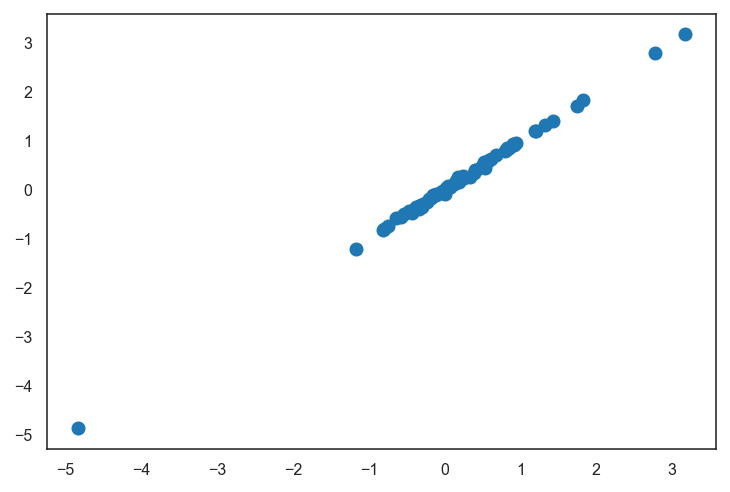

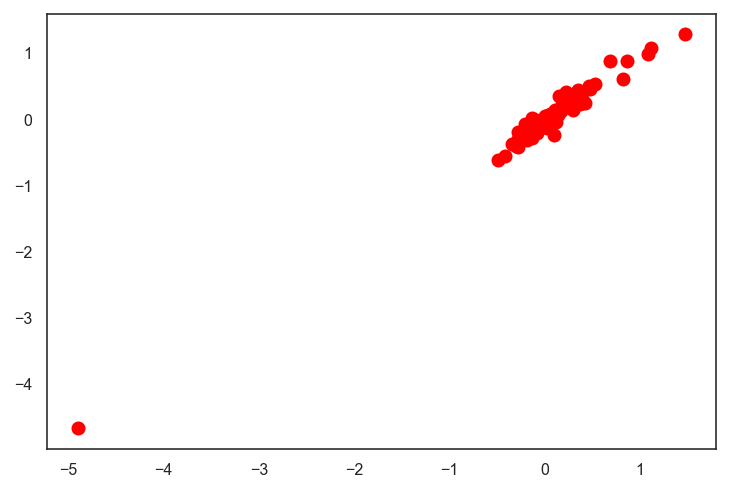

In [137]:
#weights_orig = weights
#m_selection_orig = m_selection
#weights_ps = weights
#m_selection_ps = m_selection
plt.scatter(x=weights_orig.to_numpy(),y=weights_ps.to_numpy())
plt.show()
plt.scatter(x=m_selection_orig.params.to_numpy(),y=m_selection_ps.params.to_numpy(), color='r')
plt.show()

In [268]:
CovidPos_pre_post.shape[0] + CovidNeg_pre_post.shape[0]

3829

In [265]:
weights = H_ps.mean(axis=1).to_frame('weights')
confs = pd.DataFrame(data=np.quantile(H_ps,[0.05,0.95], axis=1).T,index=weights.index,columns=[0,1])
CI = confs.copy()
weights['CI 2.5%'] = CI[0]
weights['CI 97.5%'] = CI[1]
weights

,weights,CI 2.5%,CI 97.5%
const,-5.206299,-6.358932,-4.086995
30-44,0.141447,-0.257043,0.555758
45-54,0.105075,-0.342358,0.555695
55-64,0.052337,-0.462370,0.545931
65-99,-0.060606,-0.826245,0.661613
female,-0.581602,-0.949411,-0.222070
race_ethnicity_hispanic_latino,0.946633,0.502843,1.371302
race_ethnicity_african_american,0.850701,0.275525,1.403977
race_ethnicity_asian,-0.702506,-1.570306,0.721215
race_ethnicity_multi,1.233631,-1.341478,3.760202


In [18]:
import pickle
with open('./data/H_post_stratified_IPW_0p1_fixed.p', 'rb') as f:
    H_ps = pickle.load(f)
with open('./data/H_IPW_0p1_fixed.p', 'rb') as f:
    H_orig = pickle.load(f)
with open('./data/H_drop_ca_ct_IPW_0p1_fixed.p', 'rb') as f:
    H_drop_ca_ct = pickle.load(f)

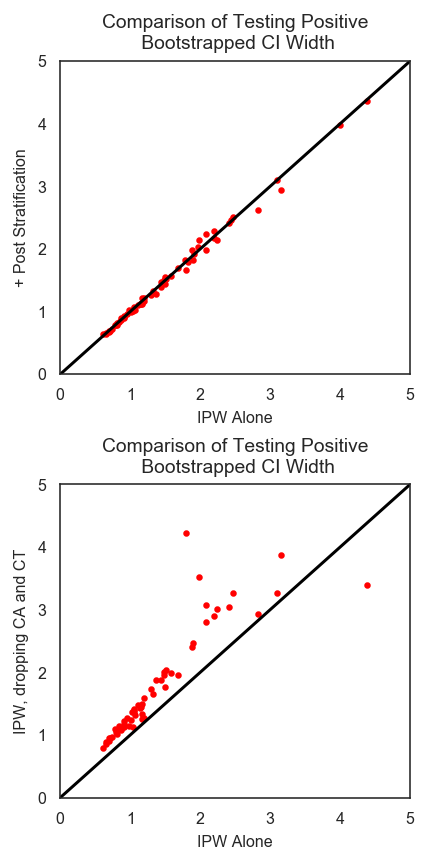

In [158]:
# Compare
plt.figure(figsize=(3,6))
# Ignore constant
plt.subplot(2,1,1)
plt.scatter(x=np.diff(np.quantile(H_orig,[0.05,0.95], axis=1).T)[1::],
            y=np.diff(np.quantile(H_ps,[0.05,0.95], axis=1).T)[1::], color='r',s=5)
plt.plot([-10,10],[-10,10],color='k')
plt.ylabel('+ Post Stratification')
plt.xlabel('IPW Alone')
plt.title('Comparison of Testing Positive\n Bootstrapped CI Width')
plt.xlim([0,5])
plt.ylim([0,5])
plt.subplot(2,1,2)
plt.scatter(x=np.diff(np.quantile(H_orig,[0.05,0.95], axis=1).T)[1::],
            y=np.diff(np.quantile(H_drop_ca_ct,[0.05,0.95], axis=1).T)[1::], color='r', s=5)
plt.plot([-10,10],[-10,10],color='k')
plt.xlim([0,5])
plt.ylim([0,5])
plt.title('Comparison of Testing Positive\n Bootstrapped CI Width')
plt.ylabel('IPW, dropping CA and CT')
plt.xlabel('IPW Alone')
plt.tight_layout()
plt.show()

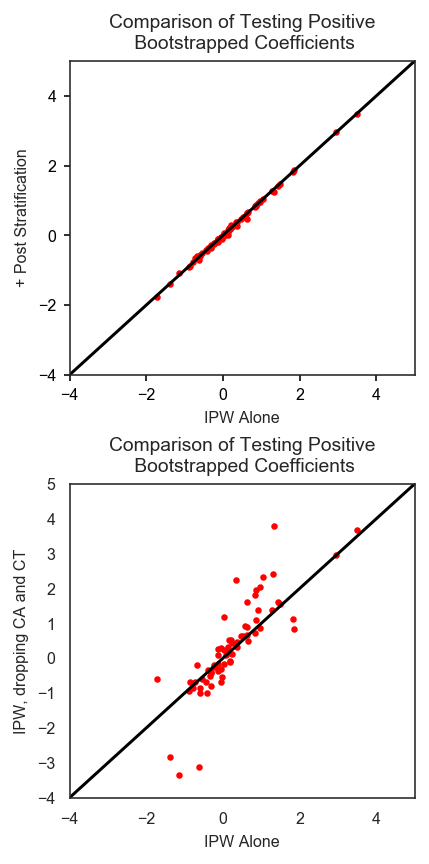

In [292]:
# Compare
plt.figure(figsize=(3,6))
# Ignore constant
plt.subplot(2,1,1)
plt.scatter(x=H_orig.mean(axis=1).to_frame('weights').to_numpy()[1::],
            y=H_ps.mean(axis=1).to_frame('weights').to_numpy()[1::], color='r',s=5)
plt.plot([-10,10],[-10,10],color='k')

plt.ylabel('+ Post Stratification')
plt.xlabel('IPW Alone')
plt.title('Comparison of Testing Positive\n Bootstrapped Coefficients')
plt.xlim([-4,5])
plt.ylim([-4,5])
ax = plt.gca()
ax.xaxis.set_tick_params(width=0.25,length=2)
ax.yaxis.set_tick_params(width=0.25,length=2)
ax.tick_params(which='both', length=3, colors='k', reset=True, bottom=True, right=False, left=True, top=False)
plt.yticks([-4,-2,0,2,4])
plt.subplot(2,1,2)
plt.scatter(x=H_orig.mean(axis=1).to_frame('weights').to_numpy()[1::],
            y=H_drop_ca_ct.mean(axis=1).to_frame('weights').to_numpy()[1::], color='r', s=5)
plt.plot([-10,10],[-10,10],color='k')
plt.xlim([-4,5])
plt.ylim([-4,5])
plt.title('Comparison of Testing Positive\n Bootstrapped Coefficients')
plt.ylabel('IPW, dropping CA and CT')
plt.xlabel('IPW Alone')
plt.tight_layout()
#plt.show()
plt.savefig('post_strata_comparisons.pdf')

In [ ]:
y_err

In [ ]:
# Compare
plt.figure(figsize=(3,6))
# Ignore constant
plt.subplot(2,1,1)
x = H_orig.mean(axis=1).to_frame('weights').to_numpy()[1::]
y = H_ps.mean(axis=1).to_frame('weights').to_numpy()[1::]
x_err = np.quantile(H_orig,[0.05,0.95], axis=1).T[1::].T - x.T
y_err = np.quantile(H_ps,[0.05,0.95], axis=1).T[1::].T - y.T
plt.scatter(x=x,
            y=y, color='r',s=5)
plt.errorbar(x=x,
             y=y, 
             xerr=x_err,
             #yerr=y_err,
             color='r'
            )
plt.plot([-10,10],[-10,10],color='k')
plt.ylabel('+ Post Stratification')
plt.xlabel('IPW Alone')
plt.title('Comparison of Testing Positive\n Bootstrapped Coefficients')
plt.xlim([-4,5])
plt.ylim([-4,5])
plt.subplot(2,1,2)
plt.scatter(x=H_orig.mean(axis=1).to_frame('weights').to_numpy()[1::],
            y=H_drop_ca_ct.mean(axis=1).to_frame('weights').to_numpy()[1::], color='r', s=5)
plt.plot([-10,10],[-10,10],color='k')
plt.xlim([-4,5])
plt.ylim([-4,5])
plt.title('Comparison of Testing Positive\n Bootstrapped Coefficients')
plt.ylabel('IPW, dropping CA and CT')
plt.xlabel('IPW Alone')
plt.tight_layout()
plt.show()

In [148]:
#if use_post_stratified:
#    import pickle
#    with open('./data/H_post_stratified_IPW_0p1_fixed.p', 'wb') as f:
#        pickle.dump(H,f)
#if drop_ca_ct:
#    with open('./data/H_drop_ca_ct_IPW_0p1_fixed.p', 'wb') as f:
#        pickle.dump(H,f)    
#H.shape

In [261]:
#  PLOT unadjusted logistic regression
Pos = CovidPos_pre_post
Neg = CovidNeg_pre_post
Data = pd.concat([Pos,Neg],axis=0)

X = Data[outcome_features]
X2 = sm.add_constant(X.astype(np.float64))

y = pd.concat([pd.DataFrame(data=1,index=Pos.index,columns=['positive']),
               pd.DataFrame(data=0,index=Neg.index,columns=['positive'])],
              axis=0).positive
le = LabelEncoder().fit(y)
y = le.transform(y)

est = sm.Logit(y, X2)
est2 = est.fit(method='cg',maxiter=5000)
est2.summary()

Optimization terminated successfully.
         Current function value: 0.170095
         Iterations: 91
         Function evaluations: 295
         Gradient evaluations: 295


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3829
Model:                          Logit   Df Residuals:                     3758
Method:                           MLE   Df Model:                           70
Date:                Thu, 02 Jul 2020   Pseudo R-squ.:                  0.4016
Time:                        22:38:01   Log-Likelihood:                -651.29
converged:                       True   LL-Null:                       -1088.5
Covariance Type:            nonrobust   LLR p-value:                3.034e-139
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -5.1078      0.619     -8.248      0.000      -6.322      -3.894
30-44                                   0.0683      0.220      0.310      0.756      -0.363       0.500
45-54                                   0.0723      0.251      0.288      0.773      -0.420       0.564
55-64                                  -0.0109      0.270     -0.040      0.968      -0.541       0.519
65-99                                   0.0572      0.399      0.143      0.886      -0.725       0.839
female                                 -0.5446      0.199     -2.734      0.006      -0.935      -0.154
race_ethnicity_hispanic_latino          0.8416      0.242      3.482      0.000       0.368       1.315
race_ethnicity_african_american         0.8175      0.289      2.826      0.005       0.250       1.384
race_ethnicity_asian                   -0.0122      0.589     -0.021      0.984      -1.167       1.143
race_ethnicity_multi                   -0.0200      0.896     -0.022      0.982      -1.776       1.736
race_ethnicity_other_expanded           0.2552      0.662      0.385      0.700      -1.043       1.553
race_ethnicity_unknown                  0.2135      0.847      0.252      0.801      -1.446       1.873
unadj_0-40k                            -0.0257      0.327     -0.078      0.937      -0.667       0.615
unadj_70-100k                          -0.2999      0.187     -1.601      0.109      -0.667       0.067
unadj_100k+                            -0.1379      0.237     -0.582      0.560      -0.602       0.326
preexisting_allergies                  -0.3664      0.171     -2.145      0.032      -0.701      -0.032
preexisting_asthma                     -0.8628      0.231     -3.731      0.000      -1.316      -0.410
preexisting_autoimmune_disease         -0.8760      0.305     -2.868      0.004      -1.475      -0.277
preexisting_cancer                     -0.4213      0.474     -0.889      0.374      -1.350       0.508
preexisting_cardiovascular_disease     -0.9412      0.495     -1.900      0.057      -1.912       0.030
preexisting_chronic_lung_disease       -0.5140      0.627     -0.820      0.412      -1.743       0.715
preexisting_chronic_kidney_disease      0.2472      0.606      0.408      0.683      -0.940       1.435
preexisting_diabetes                    0.1780      0.277      0.643      0.520      -0.364       0.720
preexisting_hypertension                0.1394      0.213      0.655      0.513      -0.278       0.557
preexisting_immunodeficiency           -0.0221      0.372     -0.059      0.953      -0.752       0.708
preexisting_liver_disease               0.4873      0.515      0.946      0.344      -0.523       1.497
preexisting_not_say                     0.0673      0.728      0.092      0.926      -1.360       1.495
preexisting_pregnant                    1.8629      0.506      3.679      0.000       0.871       2.855
used_to_smoke    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


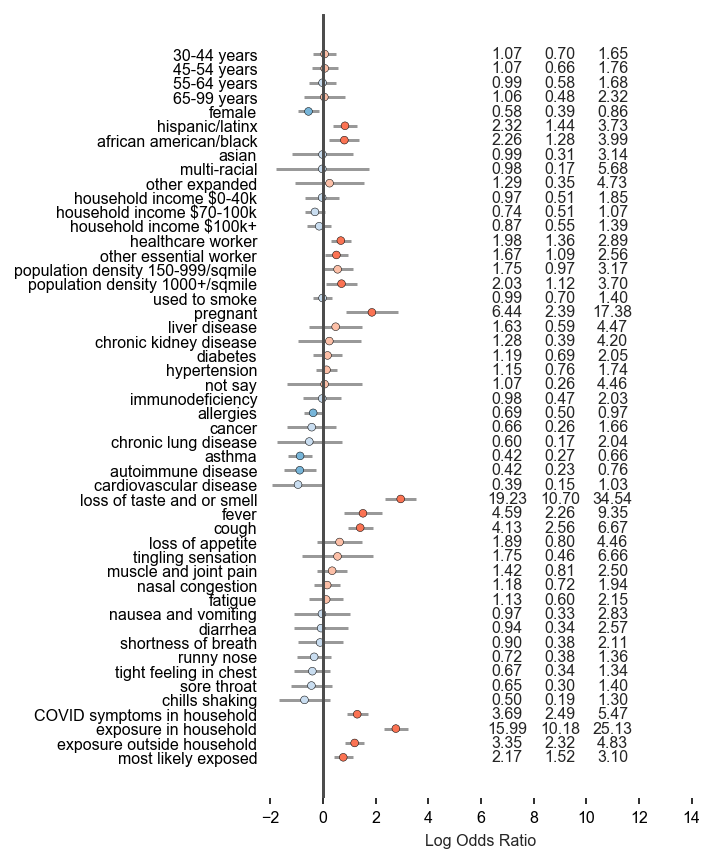

In [262]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

plt.figure(figsize=(5,6))
matplotlib.rcParams.update({'font.size': 8})

weights = est2.params.to_frame('weights')
#weights.rename({'race_ethnicity_hispanic_latino' : 'hispanic/latinx'})
confs = est2.conf_int()
CI = confs.copy()

weights['positive'] = weights['weights'] > 0
#sig = est2.pvalues < 0.05
sig = (CI[0] > 0) | (CI[1] < 0)
weights['sig'] = sig
err_bars = CI[1] - weights['weights']
weights['zipped'] = list(zip(weights.positive, weights.sig))

sorted_symptoms = [duplicate_symptoms_keys_reg[i] for i in np.argsort([-weights['weights'].loc[k] for k in duplicate_symptoms_keys_reg])]
sorted_preexisting = [preexisting[i] for i in np.argsort([-weights['weights'].loc[k] for k in preexisting])]


#sorted_food_source_lim = [food_source_lim[i] for i in np.argsort([weights['weights'].loc[k] for k in food_source_lim])]


# FORR MODEL
features_to_plot = (['30-44', '45-54','55-64', '65-99'] + ['female'] + [r for r in race_pred if not r == 'race_ethnicity_unknown']
            + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
            + profession_lim
            + ['popden_150-999',"popden_1000+"]
            + ['used_to_smoke'] + sorted_preexisting 
            + sorted_symptoms
            + ['covid_19_symptoms_in_household']
            + ['exposed_yes_household',
               'exposed_yes_not_household',
               'exposed_most_likely',
               #'exposed_no_not_likely',
              ]
           )
features_to_plot = list(reversed(features_to_plot))


cmap1 = matplotlib.cm.get_cmap('Blues')
cmap2 = matplotlib.cm.get_cmap('Reds')
#
ax = plt.gca()


ax.errorbar(weights['weights'][features_to_plot], [renamer[u] for u in weights['weights'][features_to_plot].index], xerr = err_bars[features_to_plot], fmt='none',
            linewidth = 1.5, color = "black", alpha = 0.4, capsize = 0,zorder=0)


ax.scatter(weights['weights'][features_to_plot].values,[renamer[u] for u in weights['weights'][features_to_plot].index],c=weights['zipped'][features_to_plot].map({(True,True): cmap2(120), 
                                                          (True,False): cmap2(60), 
                                                          (False,True): cmap1(120),
                                                          (False,False): cmap1(60),
                                                         }), s=15,lw=0.25,edgecolor='k')


plt.axvline(0,color=[0.3,0.3,0.3])

ax.tick_params(which='both', length=3, colors='k', reset=True, right=False, left=False, top=False)
ax.set_xlabel("Log Odds Ratio")
# Overall
for key, spine in ax.spines.items():
    spine.set_visible(False)
#ax.tick_params(left = False, bottom=True)

plt.xlim([-2,14])


y_min, y_max = ax.get_ylim()
ticks = ax.get_yticks()
to_plot = weights['weights'].index
for plot_y,t in zip(ticks,features_to_plot):
    w = np.exp(weights['weights'][t])
    l,r = CI.loc[t,:].values
    l = np.exp(l)
    r = np.exp(r)
    mean = '{0:.2f}'.format(w)
    left = '{0:.2f}'.format(l)
    right = '{0:.2f}'.format(r)
    plt.annotate(xy=(7,plot_y), s=mean,ha='center',va='center')
    plt.annotate(xy=(9,plot_y), s=left, ha='center',va='center')
    plt.annotate(xy=(11,plot_y), s=right, ha='center',va='center')
print(ticks)
plt.tight_layout()
#plt.savefig('propensity/COVID_outcome_regression_14_pre_test_unweighted_.pdf',dpi=300)

(71, 2)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


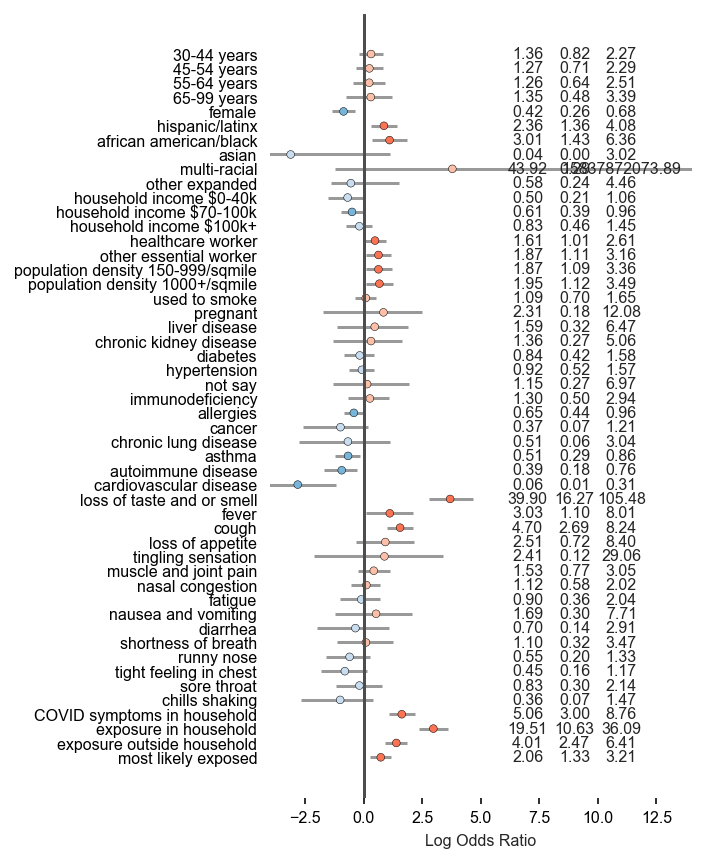

In [229]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

plt.figure(figsize=(5,6))
matplotlib.rcParams.update({'font.size': 8})

H = H_drop_ca_ct

weights = H.mean(axis=1).to_frame('weights')
weights.rename({'race_ethnicity_hispanic_latino' : 'hispanic/latinx'})
confs = pd.DataFrame(data=np.quantile(H,[0.05,0.95], axis=1).T,index=weights.index,columns=[0,1])
CI = confs.copy()

weights['positive'] = weights['weights'] > 0
#sig = est2.pvalues < 0.05
sig = (CI[0] > 0) | (CI[1] < 0)
weights['sig'] = sig
err_bars = np.abs(CI - weights['weights'][:,np.newaxis])
print(err_bars.shape)
weights['zipped'] = list(zip(weights.positive, weights.sig))

#sorted_symptoms = [duplicate_symptoms_keys_reg[i] for i in np.argsort([-weights['weights'].loc[k] for k in duplicate_symptoms_keys_reg])]
#sorted_preexisting = [preexisting[i] for i in np.argsort([-weights['weights'].loc[k] for k in preexisting])]


#sorted_food_source_lim = [food_source_lim[i] for i in np.argsort([weights['weights'].loc[k] for k in food_source_lim])]


# FORR MODEL
features_to_plot = (['30-44', '45-54','55-64', '65-99'] + ['female']  + [r for r in race_pred if not r == 'race_ethnicity_unknown']
            + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
            + profession_lim
            + ['popden_150-999',"popden_1000+"]
            + ['used_to_smoke'] + sorted_preexisting 
            + sorted_symptoms
            + ['covid_19_symptoms_in_household']
            + ['exposed_yes_household',
               'exposed_yes_not_household',
               'exposed_most_likely',
               #'exposed_no_not_likely',
              ]
           )
features_to_plot = list(reversed(features_to_plot))


cmap1 = matplotlib.cm.get_cmap('Blues')
cmap2 = matplotlib.cm.get_cmap('Reds')
#
ax = plt.gca()


ax.errorbar(weights['weights'][features_to_plot], [renamer[u] for u in weights['weights'][features_to_plot].index], xerr = err_bars.T[features_to_plot].to_numpy(), fmt='none',
            linewidth = 1.5, color = "black", alpha = 0.4, capsize = 0,zorder=0)


ax.scatter(weights['weights'][features_to_plot].values,[renamer[u] for u in weights['weights'][features_to_plot].index],c=weights['zipped'][features_to_plot].map({(True,True): cmap2(120), 
                                                          (True,False): cmap2(60), 
                                                          (False,True): cmap1(120),
                                                          (False,False): cmap1(60),
                                                         }), s=15,lw=0.25,edgecolor='k')


plt.axvline(0,color=[0.3,0.3,0.3])

ax.tick_params(which='both', length=3, colors='k', reset=True, right=False, left=False, top=False)
ax.set_xlabel("Log Odds Ratio")
# Overall
for key, spine in ax.spines.items():
    spine.set_visible(False)
#ax.tick_params(left = False, bottom=True)

plt.xlim([-4,14])


y_min, y_max = ax.get_ylim()
ticks = ax.get_yticks()
to_plot = weights['weights'].index
for plot_y,t in zip(ticks,features_to_plot):
    w = np.exp(weights['weights'][t])
    l,r = CI.loc[t,:].values
    l = np.exp(l)
    r = np.exp(r)
    mean = '{0:.2f}'.format(w)
    left = '{0:.2f}'.format(l)
    right = '{0:.2f}'.format(r)
    plt.annotate(xy=(7,plot_y), s=mean,ha='center',va='center')
    plt.annotate(xy=(9,plot_y), s=left, ha='center',va='center')
    plt.annotate(xy=(11,plot_y), s=right, ha='center',va='center')
print(ticks)
plt.tight_layout()


#plt.savefig('propensity/COVID_outcome_regression_14_pre_test_propensity_ipw_0p1_bootstrap.pdf',dpi=300)
#plt.savefig('propensity/COVID_outcome_regression_14_pre_test_post_stratified_propensity_ipw_0p1_bootstrap.pdf',dpi=300)
#plt.savefig('propensity/COVID_outcome_regression_14_pre_test_drop_ca_ct_propensity_ipw_0p1_bootstrap.pdf',dpi=300)

# Figure 4 Analysis

In [205]:
get_cache = {}
results_tmp = results.copy()
results_tmp.loc[:,'session_id'] = results_tmp['session_id'].astype('string')
def get_predicted_post_date(condition = 'positive', testing='true',lag_days=2,post_days=7):
    key = (condition,testing,lag_days,post_days)
    if key in get_cache:
        return get_cache[key].copy()
    else:
        result = _get_predicted_post_date(condition, testing,lag_days,post_days)
        get_cache[key] = result
        return result.copy()
def _get_predicted_post_date(condition = 'positive', testing='true',lag_days=2,post_days=7):
    if testing == 'true':
        if condition == 'positive':
            positive_id_test_dates = results_with_pseudo[(results_with_pseudo.covid_19_swab_test_result == 'positive') & 
                results_with_pseudo.age.gt(17) & results_with_pseudo.age.lt(100)][['session_id','covid_19_swab_test_date']].copy()
            positive_id_test_dates = positive_id_test_dates.rename(columns={'covid_19_swab_test_date' : 'covid_19_swab_test_date_positive'}).copy()
            positive_id_test_dates = positive_id_test_dates[['session_id', 'covid_19_swab_test_date_positive']].copy()
            positive_id_test_dates.loc[:,'covid_19_swab_test_date_positive'] = pd.to_datetime(positive_id_test_dates['covid_19_swab_test_date_positive'])

            positive_id_test_dates.head()
            positive_id_test_dates.loc[:,'session_id'] = positive_id_test_dates['session_id'].astype('string')
            positive_id_test_dates = positive_id_test_dates.groupby('session_id').agg({'covid_19_swab_test_date_positive' : min})
            positive_id_test_dates = positive_id_test_dates.reset_index()
            retrieved = results_tmp.merge(positive_id_test_dates, on='session_id')
            retrieved.loc[:,'date'] = pd.to_datetime(retrieved['date'])
            post_true_test = retrieved[
                                       (retrieved['date'] <= retrieved['covid_19_swab_test_date_positive'] + pd.to_timedelta(post_days,unit='day')) & 
                                       (retrieved['date'] >= retrieved['covid_19_swab_test_date_positive'] + pd.to_timedelta(lag_days,unit='day')) &
                                        retrieved.session_id.isin(CovidPos_pre_post.session_id.unique())
                                      ]    
            return post_true_test
        elif condition == 'negative':
            negative_id_test_dates = results_with_pseudo[(results_with_pseudo.covid_19_swab_test_result == 'negative') & 
                results_with_pseudo.age.gt(17) & results_with_pseudo.age.lt(100)][['session_id','covid_19_swab_test_date']].copy()
            negative_id_test_dates = negative_id_test_dates.rename(columns={'covid_19_swab_test_date' : 'covid_19_swab_test_date_negative'}).copy()
            negative_id_test_dates = negative_id_test_dates[['session_id', 'covid_19_swab_test_date_negative']].copy()
            negative_id_test_dates.loc[:,'covid_19_swab_test_date_negative'] = pd.to_datetime(negative_id_test_dates['covid_19_swab_test_date_negative'])

            negative_id_test_dates.head()
            negative_id_test_dates.loc[:,'session_id'] = negative_id_test_dates['session_id'].astype('string')
            negative_id_test_dates = negative_id_test_dates.groupby('session_id').agg({'covid_19_swab_test_date_negative' : min})
            negative_id_test_dates = negative_id_test_dates.reset_index()
            retrieved = results_tmp.merge(negative_id_test_dates, on='session_id')
            retrieved.loc[:,'date'] = pd.to_datetime(retrieved['date'])
            post_true_test = retrieved[
                                       (retrieved['date'] <= retrieved['covid_19_swab_test_date_negative'] + pd.to_timedelta(post_days,unit='day')) & 
                                       (retrieved['date'] >= retrieved['covid_19_swab_test_date_negative'] + pd.to_timedelta(lag_days,unit='day')) & 
                                        retrieved.session_id.isin(CovidNeg_pre_post.session_id.unique())
                                      ] 
            return post_true_test
    elif testing == 'untested':
        tested_id_test_dates = results_with_pseudo[((results_with_pseudo.covid_19_swab_test_result == 'negative') | (results_with_pseudo.covid_19_swab_test_result == 'positive') | (results_with_pseudo.covid_19_swab_test_result == 'dont_know')) & 
                results_with_pseudo.age.gt(17) & results_with_pseudo.age.lt(100)][['session_id','covid_19_swab_test_date']].copy()
            
        ids = set(tested_id_test_dates.session_id.unique())
        R_ids = set(R.session_id.unique())
        retrieved = results_with_pseudo[(results_with_pseudo.session_id.isin(ids) == False) & 
                                        results_with_pseudo.session_id.isin(R_ids) &
                                results_with_pseudo.age.gt(17) & results_with_pseudo.age.lt(100)
                               ].copy()
        post_pseudo_test = retrieved[(retrieved['date'] >= retrieved['pseudo_test_date'] + pd.to_timedelta(lag_days,unit='day')) & 
                                     (retrieved['date'] <= retrieved['pseudo_test_date'] + pd.to_timedelta(post_days,unit='day')) 
                                    ].copy()            
        return post_pseudo_test

shape
(2269, 1)
shape
(138, 1)
shape
(254751, 1)


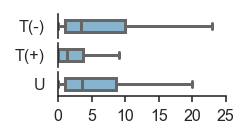

In [208]:
plt.figure(figsize=(1.5,0.75))

x_max = 25

condition = 'negative'
testing = 'true'
post_pseudo_test = get_predicted_post_date(condition = condition, testing=testing, lag_days=2)
g = post_pseudo_test.groupby('session_id').agg({'estimate_people_contact' : np.nanmean})
g1 = g.dropna()
print('shape')
print(g1.shape)
med = np.median(g.dropna())
mean = np.mean(g.dropna()).values[0]
c = [122/255,182/255,217/255,1]

plt.subplot(3,1,1)
l = g.dropna().astype('float').values
sns.boxplot(l,color=c, width=0.5,fliersize=1,showfliers=False)
plt.yticks([0],['T(-)'])
plt.xlim([0,x_max])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks()
ax.get_xaxis().set_visible(False)

condition =  'positive'
testing = 'true'
post_pseudo_test = get_predicted_post_date(condition = condition, testing=testing, lag_days=2)
g = post_pseudo_test.groupby('session_id').agg({'estimate_people_contact' : np.nanmean})
g2 = g.dropna()
print('shape')
print(g2.shape)
med = np.median(g.dropna())
mean = np.mean(g.dropna()).values[0]

plt.subplot(3,1,2)
l = g.dropna().astype('float').values
sns.boxplot(l,color=c, width=0.5,fliersize=1,showfliers=False)
plt.yticks([0],['T(+)'])
plt.xlim([0,x_max])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks()
ax.get_xaxis().set_visible(False)


condition =  ''
testing = 'untested'
post_pseudo_test = get_predicted_post_date(condition = condition, testing=testing, lag_days=2)
#print(post_pseudo_test.session_id.unique().shape)
#post_pseudo_test.loc[:,'estimate_people_contact'] = np.clip(post_pseudo_test['estimate_people_contact'],0,50)
g = post_pseudo_test.groupby('session_id').agg({'estimate_people_contact' : np.nanmean})
g3 = g.dropna()
print('shape')
print(g3.shape)
med = np.median(g.dropna())
mean = np.mean(g.dropna()).values[0]
#g = np.clip(g,0,10).dropna()


plt.subplot(3,1,3)
l = g.dropna().astype('float').values
#_ = plt.hist(l,bins=list(range(12)),color=[122/255,182/255,217/255],density=True)
sns.boxplot(l,color=c, width=0.5,fliersize=1,showfliers=False)
#plt.ylim([0,0.5])
#plt.axvline(med, c='k')
#plt.text(0.92, 0.35, str(med), fontsize=14, transform=plt.gcf().transFigure)
#plt.text(1.15, 0.35, str(np.round(mean,1)), fontsize=14, transform=plt.gcf().transFigure)
plt.yticks([0],['U'])
ax = plt.gca()
plt.xlim([0,x_max])
plt.xticks([0,5,10,15,20,25])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both',length=3, bottom='on')

#plt.savefig('./behavior_figures/med_contact_with_untested.pdf')

In [213]:
PlotData = pd.DataFrame()

lookup = {
    #('positive','false') : 'Predicted(+) never tested',
    ('positive','true') : 'Tested(+)',
    #('negative','false') : 'Predicted(-) never tested',
    ('negative','true') : 'Tested(-)',     
    ('','untested') : 'Untested',
         }

func_mapping = {}
func = 'delivery'
def g_func(post_pseudo_test):
    post_pseudo_test[food_source] = post_pseudo_test[food_source] == 'True'
    g = post_pseudo_test.groupby('session_id').agg({'food_source_delivery' : any})
    return g

def outcome(g):
    return (g > 0).mean().values[0]
func_mapping[func] = (g_func, outcome)

func = 'delivery_only'
def g_func(post_pseudo_test):
    post_pseudo_test[food_source] = post_pseudo_test[food_source] == 'True'
    g = post_pseudo_test.groupby('session_id').agg({f : any for f in food_source})
    return g

def outcome(g):
    g = (g[['food_source_convenience_store',
         'food_source_food_bank',
         'food_source_other',
         'food_source_restaurant',
         'food_source_supermarket']].any(axis=1) == False) & g['food_source_delivery']
    return g.mean()
func_mapping[func] = (g_func, outcome)

func = 'feeling_safe_to_work'
def g_func(post_pseudo_test):
    post_pseudo_test['feeling_safe_to_work_yes'] = post_pseudo_test['feeling_safe_to_work'] == 'yes'
    post_pseudo_test['feeling_safe_to_work_no'] = post_pseudo_test['feeling_safe_to_work'] == 'no'
    g = post_pseudo_test.groupby('session_id').agg({'feeling_safe_to_work_yes' : sum,
                                                   'feeling_safe_to_work_no' : sum,
                                                   })    
    g = g['feeling_safe_to_work_yes'] / (g['feeling_safe_to_work_yes'] + g['feeling_safe_to_work_no'])
    return g

def outcome(g):
    return (g==1).mean()
func_mapping[func] = (g_func, outcome)

func = 'supermarket'
def g_func(post_pseudo_test):
    post_pseudo_test[food_source] = post_pseudo_test[food_source] == 'True'
    g = post_pseudo_test.groupby('session_id').agg({'food_source_supermarket' : any})
    return g

def outcome(g):
    return (g > 0).mean().values[0]
func_mapping[func] = (g_func, outcome)

func = 'estimate_people_contact'

def g_func(post_pseudo_test):
    post_pseudo_test['estimate_people_contact'] = np.clip(post_pseudo_test['estimate_people_contact'],0,50)
    g = post_pseudo_test.groupby('session_id').agg({'estimate_people_contact' : np.nanmean})
    return g

def outcome(g):
    return g.mean().values[0]
func_mapping[func] = (g_func, outcome)

func = 'combined_left_for_work'
def g_func(post_pseudo_test):
    post_pseudo_test.loc[:,'combined_left_for_work'] = post_pseudo_test['combined_left_for_work'] =='True'    
    g = post_pseudo_test.groupby('session_id').agg({'combined_left_for_work' : np.mean})
    return g

def outcome(g):
    return (g > 0).mean().values[0]
func_mapping[func] = (g_func, outcome)

func = 'combined_left_for_work_no_mask'
def g_func(post_pseudo_test):
    post_pseudo_test.loc[:,'combined_left_for_work'] = post_pseudo_test['combined_left_for_work'] =='True'
    post_pseudo_test.loc[:,'mask_true'] = post_pseudo_test['protective_measures_face_mask'] =='True'
    post_pseudo_test.loc[:,'combined_left_for_work|no_mask'] = post_pseudo_test['combined_left_for_work'] & (post_pseudo_test['protective_measures_face_mask'] =='False')
    g = post_pseudo_test.groupby('session_id').agg({'combined_left_for_work|no_mask' : np.mean})
    return g

def outcome(g):
    return (g>0).mean().values
func_mapping[func] = (g_func, outcome)

for func in ['combined_left_for_work','combined_left_for_work_no_mask']:
    g_func, outcome = func_mapping[func]

    for condition,testing in lookup.keys():
        key = lookup[(condition,testing)]
        post_pseudo_test = get_predicted_post_date(condition = condition, testing=testing, lag_days=2)

        g = g_func(post_pseudo_test)
        n = g.shape[0]
        S = []
        for k in range(2000):
            if k % 100 == 0:
                print(k)
            g_sample = g.sample(n,replace=True)
            s = outcome(g_sample)
            S.append(s)
        CI = np.quantile(S,q=[0.025,0.975])
        m = np.mean(S)

        PlotData.loc[key,func+'_'+'val'] = m
        PlotData.loc[key,func+'_'+'numerator_naive'] = outcome(g)*n
        PlotData.loc[key,func+'_'+'denominator_naive'] = n
        PlotData.loc[key,func+'_'+'LB'] = CI[0]
        PlotData.loc[key,func+'_'+'UB'] = CI[1]


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [215]:
PlotData[['combined_left_for_work_numerator_naive','combined_left_for_work_denominator_naive','combined_left_for_work_no_mask_numerator_naive','combined_left_for_work_no_mask_denominator_naive']]

,combined_left_for_work_numerator_naive,combined_left_for_work_denominator_naive,combined_left_for_work_no_mask_numerator_naive,combined_left_for_work_no_mask_denominator_naive
Tested(+),14.0,203.0,7.0,203.0
Tested(-),664.0,2533.0,255.0,2533.0
Untested,62483.0,269833.0,34481.0,269833.0


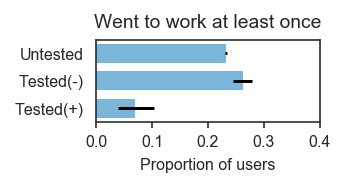

In [224]:
func = 'combined_left_for_work'

plt.figure(figsize=(2,.75))
plt.barh(PlotData[func+'_'+'val'].index,PlotData[func+'_'+'val'].values,color=[122/255,182/255,217/255],alpha=1,
        height=0.7,lw=0)
eb = np.abs((PlotData[[func+'_'+'LB',func+'_'+'UB',]] - PlotData[func+'_'+'val'][:,np.newaxis]).values.T)
plt.errorbar(x=PlotData[func+'_'+'val'].values,y=PlotData[func+'_'+'val'].index,xerr=eb,
            elinewidth=1.5,capsize=0,color='k',ls='none')

plt.title('Went to work at least once')
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=3, bottom='on')

plt.xticks([0,0.1,0.2,0.3,0.4])
plt.xlim([0,0.4])
plt.xlabel('Proportion of users')

plt.savefig('./behavior_figures/'+func+'_untested_.pdf')

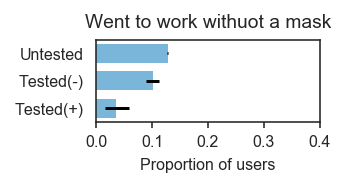

In [225]:
func = 'combined_left_for_work_no_mask'

plt.figure(figsize=(2,.75))
plt.barh(PlotData[func+'_'+'val'].index,PlotData[func+'_'+'val'].values,color=[122/255,182/255,217/255],alpha=1,
        height=0.7,lw=0)
eb = np.abs((PlotData[[func+'_'+'LB',func+'_'+'UB',]] - PlotData[func+'_'+'val'][:,np.newaxis]).values.T)
plt.errorbar(x=PlotData[func+'_'+'val'].values,y=PlotData[func+'_'+'val'].index,xerr=eb,
            elinewidth=1.5,capsize=0,color='k',ls='none')

plt.title('Went to work withuot a mask')
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=3, bottom='on')

plt.xticks([0,0.1,0.2,0.3,0.4])
plt.xlim([0,0.4])
plt.xlabel('Proportion of users')

plt.savefig('./behavior_figures/'+func+'_untested_.pdf')

# Regression analysis Figure 4


In [ ]:
## tested_pos  = get_predicted_post_date(condition = 'positive', testing='true', lag_days=2, post_days=7)
tested_neg  = get_predicted_post_date(condition = 'negative', testing='true', lag_days=2, post_days=7)


tested_pos.loc[:,'Covid+'] = True
tested_neg.loc[:,'Covid+'] = False

merged = pd.concat([tested_pos,tested_neg],axis=0)

# Age featurization
age_bucket_labels = ['18-54','55-99']
cut_bucket = [17, 55, 99]  # Age bucket boundaries. 
labels = range(len(cut_bucket)-1)
age_transformer = preprocessing.OneHotEncoder()
age_transformer.fit(np.array([labels]).T)

# Age bucketization
merged['age_bucket'] = pd.cut(merged['age'], cut_bucket, labels=labels).to_numpy()
transformed = age_transformer.transform(merged['age_bucket'].to_numpy().reshape(-1, 1)).todense()
ohe_df = pd.DataFrame(transformed, index=merged.index, columns=age_bucket_labels)
merged = pd.concat([ohe_df, merged], axis=1).drop(['age_bucket'], axis=1)


L = ['race_ethnicity_african_american',
 'race_ethnicity_american_indian_or_alaska_native',
 'race_ethnicity_asian',
 'race_ethnicity_hawaiian_or_islander',
 'race_ethnicity_hispanic_latino',
 'race_ethnicity_white', # We should use white as baseline
 'race_ethnicity_other',]
for z in L:
    merged[z] = merged[z] == 'True'
    
# Create multi racial category
mask_multi = merged[L].sum(axis=1) >= 2

merged['race_ethnicity_multi'] = mask_multi
merged.loc[merged[mask_multi].index,L] = False

mask_unknown = merged[L].any(axis=1) == False
merged['race_ethnicity_unknown'] = mask_unknown | merged['race_ethnicity_not_say']
merged['race_ethnicity_other_expanded'] = merged['race_ethnicity_other'] | merged['race_ethnicity_american_indian_or_alaska_native'] | merged['race_ethnicity_hawaiian_or_islander']

merged['race_ethnicity_nonwhite'] = merged['race_ethnicity_white'] == False

merged['profession_healthcare'] = merged['profession_essential_cat'] == 'healthcare'
merged['profession_other_essential'] = merged['profession_essential_cat'] == 'other_essential'
merged['profession_nonessential'] = merged['profession_essential_cat'] == 'nonessential'

merged = add_population_density(merged)
df_temp = df_income.set_index('zip code tabulation area')
med_income_lookup = df_temp['MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)'].to_dict()

def apply_weights(x):
    x_race = None
    x_ext = None
    for r,ext in race_list:
        if x[r]:
            x_race = r  
            x_ext = ext
    if x_race is None:
        assert x['race_ethnicity_unknown'], str(x)
    age = None

    ztca = zip_to_zcta.get(str(int(x.zipcode)).zfill(5),-1)
    income = med_income_lookup.get(ztca, -66666666)

    return income
merged['income_unadjusted'] = merged.apply(apply_weights, axis=1)

income_bucket_labels = ['unknown_income_unadjusted', 'unadj_0-100k','unadj_100k+']
income_cut_bucket = [-999999999999, 0, 100000, 10000000000]  # Age bucket boundaries. 
income_labels = range(len(income_cut_bucket)-1)
income_transformer = preprocessing.OneHotEncoder()
income_transformer.fit(np.array([income_labels]).T)

merged['income_bucket_unadjusted'] = pd.cut(merged['income_unadjusted'].fillna(-66666666), income_cut_bucket, labels=income_labels).to_numpy()
transformed = income_transformer.transform(merged['income_bucket_unadjusted'].to_numpy().reshape(-1, 1)).todense()
ohe_df = pd.DataFrame(transformed, index=merged.index, columns=income_bucket_labels)
merged = pd.concat([ohe_df, merged], axis=1).drop(['income_bucket_unadjusted'], axis=1)

merged.loc[:,'combined_left_for_work'] = merged['combined_left_for_work'] =='True'
merged.loc[:,'mask_true'] = merged['protective_measures_face_mask'] =='True'
merged.loc[:,'combined_left_for_work|no_mask'] = merged['combined_left_for_work'] & (merged['protective_measures_face_mask'] =='False')

merged['estimate_people_contact'] = np.clip(merged['estimate_people_contact'],0,50)

g = merged.groupby('session_id').agg({'combined_left_for_work' : any, 
                                      'combined_left_for_work|no_mask' : any,
                                      'estimate_people_contact' : np.nanmean,
                                  'Covid+' : any})
g = g.reset_index()
M = merged.groupby('session_id').first()
#M = M.reset_index()
M = M.drop(columns=[c for c in M.columns if c in g.columns])
g = g.join(M,on='session_id')

g['female'] = g['gender'] == 'female'

X2 = g[['female','55-99','race_ethnicity_hispanic_latino',
 'race_ethnicity_african_american',
 'race_ethnicity_asian',
 'race_ethnicity_multi',
 'race_ethnicity_other_expanded',
 'race_ethnicity_unknown',
        'popden_1000+',
        'Covid+','profession_healthcare','profession_other_essential',
       ]]

print(g['combined_left_for_work'].sum(),g['combined_left_for_work'].shape[0])
X2 = sm.add_constant(X2.astype(np.float64))
est = sm.Logit(g['combined_left_for_work'], X2)
est2 = est.fit(method='cg',maxiter=5000)
est2.summary()

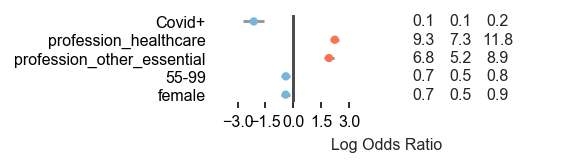

In [256]:
import matplotlib
plt.figure(figsize=(3,0.8))

to_plot = ['Covid+','profession_healthcare','profession_other_essential','55-99','female']
to_plot = list(reversed(to_plot))

weights = est2.params.to_frame('weights')
weights['positive'] = weights['weights'] > 0
sig = est2.pvalues < 0.05
weights['sig'] = sig
CI = est2.conf_int()
err_bars = est2.conf_int()[0] - weights['weights']
weights['zipped'] = list(zip(weights.positive, weights.sig))

cmap1 = matplotlib.cm.get_cmap('Blues')
cmap2 = matplotlib.cm.get_cmap('Reds')

ax = plt.gca()

features_to_plot = weights['weights'].index

ax.errorbar(weights.loc[to_plot,'weights'], weights.loc[to_plot,'weights'].index, xerr = np.abs(err_bars.loc[to_plot]), fmt='none',
            linewidth = 1.5, color = "black", alpha = 0.4, capsize = 0,zorder=0)

ax.scatter(weights.loc[to_plot,'weights'].values,weights.loc[to_plot,'weights'].index,c=weights.loc[to_plot,'zipped'].map({(True,True): cmap2(120), 
                                                          (True,False): cmap2(60), 
                                                          (False,True): cmap1(120),
                                                          (False,False): cmap1(60),
                                                         }),s=10)
plt.axvline(0,color=[0.3,0.3,0.3])

ax.tick_params(which='both', length=3, colors='k', reset=True, right=False, left=False, top=False)
ax.set_xlabel("Log Odds Ratio")
# Overall
for key, spine in ax.spines.items():
    spine.set_visible(False)
#ax.tick_params(left = False, bottom=True)

plt.xticks([-3,-1.5,0,1.5,3])
plt.xlim([-2,10])

plt.xlim([-4,14])


y_min, y_max = ax.get_ylim()
ticks = ax.get_yticks()
for plot_y,t in zip(ticks,to_plot):
    w = np.exp(weights['weights'][t])
    l,r = CI.loc[t,:].values
    l = np.exp(l)
    r = np.exp(r)
    mean = '{0:.1f}'.format(w)
    left = '{0:.1f}'.format(l)
    right = '{0:.1f}'.format(r)
    plt.annotate(xy=(7,plot_y), s=mean,ha='center',va='center')
    plt.annotate(xy=(9,plot_y), s=left, ha='center',va='center')
    plt.annotate(xy=(11,plot_y), s=right, ha='center',va='center')

plt.savefig('COVID_tested_leave_for_work_.pdf',dpi=300)






In [273]:
CovidNeg_pre_post.shape

(3514, 378)

# ML Analysis

In [275]:
all_features = (['30-44', '45-54','55-64', '65-99'] + ['age'] + ['female'] + race_pred 
                + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
                + ['0-40k','70-100k', '100k+'] 
                + ['income_unadjusted'] + ['income']
                + preexisting
                + ['used_to_smoke'] + feeling + symptoms
                + temperature
                + household_counts 
                + prot 
                + ['protective_face_mask_perc', 'protective_measures_social_distancing_perc']
                + profession_lim 
                + ['popden_150-999',"popden_1000+"]
                + ['contact_0',
                   #'contact_1-4',
                   'contact_5+',
                   'contact_isnan']
                + ['covid_19_symptoms_in_household']
                + ['exposed_yes_household',
                   'exposed_yes_not_household',
                   'exposed_most_likely',
                   #'exposed_no_not_likely',
                  ]
                + ['sleep_less_than_5', 
                   'sleep_5_to_6_hours',
                   #'sleep_7_to_8_hours', 
                   'sleep_9_to_10_hours', 
                   'sleep_11_or_more_hours']
                +['pop_density_county']
               )

all_features_merged = (['30-44', '45-54','55-64', '65-99'] + ['age'] + ['female'] + race_pred 
                       + ['unadj_0-40k','unadj_70-100k', 'unadj_100k+'] 
                       + ['0-40k','70-100k', '100k+'] 
                       + ['income_unadjusted'] + ['income']
                       + preexisting
                       + ['used_to_smoke']
                       + duplicate_symptoms_keys_reg
                       + temperature
                       + household_counts 
                       + prot 
                       + ['protective_face_mask_perc', 'protective_measures_social_distancing_perc']
                       + profession_lim 
                       + ['popden_150-999',"popden_1000+"]
                       + ['contact_0',
                          #'contact_1-4',
                          'contact_5+',
                          'contact_isnan']
                       + ['covid_19_symptoms_in_household']
                       + ['exposed_yes_household',
                          'exposed_yes_not_household',
                          'exposed_most_likely',
                          #'exposed_no_not_likely',
                         ]
                       + ['sleep_less_than_5', 
                          'sleep_5_to_6_hours',
                          #'sleep_7_to_8_hours', 
                          'sleep_9_to_10_hours', 
                          'sleep_11_or_more_hours']
                       +['pop_density_county']
                      )

symptoms_features = [ 'feeling',
                     'not_well_symptoms_abdominal_pain',
                     'not_well_symptoms_chills_shaking',
                     'not_well_symptoms_diarrhea',
                     'not_well_symptoms_dry_cough',
                     'not_well_symptoms_fever',
                     'not_well_symptoms_irregular_heartbeat',
                     'not_well_symptoms_loss_of_appetite',
                     'not_well_symptoms_loss_of_taste_and_or_smell',
                     'not_well_symptoms_muscle_and_joint_pain',
                     'not_well_symptoms_nasal_congestion',
                     'not_well_symptoms_nausea_and_vomiting',
                     'not_well_symptoms_runny_nose',
                     'not_well_symptoms_shortness_of_breath',
                     'not_well_symptoms_sore_throat',
                     'not_well_symptoms_tight_feeling_in_chest',
                     'not_well_symptoms_tingling_sensation',
                     'not_well_symptoms_tinnitus',
                     'not_well_symptoms_wet_cough',
                     'symptoms_well_chills',
                     'symptoms_well_cough',
                     'symptoms_well_headache',
                     'symptoms_well_loss_of_taste_and_or_smell',
                     'symptoms_well_low_grade_fever',
                     'symptoms_well_mild_fatigue',
                     'symptoms_well_muscle_and_joint_pain',
                     'symptoms_well_nasal_congestion',
                     'symptoms_well_runny_nose',
                     'symptoms_well_tight_feeling_in_chest',
                     'symptoms_temp_f_100-101',
                     'symptoms_temp_f_101-102',
                     'symptoms_temp_f_102+',]

cdc_features = ['feeling',
                'not_well_symptoms_chills_shaking',
                'not_well_symptoms_dry_cough',
                'not_well_symptoms_fever',
                'not_well_symptoms_loss_of_taste_and_or_smell',
                'not_well_symptoms_muscle_and_joint_pain',
                'not_well_symptoms_shortness_of_breath',
                'not_well_symptoms_wet_cough',
                'symptoms_well_chills',
                'symptoms_well_cough',
                'symptoms_well_loss_of_taste_and_or_smell',
                'symptoms_well_low_grade_fever',
                'symptoms_well_muscle_and_joint_pain',]


cdc_features = ['symptoms_cough',
                'symptoms_chills_shaking',
                'symptoms_loss_of_taste_and_or_smell',
                'symptoms_sore_throat',      
                'symptoms_muscle_and_joint_pain',
                'symptoms_fever',
                'symptoms_shortness_of_breath',
               ]

five_features = ['preexisting_asthma',
                 'not_well_symptoms_loss_of_taste_and_or_smell',
                 'covid_19_symptoms_in_household',
                 'exposed_yes_household',
                 'exposed_yes_not_household'
                ]


four_questions = [
    'symptoms_loss_of_taste_and_or_smell',
    'covid_19_symptoms_in_household',
    'exposed_yes_household',
    'exposed_most_likely',
    'exposed_no_not_likely',
    'exposed_yes_not_household']

In [281]:
pre = False

feature_groups = {'all_features' : all_features, 'cdc_features' : cdc_features, 'four_questions': four_questions}

if pre:
    CovidPos = CovidPos_pre
    CovidNeg = CovidNeg_pre
else:
    CovidPos = CovidPos_pre_post
    CovidNeg = CovidNeg_pre_post

In [277]:
# Get the Stratified K Fold Cross Validation Scores
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

#search = GridSearchCV(calibrated_forest, param_grid, cv=5)

from sklearn.svm import SVC
Pos = CovidPos[features]
Neg = CovidNeg[features]
X = pd.concat([Pos,Neg],axis=0)#.fillna(False)
if 'age' in X:
    X['age'] = (X['age'])/100
if 'income'in X:
    X['income'] = (X['income'] -60000) / 300000000
if 'income_unadjusted' in X:
    X['income_unadjusted'] = (X['income_unadjusted']-60000) / 30000000
if 'pop_density_county' in X:
    X['pop_density_county'] = X['pop_density_county']/10000
if 'protective_face_mask_gt50' in X:
    X['protective_face_mask_gt50'] = X['protective_face_mask_gt50'] == True

y = pd.concat([pd.DataFrame(data=1,index=Pos.index,columns=['positive']),
               pd.DataFrame(data=0,index=Neg.index,columns=['positive'])],
              axis=0).positive
le = LabelEncoder().fit(y)
y = le.transform(y)


n_splits = 5
if pre:    
    folds_pre = list(StratifiedKFold(n_splits).split(X,y))
    folds = folds_pre
else:
    folds_post = list(StratifiedKFold(n_splits).split(X,y))
    folds = folds_post

In [279]:
model_bank = {'SVC': (SVC,
                      {'probability' : True},
                      {'C': np.logspace(-2.0, 2.0, num=21),
                       'gamma': np.logspace(-2.0, 2.0, num=21),
                       'kernel': ['linear','rbf']}
                      ),
              'Logistic': (LogisticRegression,
                           {'penalty':'none', 'max_iter':10000},
                           {}
                          ),
              'LogisticL1': (LogisticRegression,
                               {'penalty':'l1', 'solver':'liblinear', 'max_iter':10000},
                               {'C': np.logspace(-5.0, 5.0, num=51),}
                              ),
              'LogisticL2': (LogisticRegression,
                               {'penalty':'l2', 'max_iter':10000},
                               {'C': np.logspace(-5.0, 5.0, num=51),}
                              ),              
              'RandomForest' : (RandomForestClassifier,
                                {},
                                 {'n_estimators' : [10,20,30,40,50,75,100],
                                  'max_depth' : [2,3,4,5,6,10],}
                                ),
              'XGBoost' : (xgb.XGBClassifier,
                           {},
                           {'n_estimators' : [20,25,30,35,40,45,50],
                            'gamma' : [0],
                            'max_depth' : [2,3,4,5],
                            'subsample' : [0.9,1],
                            'reg_alpha' : [0,0.1,1,10,50],
                            'reg_lambda' : [0,0.1,1,10,50,100,200],}
                          ),
              'NearestNeighbors' : (KNeighborsClassifier,
                                    {},
                                    {'n_neighbors' : [2,5,10,15,20],
                                      'weights' : ['uniform', 'distance'],
                                      'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                                      'leaf_size' : [10,30,50],}
                                   ),
              'GB' : (GradientBoostingClassifier,                      
                      {},
                      {'loss' : ['deviance', 'exponential'],
                       'n_estimators' : [10,20,30,40,50,75,100],
                       'learning_rate' : [0.001,0.01,0.1,1],
                       'max_depth' : [2,3,4,5]}
                     ),
              'NeuralNet' : (MLPClassifier,
                             {'solver':'adam','max_iter':6000,'early_stopping':True},
                             {'activation' : ['relu'],
                              'alpha' : np.logspace(-2.0, 2.0, num=21),
                              'learning_rate_init' : [0.001,0.01,0.1],
                              'hidden_layer_sizes' : [(5,),(20,),(30,),(40,),(50,),(60,),(70,),(20,5),(20,20),(50,5),(50,20),(50,50),(70,5),(70,20),(5,50),(10,50)]
                             },
                            )
             }
all_y_score_dict = {}
all_y_true_dict = {}

####
False all_features
####

Logistic FOLD: 0

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    4.2s finished


{}
[0.8310415678836731]

Logistic FOLD: 1

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


{}
[0.8310415678836731, 0.9225767120503963]

Logistic FOLD: 2

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


{}
[0.8310415678836731, 0.9225767120503963, 0.9037232721443248]

Logistic FOLD: 3

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.2s finished


{}
[0.8310415678836731, 0.9225767120503963, 0.9037232721443248, 0.8847117794486214]

Logistic FOLD: 4

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.3s finished


{}
[0.8310415678836731, 0.9225767120503963, 0.9037232721443248, 0.8847117794486214, 0.9046262379595713]
Score: 0.9328811071861294
AUC: 0.8893359138973175


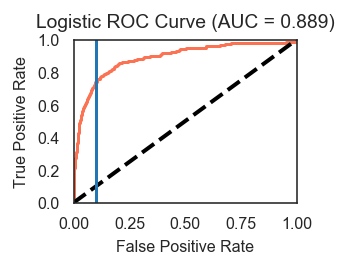


LogisticL1 FOLD: 0

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 240 out of 255 | elapsed:    2.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    2.8s finished


{'C': 1.0}
[0.8977624240782135]

LogisticL1 FOLD: 1

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 240 out of 255 | elapsed:    2.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    3.0s finished


{'C': 0.6309573444801942}
[0.8977624240782135, 0.9327372485267222]

LogisticL1 FOLD: 2

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 240 out of 255 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    2.8s finished


{'C': 0.25118864315095824}
[0.8977624240782135, 0.9327372485267222, 0.905529589740116]

LogisticL1 FOLD: 3

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 240 out of 255 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.6309573444801942}
[0.8977624240782135, 0.9327372485267222, 0.905529589740116, 0.90315879789564]

LogisticL1 FOLD: 4

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 240 out of 255 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    3.3s finished


{'C': 0.39810717055349776}
[0.8977624240782135, 0.9327372485267222, 0.905529589740116, 0.90315879789564, 0.9143038031926921]
Score: 0.9320967934606392
AUC: 0.9106983726866767


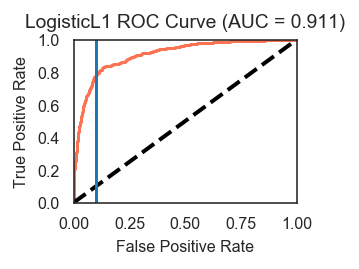


LogisticL2 FOLD: 0

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.15848931924611143}
[0.9038587459640091]

LogisticL2 FOLD: 1

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.39810717055349776}
[0.9038587459640091, 0.9300277721330352]

LogisticL2 FOLD: 2

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.15848931924611143}
[0.9038587459640091, 0.9300277721330352, 0.9050554313712208]

LogisticL2 FOLD: 3

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 240 out of 255 | elapsed:    5.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.39810717055349776}
[0.9038587459640091, 0.9300277721330352, 0.9050554313712208, 0.9020975863081125]

LogisticL2 FOLD: 4

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 255 out of 255 | elapsed:    4.9s finished


{'C': 0.15848931924611143}
[0.9038587459640091, 0.9300277721330352, 0.9050554313712208, 0.9020975863081125, 0.9114774114774115]
Score: 0.9328804245806243
AUC: 0.9105033894507578


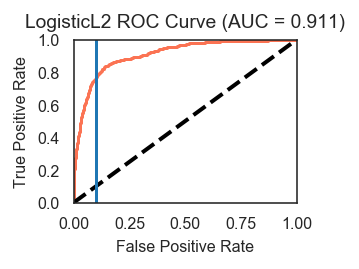


XGBoost FOLD: 0

Fitting 5 folds for each of 1960 candidates, totalling 9800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   45.0s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:  7.1min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 10.7min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 9800 out of 9800 | elapsed: 13.8mi

{'gamma': 0, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.9}
[0.8746415588520852]

XGBoost FOLD: 1

Fitting 5 folds for each of 1960 candidates, totalling 9800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   20.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   40.9s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 12.4min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 16.7min
[Parallel(n_jobs=8)]: Done 9800 out of 9800 | elapsed: 16.7mi

{'gamma': 0, 'max_depth': 3, 'n_estimators': 40, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1}
[0.8746415588520852, 0.9377723588249903]

XGBoost FOLD: 2

Fitting 5 folds for each of 1960 candidates, totalling 9800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   13.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   26.9s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   51.9s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  5.0min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 9800 out of 9800 | elapsed: 13.2mi

{'gamma': 0, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.9}
[0.8746415588520852, 0.9377723588249903, 0.9137483348009665]

XGBoost FOLD: 3

Fitting 5 folds for each of 1960 candidates, totalling 9800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   44.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 11.4min


KeyboardInterrupt: 

In [282]:
import sklearn.base


for feature_name, features in feature_groups.items():
    print("####")
    print(pre, feature_name)
    print('####')
    if pre:
        CovidPos = CovidPos_pre
        CovidNeg = CovidNeg_pre
    else:
        CovidPos = CovidPos_pre_post
        CovidNeg = CovidNeg_pre_post
        
    # Featurize
    Pos = CovidPos[features]
    Neg = CovidNeg[features]
    X = pd.concat([Pos,Neg],axis=0)#.fillna(False)
    if 'age' in X:
        X['age'] = (X['age'])/100
    if 'income'in X:
        X['income'] = (X['income'] -60000) / 300000000
    if 'income_unadjusted' in X:
        X['income_unadjusted'] = (X['income_unadjusted']-60000) / 30000000
    if 'pop_density_county' in X:
        X['pop_density_county'] = X['pop_density_county']/10000
    if 'protective_face_mask_gt50' in X:
        X['protective_face_mask_gt50'] = X['protective_face_mask_gt50'] == True

    y = pd.concat([pd.DataFrame(data=1,index=Pos.index,columns=['positive']),
                   pd.DataFrame(data=0,index=Neg.index,columns=['positive'])],
                  axis=0).positive
    le = LabelEncoder().fit(y)
    y = le.transform(y)

    n_splits = 5

    if pre:
        folds = folds_pre
    else:
        folds = folds_post

    for model_name in ['Logistic','LogisticL1','LogisticL2', 'XGBoost']:#model_bank:
        model,initializer,param_grid = model_bank[model_name]

        scores = []
        auc = []
        coefs = []
        all_y_true = []
        all_y_score = []
        for k,(train_idx, test_idx) in enumerate(folds):
            print()
            print(model_name+' FOLD: '+str(k))
            print()    
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            # GRID search for model on training data to identify best parameters
            covid19_mdl = model(**initializer)
            gscv = GridSearchCV(covid19_mdl, param_grid, cv=5,verbose=1, n_jobs=8)
            gscv.fit(X_train, y_train)
            print(gscv.best_params_)

            covid19_mdl = gscv.best_estimator_

            y_score = covid19_mdl.predict_proba(X_test)[:,1]
            auc.append(roc_auc_score(y_test, y_score))
            print(auc)
            scores.append(covid19_mdl.score(X_test, y_test))
            fpr, tpr, thresh = roc_curve(y_test, y_score)
            all_y_true.extend(y_test)
            all_y_score.extend(y_score)

        print("Score:", np.mean(scores))
        print("AUC:", np.mean(auc))

        fpr, tpr, thresh = roc_curve(all_y_true, all_y_score)

        plt.figure(figsize=(2,1.5))
        lw = 2
        #plt.plot(fpr,tpr,color='orange');
        plt.plot(fpr, tpr, color=[251/255,115/255,83/255])
        plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.title(model_name + " ROC Curve (AUC = %0.03f)" % np.mean(auc))

        if pre:
            name = 'pre_test_'+feature_name+'_'+model_name
        else:
            name = 'pre_and_post_test_'+feature_name+'_'+model_name
        
        
        #plt.savefig('Fig4 Plots/'+name+'.pdf',dpi=300)
        #plt.tight_layout()
        plt.axvline(0.1)
        plt.show()

        all_y_true_dict[(pre,feature_name,model_name)] = all_y_true
        all_y_score_dict[(pre,feature_name,model_name)] = all_y_score